In [132]:
# pip install subword-nmt seaborn lifelines openpyxl matplotlib scikit-learn openTSNE
# pip install torchmetrics==1.2.0 pandas==2.1.4 numpy==1.26.4
# python3 ./main_kfold.py --config utils/config.py
import torch.nn as nn
from utils.Loss import Custom_LossFunction,Custom_Weighted_LossFunction,FocalLoss
from utils.Custom_Activation_Function import ScaledSigmoid, ReLU_clamp
from utils.Metrics import MetricsCalculator_nntorch

model_inference = True # False
if model_inference is True:
    cohort = "TCGA"
    geneNUM = "" # _4692genes tcgadata tcgalabel tcgadata_4692genes tcgalabel_4692genes

test = False #False, True: batch_size = 3, num_epoch = 2, full dataset
drug_df_path= "../data/GDSC/GDSC_drug_merge_pubchem_dropNA_MACCS.csv"
one_drug=None # gsk690693 trametinib erlotinib
ESPF_file = "./ESPF/subword_units_map_chembl_freq_1500.csv"
AUC_df_path_numerical = "../data/GDSC/lorio GDSC1 by ccl balanced_high LNic50 downsample 17088 CCL552drug238cancerType18 stack.csv" # gdsc1+2_ccle_z-score　gdsc1+2_ccle_AUC
AUC_df_path = "../data/GDSC/lorio GDSC1 by ccl balanced_high LNic50 downsample 17088 CCL552drug238cancerType18 stack.csv"
response_file = 'down'
omics_files = {
    'Mut': "",
    'Exp': "../data/DAPL/share/ccle_uq1000_feature_sorted.csv", # "../data/CCLE/CCLE_exp_476samples_4692genes.txt",
    # Add more omics types and paths as needed
    }
omics_dict = {'Mut':0,'Exp':1,'CN':2, 'Eff':3, 'Dep':4, 'Met':5}
omics_data_dict = {}
omics_data_tensor_dict = {}
omics_numfeatures_dict = {}
omics_encode_dim_dict ={'Mut':[128,32],'Exp':[128,32],  # Dr.Chiu:exp[500,200,50]  [1000,100,50] 'Mut':[128,32],'Exp':[128,32], 'Mut':[1000,100,50],'Exp':[1000,100,50],
                        'CN':[100,50,30], 'Eff':[100,50,30], 'Dep':[100,50,30], 'Met':[100,50,30]}

TCGA_pretrain_weight_path_dict = None#{'Mut': "./results/Encoder_tcga_mut_1000_100_50_best_loss_0.0066.pt",
                                  #'Exp': "./results/Encoder_tcga_exp_128_32_best_loss_0.2182988.pt", # "./results/Encoder_tcga_exp_128_32_best_loss_0.2182988.pt", "./results/Encoder_tcga_exp_1000_100_50_best_loss_0.7.pt"
                                  # Add more omics types and paths as needed
                              # }
seed = 42
#hyperparameter
model_name = "Omics_DrugESPF_Model" # Omics_DrugESPF_Model  Omics_DCSA_Model
AUCtransform = None #"-log2"
# splitType= 'byCCL' # byCCL byDrug 
splitType= 'ModelID' # ModelID or drug_name or whole
response = "lnIC50"
#------------------graph-------------
drug_graph = False # False True
drug_graph_pool = "add"
DCSA = False # False True # Drug_Cell_SelfAttention
drug_pretrain_weight_path = '../data/DAPL/share/pretrain/drug_encoder.pth' 
#------------------------------------
kfoldCV = 5
include_omics = ['Exp']
DA_Folder = "None" # None VAE_w10SC VAEwC_1
if DA_Folder != 'None':
    omics_files['Exp'] = f"../data/DAPL/share/pretrain/{DA_Folder}/ccle_latent_results.pkl" #
max_drug_len=50 # 不夠補零補到50 / 超過取前50個subwords(index) !!!!須改方法!!!! 
drug_embedding_feature_size = 128 # graph:32; ESPF: 128
ESPF = False # False True
Drug_SelfAttention = False
n_layer = 1 # transformer layer number
pos_emb_type = 'sinusoidal' # 'learned' 'sinusoidal'
#需再修改-----------

intermediate_size =256 # graph:64; ESPF: 256 
num_attention_heads = 8      
attention_probs_dropout_prob = 0.1
hidden_dropout_prob = 0.1
classifier_drop = 0

if ESPF is True:
    drug_dim = max_drug_len* drug_embedding_feature_size #50*128
    drug_encode_dims =[drug_dim//4,drug_dim//16,drug_dim//64] #  
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][len(omics_encode_dim_dict[omic_type])-1] for omic_type in include_omics) + drug_encode_dims[-1] # MLPDim
elif ESPF is False:
    drug_encode_dims =[110,55,22] #MACCS166
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][len(omics_encode_dim_dict[omic_type])-1] for omic_type in include_omics) + drug_encode_dims[-1] # MLPDim
if model_name == "Omics_DCSA_Model":
    drug_encode_dims = None
    conc_dim = (max_drug_len+len(include_omics))*(drug_embedding_feature_size+num_attention_heads)+ (len(include_omics)*drug_embedding_feature_size)
    dense_layer_dim = [conc_dim, conc_dim//10, conc_dim//100, 1] #7064or3736
if model_name == "GIN_DCSA_model":
    if DCSA is True:
        drug_encode_dims = None
        conc_dim = (1+len(include_omics))*(drug_embedding_feature_size+num_attention_heads)+ (len(include_omics)*drug_embedding_feature_size)
        dense_layer_dim = [conc_dim, conc_dim//2, 1] # [conc_dim, conc_dim//2, conc_dim//2 , 1] 40*2+32=112,56,28,1
    elif DCSA is False:
        drug_encode_dims = None
        conc_dim = (1+len(include_omics))*drug_embedding_feature_size # 32*2=64
        dense_layer_dim = [conc_dim, conc_dim//2, 1] #[conc_dim, conc_dim, conc_dim, 1] 64
print("drug_encode_dims",drug_encode_dims)
print("dense_layer_dim",dense_layer_dim)
#需再修改-------------
TrackGradient = False # False True

activation_func = nn.ReLU()  # ReLU activation function # Leaky ReLu
activation_func_final = nn.Sigmoid() # ScaledSigmoid(scale=8) GroundT range ( 0 ~ scale ) # ReLU_clamp(max=8)
#nn.Sigmoid()or ReLU() or Linear/identity(when -log2AUC)
batch_size = 400
num_epoch = 200 # for k fold CV 
patience = 20
learning_rate=1e-05

warmup_lr = True # False True
decrese_epoch = 60
Decrease_percent = 1
continuous = True

CosineAnnealing_LR = False # False True
T_max = 3 # CosinesAnnealingLR step size
eta_min = 1e-06 # CosinesAnnealingLR minimum learning rate

criterion = Custom_LossFunction(loss_type="BCE", loss_lambda=1.0, regular_type=None, regular_lambda=1e-06) #nn.MSELoss()##nn.MSELoss()#
# criterion =  FocalLoss(loss_type="MSE", alpha=8.0, gamma=1.0, regular_type=None, regular_lambda=1e-05) # loss_type="MSE"/"MAE"
# criterion = FocalHuberLoss(loss_type="FocalHuberLoss",delta=0.2, alpha=0.3, gamma=2.0, regular_type=None, regular_lambda=1e-05)
if 'BCE' in criterion.loss_type : 
    metrics_type_set = ["Accuracy","AUROC", "AUPRC", "Sensitivity","Specificity", "Precision", "F1", "Youden", "F1_RecSpe", "F1_RecSpePre" ] 
    metric="Youden" # best_prob_threshold_metric
    best_prob_threshold=0.5
else:
    metrics_type_set = ["MSE", "R^2"] #"MSE","MAE"  None
    metric=None # best_prob_threshold_metric
    best_prob_threshold=None
metrics_calculator = MetricsCalculator_nntorch(types = metrics_type_set)
""" A customizable loss function class.
    Args:
        loss_type (str): The type of loss to use ("RMSE", "MSE", "MAE","BCE","MAE+BCE", "MAE+MSE", "MAE+RMSE")/("weighted_RMSE", "weighted_MSE", "weighted_MAE", "weighted_MAE+MSE", "weighted_MAE+RMSE").
        loss_lambda (float): The lambda weight for the additional loss (MSE or RMSE) if applicable. Default is MAE+ 1.0*(MSE or RMSE).
        regular_type (str): The type of regularization to use ("L1", "L2", "L1+L2"), or None for no regularization.
        regular_lambda (float): The lambda weight for regularization. Default is 1e-05.
        
        # Binary Cross Entropy Loss # already done sigmoid"""
hyperparameter_print = f'  metric ={metric}\n best_prob_threshold ={best_prob_threshold}\n cohort ={cohort}\n geneNUM={geneNUM}\n one_drug ={one_drug}\n drug_df_path ={drug_df_path}\n ESPF_file ={ESPF_file}\n AUC_df_path_numerical ={AUC_df_path_numerical}\n AUC_df_path ={AUC_df_path}\n omics_dict ={omics_dict}\n omics_files ={omics_files}\n TCGA_pretrain_weight_path_dict ={TCGA_pretrain_weight_path_dict}\n drug_pretrain_weight_path ={drug_pretrain_weight_path}\n seed ={seed}\n  model_name ={model_name}\n AUCtransform ={AUCtransform}\n splitType ={splitType}\n response ={response}\n drug_graph ={drug_graph}\n drug_graph_pool ={drug_graph_pool}\n DCSA ={DCSA}\n kfoldCV ={kfoldCV}\n omics_encode_dim ={[(omic_type,omics_encode_dim_dict[omic_type]) for omic_type in include_omics]}\n DA_Folder ={DA_Folder}\n max_drug_len ={max_drug_len}\n drug_embedding_feature_size ={drug_embedding_feature_size}\n ESPF ={ESPF}\n Drug_SelfAttention ={Drug_SelfAttention}\n n_layer ={n_layer}\n pos_emb_type ={pos_emb_type}\n intermediate_size ={intermediate_size}\n num_attention_heads ={num_attention_heads}\n attention_probs_dropout_prob ={attention_probs_dropout_prob}\n hidden_dropout_prob ={hidden_dropout_prob}\n classifier_drop ={classifier_drop}\n drug_encode_dims ={drug_encode_dims}\n dense_layer_dim = {dense_layer_dim}\n activation_func = {activation_func}\n activation_func_final = {activation_func_final}\n batch_size = {batch_size}\n num_epoch = {num_epoch}\n patience = {patience}\n decrese_epoch = {decrese_epoch}\n Decrease_percent = {Decrease_percent}\n continuous ={continuous}\n learning_rate = {learning_rate}\n criterion ={criterion}\n'



__translation_table__ = str.maketrans({
    "*": "",    "/": "",    ":": "-",    "%": "",
    "'": "",    "\"": "",    "[": "",    "]": "",
    ",": "" })

if drug_graph is True:
    hyperparameter_folder_part = (f"{model_name}_{splitType}_DCSA{DCSA}").translate(__translation_table__)
else:
    hyperparameter_folder_part = (f"{model_name}_{splitType}_ESPF{ESPF}_DrugSelfAtten{Drug_SelfAttention}").translate(__translation_table__)

if test is True:
    print("Running in test mode, using small batch size and few epochs for quick testing.")
    batch_size = 100
    num_epoch = 2
    kfoldCV = 2


drug_encode_dims [110, 55, 22]
dense_layer_dim 54


In [133]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  DataLoader, Subset
import torch.nn.init as init
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import gc
import os
import importlib.util
import pickle
import torchmetrics
from scipy.stats import ttest_ind
import time

from utils.ESPF_drug2emb import drug2emb_encoder
# from utils.Model import Omics_DrugESPF_Model, Omics_DCSA_Model, GIN_DCSA_model
from utils.split_data_id import split_id,repeat_func
from utils.create_dataloader import OmicsDrugDataset,InstanceResponseDataset
# from utils.train import train, evaluation
from utils.correlation import correlation_func
from utils.plot import loss_curve, correlation_density, Density_Plot_of_AUC_Values, Confusion_Matrix_plot, TCGA_predAUDRC_box_plot_twoClass
from utils.tools import get_data_value_range,set_seed,get_vram_usage
print("*"*100)


****************************************************************************************************


In [134]:
# best_weight_path = './inference/BF3_test_loss0.0565073_BestValEpo15_ModelOmics_DCSA_Model_byCCL_OmicsMut_Exp_ESPFTrue_DrugSelfAttentionTrue/'
# best_weight_path = './inference/2025-0724-0223_BF0_BCE_test_loss0.5942421_BestValEpo16_filedown_Omics_DCSA_Model_ModelID_ESPFTrue_DrugSelfAttenTrue_Exp1426_nlayer1_DA-None/'
# best_prob_threshold = 0.42796650528907776
# BF=0
best_weight_path = './inference/2025-0806-1354_BF1_BCE_test_loss0.5210846_BestValEpo121_filedown_Omics_DrugESPF_Model_ModelID_ESPFFalse_DrugSelfAttenFalse_Exp1426_nlayer1_DA-None/'
best_prob_threshold = 0.5791569948196411
BF=1

In [135]:
# information
struct_time   = time.localtime()
timestamp    = time.strftime("%Y-%m%d-%H%M", struct_time)

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

# 檢查exp和AUC的samples是否一致
if DA_Folder != 'None':
    with open(omics_files['Exp'], 'rb') as f:
        latent_dict = pickle.load(f)
        exp_df = pd.DataFrame(latent_dict).T
else:
    exp_df = pd.read_csv(omics_files["Exp"], sep=',', index_col=0)
exp_df = exp_df.sort_index(axis=0).sort_index(axis=1)
AUC_df_numerical = pd.read_csv(AUC_df_path_numerical, sep=',', index_col=0)
AUC_df_numerical = AUC_df_numerical.sort_values(by='drug_name').sort_values(by='ModelID')
print(f"exp_df samples: {len(exp_df.index)} , AUC_df_numerical samples: {len(AUC_df_numerical.index)}")
matched_samples = sorted(set(AUC_df_numerical['ModelID']) & set(exp_df.index))
print("len(matched_samples)",len(matched_samples))
# 讀取omics資料
set_seed(seed)

scaler_dict = {}  # To store scalers for each omic_type
for omic_type in include_omics:
    if DA_Folder != 'None':
        omics_data_dict[omic_type] = exp_df.loc[matched_samples]
    else:
        omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep=',', index_col=0).loc[matched_samples]
        omics_data_dict[omic_type] = omics_data_dict[omic_type].sort_index(axis=0).sort_index(axis=1)
        if omic_type == "Exp":# apply Column-wise Standardization 
            scaler = StandardScaler() 
            omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns)
            scaler_dict[omic_type] = scaler  # save the fitted scaler for latter inference
        
    # omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
    omics_numfeatures_dict[omic_type] = omics_data_dict[omic_type].shape[1]
    # print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])


drug_df = pd.read_csv( drug_df_path, sep=',', index_col=0)
if one_drug is not None:
    drug_df = drug_df[drug_df['name'].str.lower() == one_drug.lower()]
print("drug_df",drug_df.shape)
drug_df = drug_df.sort_index(axis=0).sort_index(axis=1)
if "BRD_ID" in drug_df.columns:
    drug_df["BRD_ID"] = drug_df["BRD_ID"].replace({"BRD-K61250484-001-02-3": "BRD-6125",
                                                    "BRD-K91701654-001-03-1 (CID5354033)": "BRD-K91701654-001-03-1",
                                                    "BRD-K18787491-001-08-6 (CID3006531)": "BRD-K18787491-001-08-6"})
print("drug_df",drug_df.shape)
if one_drug is not None:
    AUC_df_numerical = AUC_df_numerical[AUC_df_numerical['drug_name'].str.lower() == one_drug.lower()]# matched AUCfile and drug samples
# matched AUCfile and omics_data samples
AUC_df_numerical = AUC_df_numerical[AUC_df_numerical['ModelID'].isin(matched_samples)]
print("AUC_df_numerical match samples",AUC_df_numerical.shape)
# median_value = np.nanmedian(AUC_df_numerical.values)  # Directly calculate median, ignoring NaNs
# print("median_value",median_value)    
if 'BCE' in criterion.loss_type :
    AUC_df = AUC_df_numerical.copy()
    print("AUC_df",AUC_df.shape)
    if "BRD_ID" in drug_df.columns:
        drug_df = drug_df[drug_df["BRD_ID"].isin(AUC_df.columns.str.extract(r"(BRD-[^\)]+)", expand=False))]
    print("drug_df",drug_df.shape)
else:
    AUC_df = AUC_df_numerical.copy()
del AUC_df_numerical

if AUCtransform == "-log2":
    AUC_df = -np.log2(AUC_df)
if AUCtransform == "-log10":
    AUC_df = -np.log10(AUC_df)

if test is True:
    drug_df=drug_df[:10]
    AUC_df = AUC_df[AUC_df['drug_name'].isin(drug_df.index)]
    print("drug_df",drug_df.shape)
    print("AUC_df",AUC_df.shape)

if 'weighted' in criterion.loss_type :    
    if 'BCE' in criterion.loss_type :
        weighted_threshold = None
        total_samples = (~np.isnan(AUC_df["Label"])).sum().item()
        fewWt_samples = (AUC_df["Label"] == 0).sum().item()
        moreWt_samples = (AUC_df["Label"] == 1).sum().item()
        few_weight = total_samples / (2 * fewWt_samples)  
        more_weight = total_samples / (2 * moreWt_samples)
    else:
        # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
        weighted_threshold = np.nanpercentile(AUC_df[response], 90)    
        total_samples = (~np.isnan(AUC_df[response])).sum().item()
        fewWt_samples = (AUC_df[response] > weighted_threshold).sum().item()
        moreWt_samples = total_samples - fewWt_samples
        few_weight = total_samples / (2 * fewWt_samples)  
        more_weight = total_samples / (2 * moreWt_samples)  
else:
    weighted_threshold = None
    few_weight = None
    more_weight = None


# convert SMILES to subword token by ESPF
if ESPF is True:
    # 挑出重複的SMILES
    duplicate =  drug_df["SMILES"][drug_df["SMILES"].duplicated(keep=False)]
    vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency
    drug_df["drug_encode"] = pd.Series(drug_df["SMILES"]).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
    print("drug_encode",type(drug_df["drug_encode"]))
    drug_df["drug_encode"] = [i[:2] for i in drug_df["drug_encode"].values]
    # drug_features_tensor = torch.tensor(np.array([i[:2] for i in drug_encode.values]), dtype=torch.long).to(device)#drug_features_tensor = torch.tensor(np.array(drug_encode.values.tolist()), dtype=torch.long).to(device)
else:
    drug_df["drug_encode"]=[list(map(int, item.split(','))) for item in drug_df["MACCS166bits"].values]
    # drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
#--------------------------------------------------------------------------------------------------------------------------
num_ccl = list(omics_data_dict.values())[0].shape[0]
num_drug = drug_df["drug_encode"].shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)

Training on device cuda.
exp_df samples: 1305 , AUC_df_numerical samples: 17088
len(matched_samples) 552
Exp num_features 1426
drug_df (394, 9)
drug_df (394, 9)
AUC_df_numerical match samples (17088, 7)
AUC_df (17088, 7)
drug_df (394, 9)
num_ccl,num_drug:  552 394


In [94]:
all_samples = AUC_df[splitType].unique()
train_val_samples, test_samples = train_test_split(all_samples, test_size=0.1, random_state=42)
train_val_df = AUC_df[AUC_df[splitType].isin(train_val_samples)]
test_df = (AUC_df[AUC_df[splitType].isin(test_samples)]).sort_values(by='lnIC50')
print(test_df['lnIC50'][:10])
print(test_df['lnIC50'].describe())
print(len(test_df['ModelID'].unique()))
df_0 = test_df[test_df["Label"] == 0]
df_1 = test_df[test_df["Label"] == 1]
print("test_df",test_df.shape)
print("df_0",df_0.shape)
print("df_1",df_1.shape)
# pd.Series(test_df['ModelID'].unique()).to_csv('482 ccl test set ModelID.csv')

2559    -8.92
16986   -8.92
52      -8.61
2427    -7.84
3190    -7.83
2517    -7.74
3166    -7.71
2072    -7.35
2586    -7.21
10678   -6.97
Name: lnIC50, dtype: float64
count    1586.000000
mean        2.860649
std         3.295721
min        -8.920000
25%         0.762500
50%         3.705000
75%         5.300000
max         9.840000
Name: lnIC50, dtype: float64
56
test_df (1586, 7)
df_0 (793, 7)
df_1 (793, 7)


In [95]:
# pd.Series(test_df['ModelID'].unique()).to_csv('467ccl test set ModelID.csv')

# Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import GINConv, global_add_pool, global_mean_pool,global_max_pool
import math
import copy
import numpy as np
# Modules------------------------------------------------------------------------------------------------------------------------------------------------------        

class SinusoidalPositionalEncoding(nn.Module):
  def __init__(self, hidden_size, max_len=50):
    super(SinusoidalPositionalEncoding, self).__init__()
    pe = torch.zeros(max_len, hidden_size) # torch.Size([50, 128])
    position = torch.arange(0, max_len).float().unsqueeze(1) # torch.Size([50, 1]) # 0~50
    div_term = torch.exp(torch.arange(0, hidden_size, 2).float() *
                         (-torch.log(torch.Tensor([10000])) / hidden_size)) # [max_len / 2]
                        #生成一個數位 [0， 2， 4， ...， hidden_size-2] 的張量（偶數索引）。
    pe[:, 0::2] = torch.sin(position * div_term) #將 sine 函數應用於位置編碼張量 （pe） 的偶數維數。
    pe[:, 1::2] = torch.cos(position * div_term) #將餘弦函數應用於位置編碼張量 （pe） 的奇數維數。
    pe = pe.unsqueeze(0) # torch.Size([1, 50, 128])
    # register pe to buffer and require no grads#緩衝區的參數在訓練期間不會更新
    self.register_buffer('pe', pe)
  def forward(self, x):
    # x: [batch, seq_len, hidden_size]
    # we can add positional encoding to x directly, and ignore other dimension
    return x + self.pe[:,:x.size(1)].to(x.device)# x.size(1)= 50
  
class LearnedPositionalEncoding(nn.Module):
    def __init__(self, hidden_size, max_len):#(128, 50)
        super().__init__()
        self.position_embeddings = nn.Embedding(max_len, hidden_size)#(128, 50) # 50個pos id(0~50)用128維vector來表示位置資訊

    def forward(self, x):# x: torch.Size([bsz, 50]) # 50個子結構id
            # seq_length = seq.size(1) #seq:(batchsize=64,50)# seq_length:50 # 50個onehot categorical id 𝜖(0~2585)
            # position_ids = torch.arange(seq_length, dtype=torch.long, device=seq.device) #position_ids:torch.Size([50]) (0~50)
            # position_ids = position_ids.unsqueeze(0).expand_as(seq)#position_ids:torch.Size([bsz, 50])
        seq_length = x.size(1) #x:(batchsize=64,50)# 50個onehot categorical id 𝜖(0~2585)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=x.device) #position_ids:torch.Size([50]) (0~50)
        position_ids = position_ids.unsqueeze(0).expand_as(x) #position_ids =>torch.Size([bsz, 50])
        return self.position_embeddings(position_ids)# generate torch.Size([bsz, 50, 128])位置特徵，每一個位置都用128為來描述
    

class LayerNorm(nn.Module):
    def __init__(self, hidden_size, variance_epsilon=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        self.beta = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = variance_epsilon
    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta

class Embeddings(nn.Module): # word embedding + positional encoding
    """Construct the embeddings from protein/target, position embeddings."""
    def __init__(self, hidden_size,max_drug_len,hidden_dropout_prob, pos_emb_type ,substructure_size):
        super(Embeddings, self).__init__()
        self.word_embeddings = nn.Embedding(substructure_size, hidden_size)#(2586,128)# 50個onehot categorical id(0~2585)用128維來表示類別資訊
        self.pos_emb_type = pos_emb_type
        if pos_emb_type == "learned":#Learned Positional Embedding
            self.position_embeddings = LearnedPositionalEncoding(hidden_size, max_len=max_drug_len)#(128,50)
                #self.position_embeddings = nn.Embedding(max_drug_len, hidden_size)#(50, 128)# 50個pos id(0~50)用128維vector來表示位置資訊
        elif pos_emb_type == "sinusoidal":#Sinusoidal Position Encoding
            self.position_embeddings = SinusoidalPositionalEncoding(hidden_size, max_len=max_drug_len)#(128,50)
            
        self.LayerNorm = nn.LayerNorm(hidden_size)#128
        self.dropout = nn.Dropout(hidden_dropout_prob)#0.1
    def forward(self, seq):# torch.Size([bsz, 50]) # 50個子結構id 
        words_embeddings = self.word_embeddings(seq) #seq:(batchsize=64,50)# generate(bze,50,128)類別特徵
        # words_embeddings: torch.Size([bsz, 50, 128])50個sub,其對應的representation
    #Learned Positional Embedding
        if self.pos_emb_type == "learned":
            position_embeddings = self.position_embeddings(seq)# generate torch.Size([bsz, 50, 128])位置特徵
            #position_embeddings: torch.Size([bsz, 50, 128])
            embeddings = words_embeddings + position_embeddings # embeddings:torch.Size([bsz, 50, 128])
    #Sinusoidal Position Encoding
        elif self.pos_emb_type == "sinusoidal":
            embeddings = self.position_embeddings(words_embeddings)  # Shape: [bsz, 50, 128] 
         
        embeddings = self.LayerNorm(embeddings)#LayerNorm embeddings torch.Size([bsz, 50, 128])
        embeddings = self.dropout(embeddings)#dropout embeddings torch.Size([bsz, 50, 128])
        return embeddings # emb.shape:torch.Size([bsz, 50, 128])
    


class SelfAttention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, attention_probs_dropout_prob):
        super(SelfAttention, self).__init__()# (128,8,0.1)
        if hidden_size % num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (hidden_size, num_attention_heads))
        self.num_attention_heads = num_attention_heads #8 頭數
        self.attention_head_size = int(hidden_size / num_attention_heads)#128/8=16 頭的維度
        self.all_head_size = self.num_attention_heads * self.attention_head_size#8*16=128 頭的維度總和等於feature數

        self.query = nn.Linear(hidden_size, self.all_head_size)#(128,128)
        self.key = nn.Linear(hidden_size, self.all_head_size)#(128,128)
        self.value = nn.Linear(hidden_size, self.all_head_size)#(128,128)

        self.dropout = nn.Dropout(attention_probs_dropout_prob)#0.1

    def transpose_for_scores(self, x): # x: torch.Size([bsz, 50, 128]) # diveide the whole 128 features into 8 heads, result 16 features per head
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size) # (8,16)
        # x.size()[:-1] torch.Size([bsz, 50]) # new_x_shape: torch.Size([bsz, 50, 8, 16])
        x = x.view(*new_x_shape) # changes the shape of x to the new_x_shape # x torch.Size([bsz, 50, 8, 16])
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, mask): 
        # hidden_states:emb.shape:torch.Size([bsz, 50, 128]); attention_mask: ex_e_mask:torch.Size([bsz, 1, 1, 50])
        mixed_query_layer = self.query(hidden_states) #hidden_states: torch.Size([bsz, 50, 128])
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states) # mixed_value_layer: torch.Size([bsz, 50, 128])

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer) #value_layer:torch.Size([bsz, 8, 50, 16])
        
        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))# key_layer.transpose(-1, -2):torch.Size([bsz, 8, 16, 50])
        # attention_scores:torch.Size([bsz, 8, 50, 50])
        # Scaled Dot-Product: Prevent the dot products from growing too large, causing gradient Vanishing.
        attention_scores = attention_scores / math.sqrt(self.attention_head_size) # /16
        
        attention_mask = torch.bmm(mask.float().unsqueeze(2), mask.float().unsqueeze(1))#(bsz,len)->(bsz,len,1),(bsz,1,len)#after batch-wise outer product(bsz,len,len) #bmm only take float
        attention_mask = attention_mask.unsqueeze(1).expand_as(attention_scores) # not neccessory because broadcasting
        attention_scores = attention_scores.masked_fill(attention_mask == 0, -1e8) #torch.Size([bsz, head, 50, 50])[i,i,i,i,....,-1e8,-1e8,-1e8,....] # Replaces values where mask == 0 with -1e8 # -1e8 softmax need very small number so it will output 0
       
        # Normalize the attention scores to probabilities.
        attention_probs_0 = F.softmax(attention_scores, dim=-1) # attention_probs_0:torch.Size([bsz, 8, 50, 50])
        attention_probs_0 = attention_probs_0.masked_fill(attention_mask == 0, 0)#Replaces values where mask == 0 with 0.0: to prevent the empty element to have value due to softmax 
        # This is actually dropping out entire tokens to attend to, which might seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs_drop = self.dropout(attention_probs_0)

        context_layer = torch.matmul(attention_probs_drop, value_layer) #context_layer:torch.Size([bsz, 8, 50, 16])
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous() #context_layer:torch.Size([bsz, 50, 8, 16])
        # context_layer.size()[:-2] torch.Size([bsz, 50])
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,) #new_context_layer_shape:torch.Size([bsz, 50, 128]) #(128,)
        context_layer = context_layer.view(*new_context_layer_shape) #context_layer:torch.Size([bsz, 50, 128])
        return context_layer, attention_probs_0
    
class SelfOutput(nn.Module): # apply linear and skip conneaction and LayerNorm and dropout after self-attention
    def __init__(self, hidden_size, dropout_prob):
        super(SelfOutput, self).__init__()# (128,0.1)
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states    

class Attention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob):
        super(Attention, self).__init__()
        self.selfAttention = SelfAttention(hidden_size, num_attention_heads, attention_probs_dropout_prob)
        self.output = SelfOutput(hidden_size, hidden_dropout_prob)# apply linear and skip conneaction and LayerNorm and dropout after self-attention

    def forward(self, input_tensor, attention_mask):
        # input_tensor:emb.shape:torch.Size([64, 50, 128]); attention_mask: ex_e_mask:torch.Size([64, 1, 1, 50])
        self_output, attention_probs_0 = self.selfAttention(input_tensor, attention_mask)
        attention_output = self.output(self_output, input_tensor)
        return attention_output, attention_probs_0    


class Intermediate(nn.Module):
    def __init__(self, hidden_size, intermediate_size):
        super(Intermediate, self).__init__()# (128,512)
        self.dense = nn.Linear(hidden_size, intermediate_size)

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = F.relu(hidden_states)
        return hidden_states

class Output(nn.Module):# do linear, skip connection, LayerNorm, dropout after intermediate(Feed Forward block)
    def __init__(self, intermediate_size, hidden_size, hidden_dropout_prob):
        super(Output, self).__init__()# (512,128,0.1)
        self.dense = nn.Linear(intermediate_size, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states # transformer 最後的輸出


class Encoder(nn.Module):  # Transformer Encoder for drug feature # Drug_SelfAttention
    def __init__(self, hidden_size, intermediate_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob):#(128/136,512,8,0.1,0.1)
        super(Encoder, self).__init__() # (128,512,8,0.1,0.1)
        self.attention = Attention(hidden_size, num_attention_heads,
                                   attention_probs_dropout_prob, hidden_dropout_prob)# (128,8,0.1,0.1)
        self.intermediate = Intermediate(hidden_size, intermediate_size)# (128,512)
        self.output = Output(intermediate_size, hidden_size, hidden_dropout_prob)# (512,128,0.1)

    def forward(self, hidden_states, attention_mask):
        # hidden_states:emb.shape:torch.Size([64, 50, 128or136]); attention_mask: ex_e_mask:torch.Size([64, 1, 1, 50or50+c])
        attention_output,attention_probs_0 = self.attention(hidden_states, attention_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output , attention_probs_0    # transformer 最後的輸出

class Encoder_MultipleLayers(nn.Module): # 用Encoder更新representation n_layer次 # DeepTTA paper寫6次
    def __init__(self, hidden_size, intermediate_size,
                 num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob, n_layer): #(128, 512, 8, 0.1, 0.1, 6)
        super(Encoder_MultipleLayers, self).__init__()
        layer = Encoder(hidden_size, intermediate_size, num_attention_heads,
                        attention_probs_dropout_prob, hidden_dropout_prob) # (128,512,8,0.1,0.1)
        self.layers = nn.ModuleList([copy.deepcopy(layer) for _ in range(n_layer)])

    def forward(self, hidden_states, attention_mask):
        for layer_module in self.layers:
            hidden_states, attention_probs_0 = layer_module(hidden_states, attention_mask) 
        return hidden_states, attention_probs_0  # transformer 最後的輸出

    def output_all_layers(self, hidden_states, attention_mask):
        """ 需要時才計算所有層的輸出，不佔用額外記憶體 """
        embeddings_all_layers = []
        attention_probs_all_layers = []
        for layer_module in self.layers:
            hidden_states, attention_probs = layer_module(hidden_states, attention_mask)
            embeddings_all_layers.append(hidden_states)
            attention_probs_all_layers.append(attention_probs)
        return embeddings_all_layers, attention_probs_all_layers

 
# class MLPBinaryClassifier(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(MLPBinaryClassifier, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, 1)  # No sigmoid here

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)  # No sigmoid
#         return x  # Raw logits
# Use BCEWithLogitsLoss instead of BCELoss
# criterion = nn.BCEWithLogitsLoss()      
        
class CrossAttention(nn.Module): # substructures 和 pathways 的 cross-attention
    def __init__(self, drug_dim, cell_dim, attn_dim):
        super(CrossAttention, self).__init__()
        self.query_proj = nn.Linear(drug_dim, attn_dim)  # Project drug features to query space
        self.key_proj = nn.Linear(cell_dim, attn_dim)    # Project cell features to key space
        self.value_proj = nn.Linear(cell_dim, attn_dim)  # Project cell features to value space
        self.scale = attn_dim ** -0.5  # Scaling factor for dot product attention

    def forward(self, drug_subunits, cell_subunits, drug_sub_mask, cell_sub_mask):
        # drug_subunits: (batch_size, num_drug_subunits, drug_dim)
        # cell_subunits: (batch_size, num_cell_subunits, cell_dim)

        # Project drug features to query, and cell features to key and value
        queries = self.query_proj(drug_subunits)        # Shape: (batch_size, num_drug_subunits, attn_dim)
        keys = self.key_proj(cell_subunits)             # Shape: (batch_size, num_cell_subunits, attn_dim)
        values = self.value_proj(cell_subunits)         # Shape: (batch_size, num_cell_subunits, attn_dim)

        # Compute attention scores (scaled dot product)
        attn_scores = torch.matmul(queries, keys.transpose(-2, -1)) * self.scale  # Shape: (batch_size, num_drug_subunits, num_cell_subunits)
        attn_weights = F.softmax(attn_scores, dim=-1)     # Normalize scores to get attention weights

        # Compute the final attended output
        attended_values = torch.matmul(attn_weights, values)  # Shape: (batch_size, num_drug_subunits, attn_dim)
        
        return attn_weights, attended_values
'''
# Example usage
batch_size = 2
num_drug_subunits, drug_dim = 5, 128
num_cell_subunits, cell_dim = 7, 256
attn_dim = 16

drug_subunits = torch.randn(batch_size, num_drug_subunits, drug_dim)
cell_subunits = torch.randn(batch_size, num_cell_subunits, cell_dim)

cross_attn = CrossAttention(drug_dim=drug_dim, cell_dim=cell_dim, attn_dim=attn_dim)
attn_weights, attended_values = cross_attn(drug_subunits, cell_subunits)

print("Attention Weights Shape:", attn_weights.shape)  # (batch_size, num_drug_subunits, num_cell_subunits)
print("Attended Values Shape:", attended_values.shape)  # (batch_size, num_drug_subunits, attn_dim)
'''



# End of Modules------------------------------------------------------------------------------------------------------------------------------------------------------

def create_mlpEncoder(dimList, activation_func,drop=0.1):
    layers = []
    for i in range(len(dimList) - 1):  
        layers.append(nn.Linear(dimList[i], dimList[i + 1]))
        if i < len(dimList) - 2:  
            layers.append(activation_func) 
#             layers.append(nn.Dropout(drop))    
    return nn.Sequential(*layers)
#After Commit d16fd58 use def create_mlpEncoder to build mlpEncoder for omics #Commits on Mar 29, 2025 
        ## if i < len(dimList) - 2:  
        #layers.append(activation_func)  
#Before Commit d16fd5


# Models------------------------------------------------------------------------------------------------------------------------------------------------------
class Omics_DrugESPF_Model(nn.Module):
    def __init__(self,omics_encode_dim_dict,drug_encode_dims, activation_func,activation_func_final,dense_layer_dim, device, ESPF, Drug_SelfAttention,
                 pos_emb_type, hidden_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,n_layer,DA_Folder, TCGA_pretrain_weight_path_dict=None):
        super(Omics_DrugESPF_Model, self).__init__()
        self.n_layer = n_layer

        if DA_Folder != 'None':
            self.MLP4omics_dict = nn.ModuleDict()
            for omic_type in omics_numfeatures_dict.keys():
                self.MLP4omics_dict[omic_type] = nn.Sequential(
                    nn.Identity()  # just pass through the input, no linear combination no transformation
                )
        else:    
            def load_TCGA_pretrain_weight(model, pretrained_weights_path, device):
                state_dict = torch.load(pretrained_weights_path, map_location=device)  # Load the state_dict
                encoder_state_dict = {key[len("encoder."):]: value for key, value in state_dict.items() if key.startswith('encoder')}  # Extract encoder weights
                model.load_state_dict(encoder_state_dict)  # Load only the encoder part
                model_keys = set(model.state_dict().keys())  # Check if the keys match
                loaded_keys = set(encoder_state_dict.keys())
                if model_keys == loaded_keys:
                    print(f"State_dict for {model} loaded successfully.")
                else:
                    print(f"State_dict does not match the model's architecture for {model}.")
                    print("Model keys: ", model_keys, " Loaded keys: ", loaded_keys)

    # Create subnetworks for each omic type dynamically
            self.MLP4omics_dict = nn.ModuleDict()
            # for omic_type in omics_numfeatures_dict.keys():
            #     self.MLP4omics_dict[omic_type] = nn.Sequential(
            #         nn.Linear(omics_numfeatures_dict[omic_type], omics_encode_dim_dict[omic_type][0]),
            #         activation_func,
            #         nn.Linear(omics_encode_dim_dict[omic_type][0], omics_encode_dim_dict[omic_type][1]),
            #         activation_func,
            #         nn.Linear(omics_encode_dim_dict[omic_type][1], omics_encode_dim_dict[omic_type][2]),
            #         activation_func
            #     )
            for omic_type in omics_numfeatures_dict.keys():
                self.MLP4omics_dict[omic_type] = create_mlpEncoder([omics_numfeatures_dict[omic_type]] + omics_encode_dim_dict[omic_type], activation_func,drop=0.1
                )
                # Initialize with TCGA pretrain weight
                if TCGA_pretrain_weight_path_dict is not None:
                    load_TCGA_pretrain_weight(self.MLP4omics_dict[omic_type], TCGA_pretrain_weight_path_dict[omic_type], device)
                else: # Initialize weights with Kaiming uniform initialization, bias with aero
                    self._init_weights(self.MLP4omics_dict[omic_type])

# Define subnetwork for drug ESPF features
        if ESPF is True:
            self.emb_f = Embeddings(hidden_size,max_drug_len,hidden_dropout_prob, pos_emb_type, substructure_size = 2586)#(128,50,0.1,2586)
            self._init_weights(self.emb_f)
            # if attention is not True 
            if Drug_SelfAttention is False: 
                self.dropout = nn.Dropout(attention_probs_dropout_prob)
            # self.output = SelfOutput(hidden_size, hidden_dropout_prob) # (128,0.1) # apply linear and skip conneaction and LayerNorm and dropout after attention
            # if attention is True  
            elif Drug_SelfAttention is True: 
                #self.TransformerEncoder = Encoder(hidden_size, intermediate_size, num_attention_heads,attention_probs_dropout_prob, hidden_dropout_prob)#(128,512,8,0.1,0.1)
                self.TransformerEncoder = Encoder_MultipleLayers(hidden_size, intermediate_size, num_attention_heads,attention_probs_dropout_prob, hidden_dropout_prob, n_layer=n_layer)#(128,512,8,0.1,0.1,3)
                self._init_weights(self.TransformerEncoder)

            self.MLP4ESPF = nn.Sequential(
                nn.Linear(max_drug_len * hidden_size, drug_encode_dims[0]),
                activation_func,
                nn.Dropout(hidden_dropout_prob),
                nn.BatchNorm1d(drug_encode_dims[0]),
                nn.Linear(drug_encode_dims[0], drug_encode_dims[1]),
                activation_func,
                nn.Dropout(hidden_dropout_prob),
                nn.BatchNorm1d(drug_encode_dims[1]),
                nn.Linear(drug_encode_dims[1], drug_encode_dims[2]),
                activation_func,
                nn.BatchNorm1d(drug_encode_dims[2]))
            # Initialize weights with Kaiming uniform initialization, bias with aero
            self._init_weights(self.MLP4ESPF)
        else: # MACCS166
            self.MLP4MACCS = nn.Sequential( # 166->[110,55,22]
                nn.Linear(166, drug_encode_dims[0]),
                activation_func,
                nn.BatchNorm1d(drug_encode_dims[0]),
                nn.Dropout(hidden_dropout_prob),
                nn.Linear(drug_encode_dims[0], drug_encode_dims[1]),
                activation_func,
                nn.BatchNorm1d(drug_encode_dims[1]),
                nn.Dropout(hidden_dropout_prob),
                nn.Linear(drug_encode_dims[1], drug_encode_dims[2]),
                activation_func,
                nn.BatchNorm1d(drug_encode_dims[2]))
            # Initialize weights with Kaiming uniform initialization, bias with aero
            self._init_weights(self.MLP4MACCS)
  
# Define the final prediction network 
        self.model_final_add = nn.Sequential(
            nn.Linear(dense_layer_dim, dense_layer_dim),
            activation_func,
            nn.BatchNorm1d(dense_layer_dim),
            nn.Dropout(p=classifier_drop),
            nn.Linear(dense_layer_dim, dense_layer_dim), 
            activation_func,
            nn.BatchNorm1d(dense_layer_dim),
            nn.Dropout(p=classifier_drop),
            nn.Linear(dense_layer_dim, 1),
            activation_func_final)
        # Initialize weights with Kaiming uniform initialization, bias with aero
        self._init_weights(self.model_final_add)

        self.print_flag = True
        self.attention_probs = None # store Attention score matrix
       
    def _init_weights(self, model):
        if isinstance(model, nn.Linear):  # 直接初始化 nn.Linear 層
            init.kaiming_uniform_(model.weight, a=0, mode='fan_in', nonlinearity='relu')
            if model.bias is not None:
                init.zeros_(model.bias)
        elif isinstance(model, nn.LayerNorm):
            init.ones_(model.weight)
            init.zeros_(model.bias)
        elif isinstance(model, nn.ModuleList) or isinstance(model, nn.Sequential):  # 遍歷子層
            for layer in model:
                self._init_weights(layer)
    def forward(self, omics_tensor_dict,drug, device,**kwargs):
        ESPF,Drug_SelfAttention = kwargs['ESPF'],kwargs['Drug_SelfAttention']
        omic_embeddings = []
        # Loop through each omic type and pass through its respective model
        for omic_type, omic_tensor in omics_tensor_dict.items():
            omic_embed = self.MLP4omics_dict[omic_type](omic_tensor)#.to(device=device)
            omic_embeddings.append(omic_embed)
        omic_embeddings = torch.cat(omic_embeddings, dim=1)  # change list to tensor, because omic_embeddings need to be tensor to torch.cat([omic_embeddings, drug_emb_masked], dim=1) 

        if ESPF is True:
            mask = drug[:, 1, :] # torch.Size([bsz, 50]),dytpe(long) .to(device=device)
            drug_embed = drug[:, 0, :] # drug_embed :torch.Size([bsz, 50]),dytpe(long) .to(device=device)
            drug_embed = self.emb_f(drug_embed) # (bsz, 50, 128) # Embeddings take int inputs, so no need to convert to float like nn.Linear layer

            if Drug_SelfAttention is False:
                if self.print_flag is True:
                    print("\n Drug_SelfAttention is not applied \n")
                    self.print_flag  = False
                # to apply mask to emb, treat mask like attention score matrix (weight), then do softmax and dropout, then multiply with emb
                mask_weightBMM = torch.bmm(mask.float().unsqueeze(2), mask.float().unsqueeze(1))# (bsz, 50)->(bsz,50,50)(empty index of seq should not have value) 
                mask_weight = (1.0 - mask_weightBMM) * -1e8
                mask_weight = F.softmax(mask_weightBMM, dim=-1)
                mask_weight = mask_weight.masked_fill(mask_weightBMM == 0, 0.0)
                mask_weight = self.dropout(mask_weight)
                drug_emb_masked = torch.bmm(mask_weight, drug_embed) # emb_masked: torch.Size([bsz, 50, 128]) # matmul矩陣相乘
                # 沒做: class SelfOutput(nn.Module): # apply linear and skip conneaction and LayerNorm and dropout after attention

            elif Drug_SelfAttention is True:
                if self.print_flag is True:
                    print("\n Drug_SelfAttention is applied \n")
                    self.print_flag  = False
                drug_emb_masked, attention_probs_0  = self.TransformerEncoder(drug_embed, mask)# hidden_states:drug_embed.shape:torch.Size([bsz, 50, 128]); mask: ex_e_mask:torch.Size([bsz, 1, 1, 50])
                # drug_emb_masked: torch.Size([bsz, 50, 128]) 
                # attention_probs_0 = nn.Softmax(dim=-1)(attention_scores) torch.Size([bsz, 8, 50, 50])(without dropout)
                """需要所有層時，才手動計算
                drug_emb_masked_all_layer, AttenScorMat_DrugSelf_all_layer = self.TransformerEncoder.compute_all_layers(drug_embed, mask)    
                self.attention_probs_0  = drug_emb_masked_all_layer[self.n_layer-1]
                """
                self.attention_probs = attention_probs_0
            elif Drug_SelfAttention is None:
                    print("\n Drug_SelfAttention is assign to None , please assign to False or True \n")

            drug_emb_masked = drug_emb_masked.reshape(-1,drug_emb_masked.shape[1]*drug_emb_masked.shape[2]) # flatten to (bsz, 50*128)
            drug_final_emb = self.MLP4ESPF(drug_emb_masked) # 6400->1600->400->100

        else: # MACCS166 
            if self.print_flag is True:
                print("\n MACCS166 is applied \n")
                self.print_flag  = False
            drug = drug.to(torch.float32) # torch.Size([bsz,166]), long -> float, because the input of linear layer should be float,才能和float的weight相乘
            drug_final_emb = self.MLP4MACCS(drug)# 166->[110,55,22] # to device, because the weight is on device .to(device=device)
            
        
        # Concatenate embeddings from all subnetworks
        combined_mut_drug_embed = torch.cat([omic_embeddings, drug_final_emb], dim=1)#dim=1: turn into 1D
        tSNE_embedding = self.model_final_add[:-3](combined_mut_drug_embed) # BatchNorm1d layer output
        output_before_final_activation = self.model_final_add[-3:-1](tSNE_embedding)
        output = self.model_final_add[-1](output_before_final_activation)
        return output, self.attention_probs,'',output_before_final_activation, tSNE_embedding
    




# Omics_DCSA_Model
class Omics_DCSA_Model(nn.Module):
    def __init__(self,omics_encode_dim_dict,drug_encode_dims, activation_func,activation_func_final,dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                 hidden_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,n_layer,DA_Folder, TCGA_pretrain_weight_path_dict=None):
        super(Omics_DCSA_Model, self).__init__()
        self.num_attention_heads = num_attention_heads
        self.n_layer = n_layer
        
        if DA_Folder != 'None':
            self.MLP4omics_dict = nn.ModuleDict()
            for omic_type in omics_numfeatures_dict.keys():
                self.MLP4omics_dict[omic_type] = nn.Sequential(
                    nn.Identity()  # just pass through the input, no linear combination no transformation
                )
                #apply a linear tranformation to omics embedding to match the hidden size of the drug
                self.match_drug_dim = nn.Linear(omics_encode_dim_dict[omic_type][-1], hidden_size)
                self._init_weights(self.match_drug_dim)
        else:
            def load_TCGA_pretrain_weight(model, pretrained_weights_path, device):
                state_dict = torch.load(pretrained_weights_path, map_location=device)  # Load the state_dict
                encoder_state_dict = {key[len("encoder."):]: value for key, value in state_dict.items() if key.startswith('encoder')}  # Extract encoder weights
                model.load_state_dict(encoder_state_dict)  # Load only the encoder part
                model_keys = set(model.state_dict().keys())  # Check if the keys match
                loaded_keys = set(encoder_state_dict.keys())
                if model_keys == loaded_keys:
                    print(f"State_dict for {model} loaded successfully.")
                else:
                    print(f"State_dict does not match the model's architecture for {model}.")
                    print("Model keys: ", model_keys, " Loaded keys: ", loaded_keys)
            
            self.MLP4omics_dict = nn.ModuleDict()
            # for omic_type in omics_numfeatures_dict.keys():
            #     self.MLP4omics_dict[omic_type] = nn.Sequential(
            #         nn.Linear(omics_numfeatures_dict[omic_type], omics_encode_dim_dict[omic_type][0]),
            #         activation_func,
            #         nn.Linear(omics_encode_dim_dict[omic_type][0], omics_encode_dim_dict[omic_type][1]),
            #         activation_func,
            #         nn.Linear(omics_encode_dim_dict[omic_type][1], omics_encode_dim_dict[omic_type][2]),
            #         activation_func
            #     )
            for omic_type in omics_numfeatures_dict.keys():
                self.MLP4omics_dict[omic_type] = create_mlpEncoder([omics_numfeatures_dict[omic_type]] + omics_encode_dim_dict[omic_type], activation_func,drop=0.1
                )
                # Initialize with TCGA pretrain weight
                if TCGA_pretrain_weight_path_dict is not None:
                    load_TCGA_pretrain_weight(self.MLP4omics_dict[omic_type], TCGA_pretrain_weight_path_dict[omic_type], device)
                else: # Initialize weights with Kaiming uniform initialization, bias with aero
                    self._init_weights(self.MLP4omics_dict[omic_type])

                #apply a linear tranformation to omics embedding to match the hidden size of the drug
                self.match_drug_dim = nn.Linear(omics_encode_dim_dict[omic_type][-1], hidden_size)
                self._init_weights(self.match_drug_dim)
        
#ESPF            
        self.emb_f = Embeddings(hidden_size,max_drug_len,hidden_dropout_prob, pos_emb_type,substructure_size = 2586)#(128,50,0.1,2586)
        self._init_weights(self.emb_f)

        if Drug_SelfAttention is False: 
            self.dropout = nn.Dropout(attention_probs_dropout_prob)
        # self.output = SelfOutput(hidden_size, hidden_dropout_prob) # (128,0.1) # apply linear and skip conneaction and LayerNorm and dropout after attention

# if attention is True  
        elif Drug_SelfAttention is True: 
            # self.TransformerEncoder = Encoder(hidden_size, intermediate_size, num_attention_heads,attention_probs_dropout_prob, hidden_dropout_prob)#(128,512,8,0.1,0.1)
            self.TransformerEncoder = Encoder_MultipleLayers(hidden_size, intermediate_size, num_attention_heads,attention_probs_dropout_prob, hidden_dropout_prob, n_layer=n_layer)#(128,512,8,0.1,0.1,3)
            self._init_weights(self.TransformerEncoder)

# Drug_Cell_SelfAttention
        #self.Drug_Cell_SelfAttention = Encoder(hidden_size+num_attention_heads, intermediate_size, num_attention_heads,attention_probs_dropout_prob, hidden_dropout_prob)#(128+8,512,8,0.1,0.1)
        self.Drug_Cell_SelfAttention = Encoder_MultipleLayers(hidden_size+num_attention_heads, intermediate_size, num_attention_heads,attention_probs_dropout_prob, hidden_dropout_prob, n_layer=n_layer)
        self._init_weights(self.Drug_Cell_SelfAttention)

 

# Define the final prediction network 
        self.model_final_add = nn.Sequential(
            nn.Linear(dense_layer_dim[0], dense_layer_dim[1]),
            activation_func,
            nn.Dropout(p=classifier_drop),
            nn.BatchNorm1d(dense_layer_dim[1]), 
            nn.Linear(dense_layer_dim[1], dense_layer_dim[2]),
            activation_func,
            nn.Dropout(p=classifier_drop),
            nn.BatchNorm1d(dense_layer_dim[2]), 
            nn.Linear(dense_layer_dim[2], dense_layer_dim[3]),
            activation_func_final)
        # Initialize weights with Kaiming uniform initialization, bias with zero
        self._init_weights(self.model_final_add)

        self.print_flag = True
    
    def _init_weights(self, model):
        if isinstance(model, nn.Linear):  # 直接初始化 nn.Linear 層
            init.kaiming_uniform_(model.weight, a=0, mode='fan_in', nonlinearity='relu')
            if model.bias is not None:
                init.zeros_(model.bias)
        elif isinstance(model, nn.LayerNorm):
            init.ones_(model.weight)
            init.zeros_(model.bias)
        elif isinstance(model, nn.ModuleList) or isinstance(model, nn.Sequential):  # 遍歷子層
            for layer in model:
                self._init_weights(layer)

    def forward(self, omics_tensor_dict,drug, device, **kwargs):
        Drug_SelfAttention = kwargs['Drug_SelfAttention']
        omic_embeddings_ls = []
        # Loop through each omic type and pass through its respective model
        for omic_type, omic_tensor in omics_tensor_dict.items():
            omic_embed = self.MLP4omics_dict[omic_type](omic_tensor)# .to(device=device)
            #apply a linear tranformation to omics embedding to match the hidden size of the drug
            omic_embed = self.match_drug_dim(omic_embed) #(bsz, 128)
            omic_embeddings_ls.append(omic_embed)
        # omic_embeddings = torch.cat(omic_embeddings_ls, dim=1)  # change list to tensor, because omic_embeddings need to be tensor to torch.cat([omic_embeddings, drug_emb_masked], dim=1) 

    #ESPF encoding        
        mask = drug[:, 1, :]#.to(device=device) # torch.Size([bsz, 50]),dytpe(long)
        drug_embed = drug[:, 0, :]#.to(device=device) # drug_embed :torch.Size([bsz, 50]),dytpe(long)
        drug_embed = self.emb_f(drug_embed) # (bsz, 50, 128) #word embedding、position encoding、LayerNorm、dropout
        # Embeddings take int inputs, so no need to convert to float like nn.Linear layer
        
# mask for Drug Cell SelfAttention
        omics_items = torch.ones(mask.size(0), len(omic_embeddings_ls), dtype=mask.dtype, device=mask.device)  # Shape: [bsz, len(omic_embeddings_ls)]
        DrugCell_mask = torch.cat([mask, omics_items], dim=1)  # Shape: [bsz, 50 + len(omic_embeddings_ls)]

        if Drug_SelfAttention is False:
            if self.print_flag is True:
                print("\n Drug_SelfAttention is not applied \n")
                self.print_flag  = False
            # to apply mask to emb, treat mask like attention score matrix (weight), then do softmax and dropout, then multiply with emb
            mask_weightBMM = torch.bmm(mask.float().unsqueeze(2), mask.float().unsqueeze(1))# (bsz, 50)->(bsz,50,50)(empty index of seq should not have value) 
            mask_weight = (1.0 - mask_weightBMM) * -1e8 # 1,0經過softmax 0的機率不會是0，所以要把0變成-1e8經過softmax之後才會是0
            mask_weight = F.softmax(mask_weightBMM, dim=-1)
            mask_weight = mask_weight.masked_fill(mask_weightBMM == 0, 0.0) # 把全部都是0的vector都變成是0，因為softmax會把機率均分 
            mask_weight = self.dropout(mask_weight)
            drug_emb_masked = torch.bmm(mask_weight, drug_embed) # emb_masked: torch.Size([bsz, 50, 128])# bmm only take 3D tensor # matmul can broadcast
            # 沒做: class SelfOutput(nn.Module): # apply linear and skip conneaction and LayerNorm and dropout after 
            # 沒做: positional encoding
            AttenScorMat_DrugSelf = None
            
        elif Drug_SelfAttention is True:
            if self.print_flag is True:
                print("\n Drug_SelfAttention is applied \n")
                self.print_flag  = False       
            drug_emb_masked, AttenScorMat_DrugSelf  = self.TransformerEncoder(drug_embed, mask)# hidden_states:drug_embed.shape:torch.Size([bsz, 50, 128]); mask: ex_e_mask:torch.Size([bsz, 1, 1, 50])
            # drug_emb_masked: torch.Size([bsz, 50, 128]) 
            # AttenScorMat_DrugSelf = nn.Softmax(dim=-1)(attention_scores) # AttenScorMat_DrugSelf:torch.Size([bsz, 8, 50, 50])(without dropout)
            """需要所有層時，才手動計算
            drug_emb_masked_all_layer, AttenScorMat_DrugSelf_all_layer = self.TransformerEncoder.compute_all_layers(drug_embed, mask)    
            AttenScorMat_DrugSelf = drug_emb_masked_all_layer[self.n_layer -1]
            drug_emb_masked = drug_emb_masked_all_layer[self.n_layer -1] 
            """
        elif Drug_SelfAttention is None:
                print("\n Drug_SelfAttention is assign to None , please assign to False or True \n")

# Drug_Cell_SelfAttention
        # omic_embeddings_ls:[(bsz,128),(bsz,128)] 
        # # drug_emb_masked:[bsz,50,128] #已經做完word embedding和position encoding

        omic_embeddings = torch.stack(omic_embeddings_ls, dim=1) #shape:[bsz,c,128] #Stack omic_embeddings_ls along the second dimension, c: number of omic types
        append_embeddings = torch.cat([drug_emb_masked, omic_embeddings], dim=1) #shape:[bsz,50+c,128] #Concatenate along the second dimension

# Type encoding (to distinguish between drug and omics)
        drug_type_encoding = torch.ones_like(drug_emb_masked[..., :1])  # Shape: [bsz, 50, 1]
        omics_type_encoding = torch.zeros_like(omic_embeddings[..., :1])  # Shape: [bsz, i, 1]
        # Concatenate type encoding with the respective data
        drug_emb_masked = torch.cat([drug_emb_masked, drug_type_encoding], dim=-1)  # Shape: [bsz, 50, 129]
        omic_embeddings = torch.cat([omic_embeddings, omics_type_encoding], dim=-1)  # Shape: [bsz, c, 129]

        # Final concatenated tensor (drug sequence and omics data with type encoding)
        append_embeddings = torch.cat([drug_emb_masked, omic_embeddings], dim=1)  # Shape: [bsz, 50+c, 129]

        padding_dim = self.num_attention_heads - 1  # Extra dimensions to add # padding_dim=7

        pad = torch.zeros(append_embeddings.size(0), append_embeddings.size(1), padding_dim, device=append_embeddings.device)
        append_embeddings = torch.cat([append_embeddings, pad], dim=-1)  # New shape: [bsz, 50+c, new_hidden_size]
        
        append_embeddings, AttenScorMat_DrugCellSelf  = self.Drug_Cell_SelfAttention(append_embeddings, DrugCell_mask)# DrugCell_mask.shape: torch.Size([bsz, 50+c])
        # append_embeddings: torch.Size([bsz, 50+c, 136]) # AttenScorMat_DrugCellSelf:torch.Size([bsz, 8, 50+c, 50+c])(without dropout)
        """需要所有層時，才手動計算
        append_embeddings_all_layer, AttenScorMat_DrugCellSelf_all_layer = self.Drug_Cell_SelfAttention.compute_all_layers(append_embeddings, DrugCell_mask)    
        AttenScorMat_DrugCellSelf = AttenScorMat_DrugCellSelf_all_layer[self.n_layer -1]
        append_embeddings = append_embeddings_all_layer[self.n_layer -1] 
        """
        #skip connect the omics embeddings # not as necessary as skip connect the drug embeddings 
        append_embeddings = torch.cat([ torch.cat(omic_embeddings_ls, dim=1), append_embeddings.reshape(append_embeddings.size(0), -1)], dim=1) # dim=1: turn into 1D 
        #omic_embeddings_ls(bsz, c, 128) + append_embeddings(bsz, 50+c, 136) => ( bsz, (50+c)*136+ c*128 )
        # drug 有50*128，omices有i*128，可能會差太多，看drug要不要先降維根omics一樣i*128 # 先不要
    # Final MLP
        tSNE_embedding = self.model_final_add[:-2](append_embeddings) 
        output_before_final_activation = self.model_final_add[-2:-1](tSNE_embedding)
        output = self.model_final_add[-1](output_before_final_activation)
        return output, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,output_before_final_activation, tSNE_embedding

# train

In [ ]:
import torch
from torch_geometric.data import Batch
import numpy as np
import matplotlib.pyplot as plt
import os
import time 
def warmup_lr_scheduler(optimizer, decrese_epoch, Decrease_percent,continuous=True):
    def f(epoch):
        if epoch >= decrese_epoch:
            if continuous is True:
                return Decrease_percent ** (epoch-decrese_epoch+1)
            elif continuous is not True:
                return Decrease_percent
        return 1
    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

kwargs = {"ESPF":ESPF,"Drug_SelfAttention":Drug_SelfAttention,"DCSA":DCSA}

def evaluation(model, eval_epoch_loss_W_penalty_ls, eval_epoch_loss_WO_penalty_ls, 
               criterion, eval_loader, device,ESPF,Drug_SelfAttention, 
               weighted_threshold, few_weight, more_weight, 
               outputcontrol='' ):
    torch.manual_seed(42)
    eval_outputs = [] # for correlation
    eval_targets = [] # for correlation
    eval_outputs_before_final_activation_list = []
    tSNE_embed_list = []
    predAUCwithUnknownGT = []
    mean_batch_eval_loss_W_penalty = None #np.float32(0.0)
    mean_batch_eval_loss_WO_penalty= None #np.float32(0.0)
    model.eval()
    model.requires_grad = False
    weight_loss_mask = None
    with torch.no_grad():
        for inputs in eval_loader:
            # omics_tensor_dict,drug, target = inputs[0],inputs[1], inputs[-1]#.to(device=device)
            gene_list, drug_data_list, target_list = inputs # batch
            omics_tensor_dict = {omic: torch.stack([d[omic] for d in gene_list], dim=0) for omic in include_omics}
            target = torch.stack(target_list) # torch.Size([bsz, 1]) # bsz: batch size
            if drug_graph is True:
                drug = Batch.from_data_list(drug_data_list)
            else:
                drug = torch.stack(drug_data_list)
            model_output = model(omics_tensor_dict, drug, device, **kwargs) #drug.to(torch.float32)
            outputs = model_output[0]  # model_output[1] # model_output[2] # output.shape(n_sample, 1)
            mask = ~torch.isnan(target)# Create a mask for non-NaN values in tensor # 去除nan的項 # mask.shape(n_sample, 1)
            target = target[mask]# Apply the mask to filter out NaN values from both tensors # target.shape(n_sample, 1)->(n_sample-nan, 1)
            predAUCwithUnknownGT.append(outputs.detach().cpu().numpy().reshape(-1))# for unknown GroundTruth
            outputs = outputs[mask] #dtype = 'float32'
            eval_outputs.append(outputs.detach().reshape(-1)) #dtype = 'float32' # [tensor]
            eval_targets.append(target.detach().reshape(-1)) # [tensor]
            if outputcontrol != 'plotLossCurve':
                eval_outputs_before_final_activation_list.append((model_output[3])[mask].detach().cpu().numpy().reshape(-1))
            if outputcontrol == 'inference':
                tSNE_embed_list.append(model_output[4][mask].detach().cpu().numpy()) # for inference
            if 'weighted' in criterion.loss_type :    
                if 'BCE' in criterion.loss_type :
                    weight_loss_mask = torch.where(torch.cat(eval_targets) == 1, few_weight, more_weight) # 手動對正樣本給 few_weight 倍權重，負樣本給 more_weight 倍                        
                else:
                    weight_loss_mask = torch.where(torch.cat(eval_targets) > weighted_threshold, few_weight, more_weight)
        mean_batch_eval_loss_W_penalty = criterion(torch.cat(eval_outputs),torch.cat(eval_targets), model, weight_loss_mask)# with weighted loss # without batch effect the loss
        mean_batch_eval_loss_WO_penalty = criterion.loss_WO_penalty.cpu().detach().numpy()
        # just for evaluation in train epoch loop , and plot the epochs loss, not for correlation
        if outputcontrol =='plotLossCurve': 
            # print(f'Epoch [{epoch + 1}/{num_epoch}] - mean_batch Validation Loss: {mean_batch_eval_loss:.8f}')
            eval_epoch_loss_W_penalty_ls.append(mean_batch_eval_loss_W_penalty.cpu().detach().numpy() )# 
            eval_epoch_loss_WO_penalty_ls.append(mean_batch_eval_loss_WO_penalty )
            return (eval_targets, eval_outputs,
                    eval_epoch_loss_W_penalty_ls,  eval_epoch_loss_WO_penalty_ls,  
                    mean_batch_eval_loss_WO_penalty)
        # for inference after train epoch loop, and store output for correlation
        elif outputcontrol == 'correlation':
            # print(f'Evaluation {outputcontrol} Loss: {mean_batch_eval_loss:.8f}')
            return (eval_targets, eval_outputs,mean_batch_eval_loss_WO_penalty,
                    eval_outputs_before_final_activation_list)
        elif outputcontrol =='inference':
            AttenScorMat_DrugSelf = model_output[1]
            AttenScorMat_DrugCellSelf = model_output[2]
            return (eval_targets, eval_outputs,predAUCwithUnknownGT, 
                    AttenScorMat_DrugSelf,AttenScorMat_DrugCellSelf,
                    eval_outputs_before_final_activation_list,tSNE_embed_list, mean_batch_eval_loss_WO_penalty)
        else:
            print('error occur when outputcontrol argument is not correct')
            return 'error occur when outputcontrol argument is not correct'
def train(model, optimizer, 
          criterion, train_loader, val_loader, device,
          ESPF,Drug_SelfAttention,seed,
          weighted_threshold, few_weight, more_weight, TrackGradient=False):
    # Training with early stopping (assuming you've defined the EarlyStopping logic)
    if warmup_lr is True:
        lr_scheduler = warmup_lr_scheduler(optimizer, decrese_epoch, Decrease_percent,continuous)
    BE_val_loss_WO_penalty = float('inf')
    BE_val_train_loss_WO_penalty = None
    best_weight=None
    counter = 0
    val_epoch_loss_W_penalty_ls = []
    val_epoch_loss_WO_penalty_ls = [] # for validation every epoch loss plot
    train_epoch_loss_W_penalty_ls = []
    train_epoch_loss_WO_penalty_ls = []
    torch.manual_seed(seed)
    model.train()
    model.requires_grad = True
    for epoch in range(num_epoch):
        batch_idx_without_nan_count=0 # if a batch has [] empty list than don't count
        weight_loss_mask = None
        for batch_idx,inputs in enumerate(train_loader):
            optimizer.zero_grad()
            gene_list, drug_data_list, target_list = inputs # batch
            omics_tensor_dict = {omic: torch.stack([d[omic] for d in gene_list], dim=0) for omic in include_omics}
            target = torch.stack(target_list) # torch.Size([bsz, 1]) # bsz: batch size
            if drug_graph is True:
                drug = Batch.from_data_list(drug_data_list)
            else:
                drug = torch.stack(drug_data_list)
            model_output = model(omics_tensor_dict, drug, device,**kwargs) #drug.to(torch.float32)
            outputs =model_output[0]
            # attention_score_matrix torch.Size([bsz, 8, 50, 50])# softmax(without dropout)
            mask = ~torch.isnan(target)# Create a mask for non-NaN values in tensor # 0:nan, 1:non-nan
            target = target[mask]# Apply the mask to filter out NaN values from both tensors # 去除nan的項 [nan, 0.7908]->[0.7908]
            outputs = outputs[mask]
            if target.numel() != 0: # 確保batch中target去除掉nan後還有數值 (count)
                batch_idx_without_nan_count+=1# if 這個batch有數值batch才累加 
                if 'weighted' in criterion.loss_type :    
                    if 'BCE' in criterion.loss_type :
                        weight_loss_mask = torch.where(target == 1, few_weight, more_weight) # 手動對正樣本給 few_weight 倍權重，負樣本給 more_weight 倍
                    else:
                        weight_loss_mask = torch.where(target > weighted_threshold, few_weight, more_weight)
                loss = criterion(outputs.reshape(-1), target.to(torch.float32).reshape(-1), model, weight_loss_mask)
                # assert loss.requires_grad == True  # Ensure gradients are being computed
                loss.backward()  # Compute gradients
                optimizer.step()  # Update weights
        (val_targets, val_outputs,
         val_epoch_loss_W_penalty_ls,  val_epoch_loss_WO_penalty_ls, 
         mean_batch_val_loss_WO_penalty) = evaluation(model, 
                                                    val_epoch_loss_W_penalty_ls, val_epoch_loss_WO_penalty_ls, 
                                                    criterion, val_loader, device, ESPF, Drug_SelfAttention, 
                                                    weighted_threshold, few_weight, more_weight, 
                                                    outputcontrol='plotLossCurve') 
        (train_targets, train_outputs,
         train_epoch_loss_W_penalty_ls,  train_epoch_loss_WO_penalty_ls, 
         mean_batch_train_loss_WO_penalty) = evaluation(model, 
                                                        train_epoch_loss_W_penalty_ls, train_epoch_loss_WO_penalty_ls, 
                                                        criterion, train_loader, device, ESPF, Drug_SelfAttention, 
                                                        weighted_threshold, few_weight, more_weight, 
                                                        outputcontrol='plotLossCurve') 
        if decrese_epoch is not None:
            # print("lr of epoch", epoch + 1, "=>", lr_scheduler.get_lr()) 
            lr_scheduler.step()
        if mean_batch_val_loss_WO_penalty < BE_val_loss_WO_penalty: # BEpo
            BE_val_loss_WO_penalty = mean_batch_val_loss_WO_penalty # BEpo
            BE_val_train_loss_WO_penalty = mean_batch_train_loss_WO_penalty
            best_weight = copy.deepcopy(model.state_dict()) # best epoch_weight
            best_epoch = epoch+1 # BEpo
            counter = 0
            BE_val_targets, BE_val_outputs  = val_targets, val_outputs
            BE_train_targets , BE_train_outputs = train_targets , train_outputs
            BEpo_valLoss_W_penalty_ls = val_epoch_loss_W_penalty_ls
            BEpo_valLoss_WO_penalty_ls = val_epoch_loss_WO_penalty_ls
            BEpo_trainloss_W_penalty_ls = train_epoch_loss_W_penalty_ls
            BEpo_trainLoss_WO_penalty_ls = train_epoch_loss_WO_penalty_ls
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping after {patience} epochs of no improvement.')
                break
    return (best_epoch, best_weight, BE_val_loss_WO_penalty, BE_val_train_loss_WO_penalty,
            BEpo_trainloss_W_penalty_ls, BEpo_trainLoss_WO_penalty_ls,
            BEpo_valLoss_W_penalty_ls, BEpo_valLoss_WO_penalty_ls,  
            BE_val_targets, BE_val_outputs, BE_train_targets , BE_train_outputs,
            gradient_fig, gradient_norms_list            )

# inference

In [ ]:
%%time
# splitType = ModelID or drug_name
all_samples = AUC_df[splitType].unique()
train_val_samples, test_samples = train_test_split(all_samples, test_size=0.1, random_state=42)
train_val_df = AUC_df[AUC_df[splitType].isin(train_val_samples)]
test_df = (AUC_df[AUC_df[splitType].isin(test_samples)]).sort_values(by='lnIC50') 
print(test_df['lnIC50'][:10])
#create dataset
set_seed(seed)
def collate_fn(batch):
        gene_feature, drug_list, target = zip(*batch)
        return list(gene_feature), list(drug_list), list(target)
test_dataset = InstanceResponseDataset(test_df, omics_data_dict, drug_df, drug_graph, include_omics, device)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn) #, num_workers=4, pin_memory=True

# inference

if model_name == "Omics_DrugESPF_Model":
    model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        n_layer,DA_Folder,TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
elif model_name == "Omics_DCSA_Model":
    model = Omics_DCSA_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        n_layer,DA_Folder,TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)

model.to(device=device)
best_weight = best_weight_path + "BestValWeight.pt"

# load Drug_Cell_SelfAttention to Drug_Cell_SelfAttention.layers.0
def rename_keys_for_layer0(state_dict):
    new_state_dict = {}
    for key in state_dict:
        if key.startswith("Drug_SelfAttention."):
            # Insert 'layers.0.' after 'Drug_SelfAttention.'
            new_key = key.replace("Drug_SelfAttention.", "Drug_SelfAttention.layers.0.")
            new_state_dict[new_key] = state_dict[key]
        elif key.startswith("Drug_Cell_SelfAttention."):
            # Insert 'layers.0.' after 'Drug_Cell_SelfAttention.'
            new_key = key.replace("Drug_Cell_SelfAttention.", "Drug_Cell_SelfAttention.layers.0.")
            new_state_dict[new_key] = state_dict[key]
        elif key.startswith("TransformerEncoder."):
            # Insert 'layers.0.' after 'TransformerEncoder.'
            new_key = key.replace("TransformerEncoder.", "TransformerEncoder.layers.0.")
            new_state_dict[new_key] = state_dict[key]
        else:
            new_state_dict[key] = state_dict[key]
    return new_state_dict
best_weight = torch.load(best_weight)

# if n_layer == 1:
#     best_weight = rename_keys_for_layer0(best_weight)
model.load_state_dict(best_weight) # model.load_state_dict(torch.load(best_weight))

# eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
# (eval_targets, eval_outputs,predAUCwithUnknownGT,
#  _ ,_,
#  eval_outputs_before_final_activation_list, 
#  mean_batch_eval_lossWOpenalty)  
(eval_targets, eval_outputs,predAUCwithUnknownGT, 
AttenScorMat_DrugSelf,AttenScorMat_DrugCellSelf,
eval_outputs_before_final_activation_list, tSNE_embed_list,
 mean_batch_eval_loss_WO_penalty)= evaluation(model, None,None,
                                             criterion, test_loader, device,ESPF,Drug_SelfAttention, 
                                             weighted_threshold, few_weight, more_weight, 
                                             outputcontrol='inference')

2559    -8.92
16986   -8.92
52      -8.61
2427    -7.84
3190    -7.83
2517    -7.74
3166    -7.71
2072    -7.35
2586    -7.21
10678   -6.97
Name: lnIC50, dtype: float64

 MACCS166 is applied 

CPU times: user 1.16 s, sys: 42.9 ms, total: 1.21 s
Wall time: 1.26 s


# Embedding tSNE

In [ ]:
for i in tSNE_embed_list:
    print(i.shape)

(400, 54)
(400, 54)
(400, 54)
(386, 54)


In [ ]:
features_np = np.concatenate(tSNE_embed_list, axis=0)
labels_np = torch.concatenate(eval_targets).detach().cpu().numpy()
print(f"Features shape: {features_np.shape}, Labels shape: {labels_np.shape}")

Features shape: (1586, 54), Labels shape: (1586,)


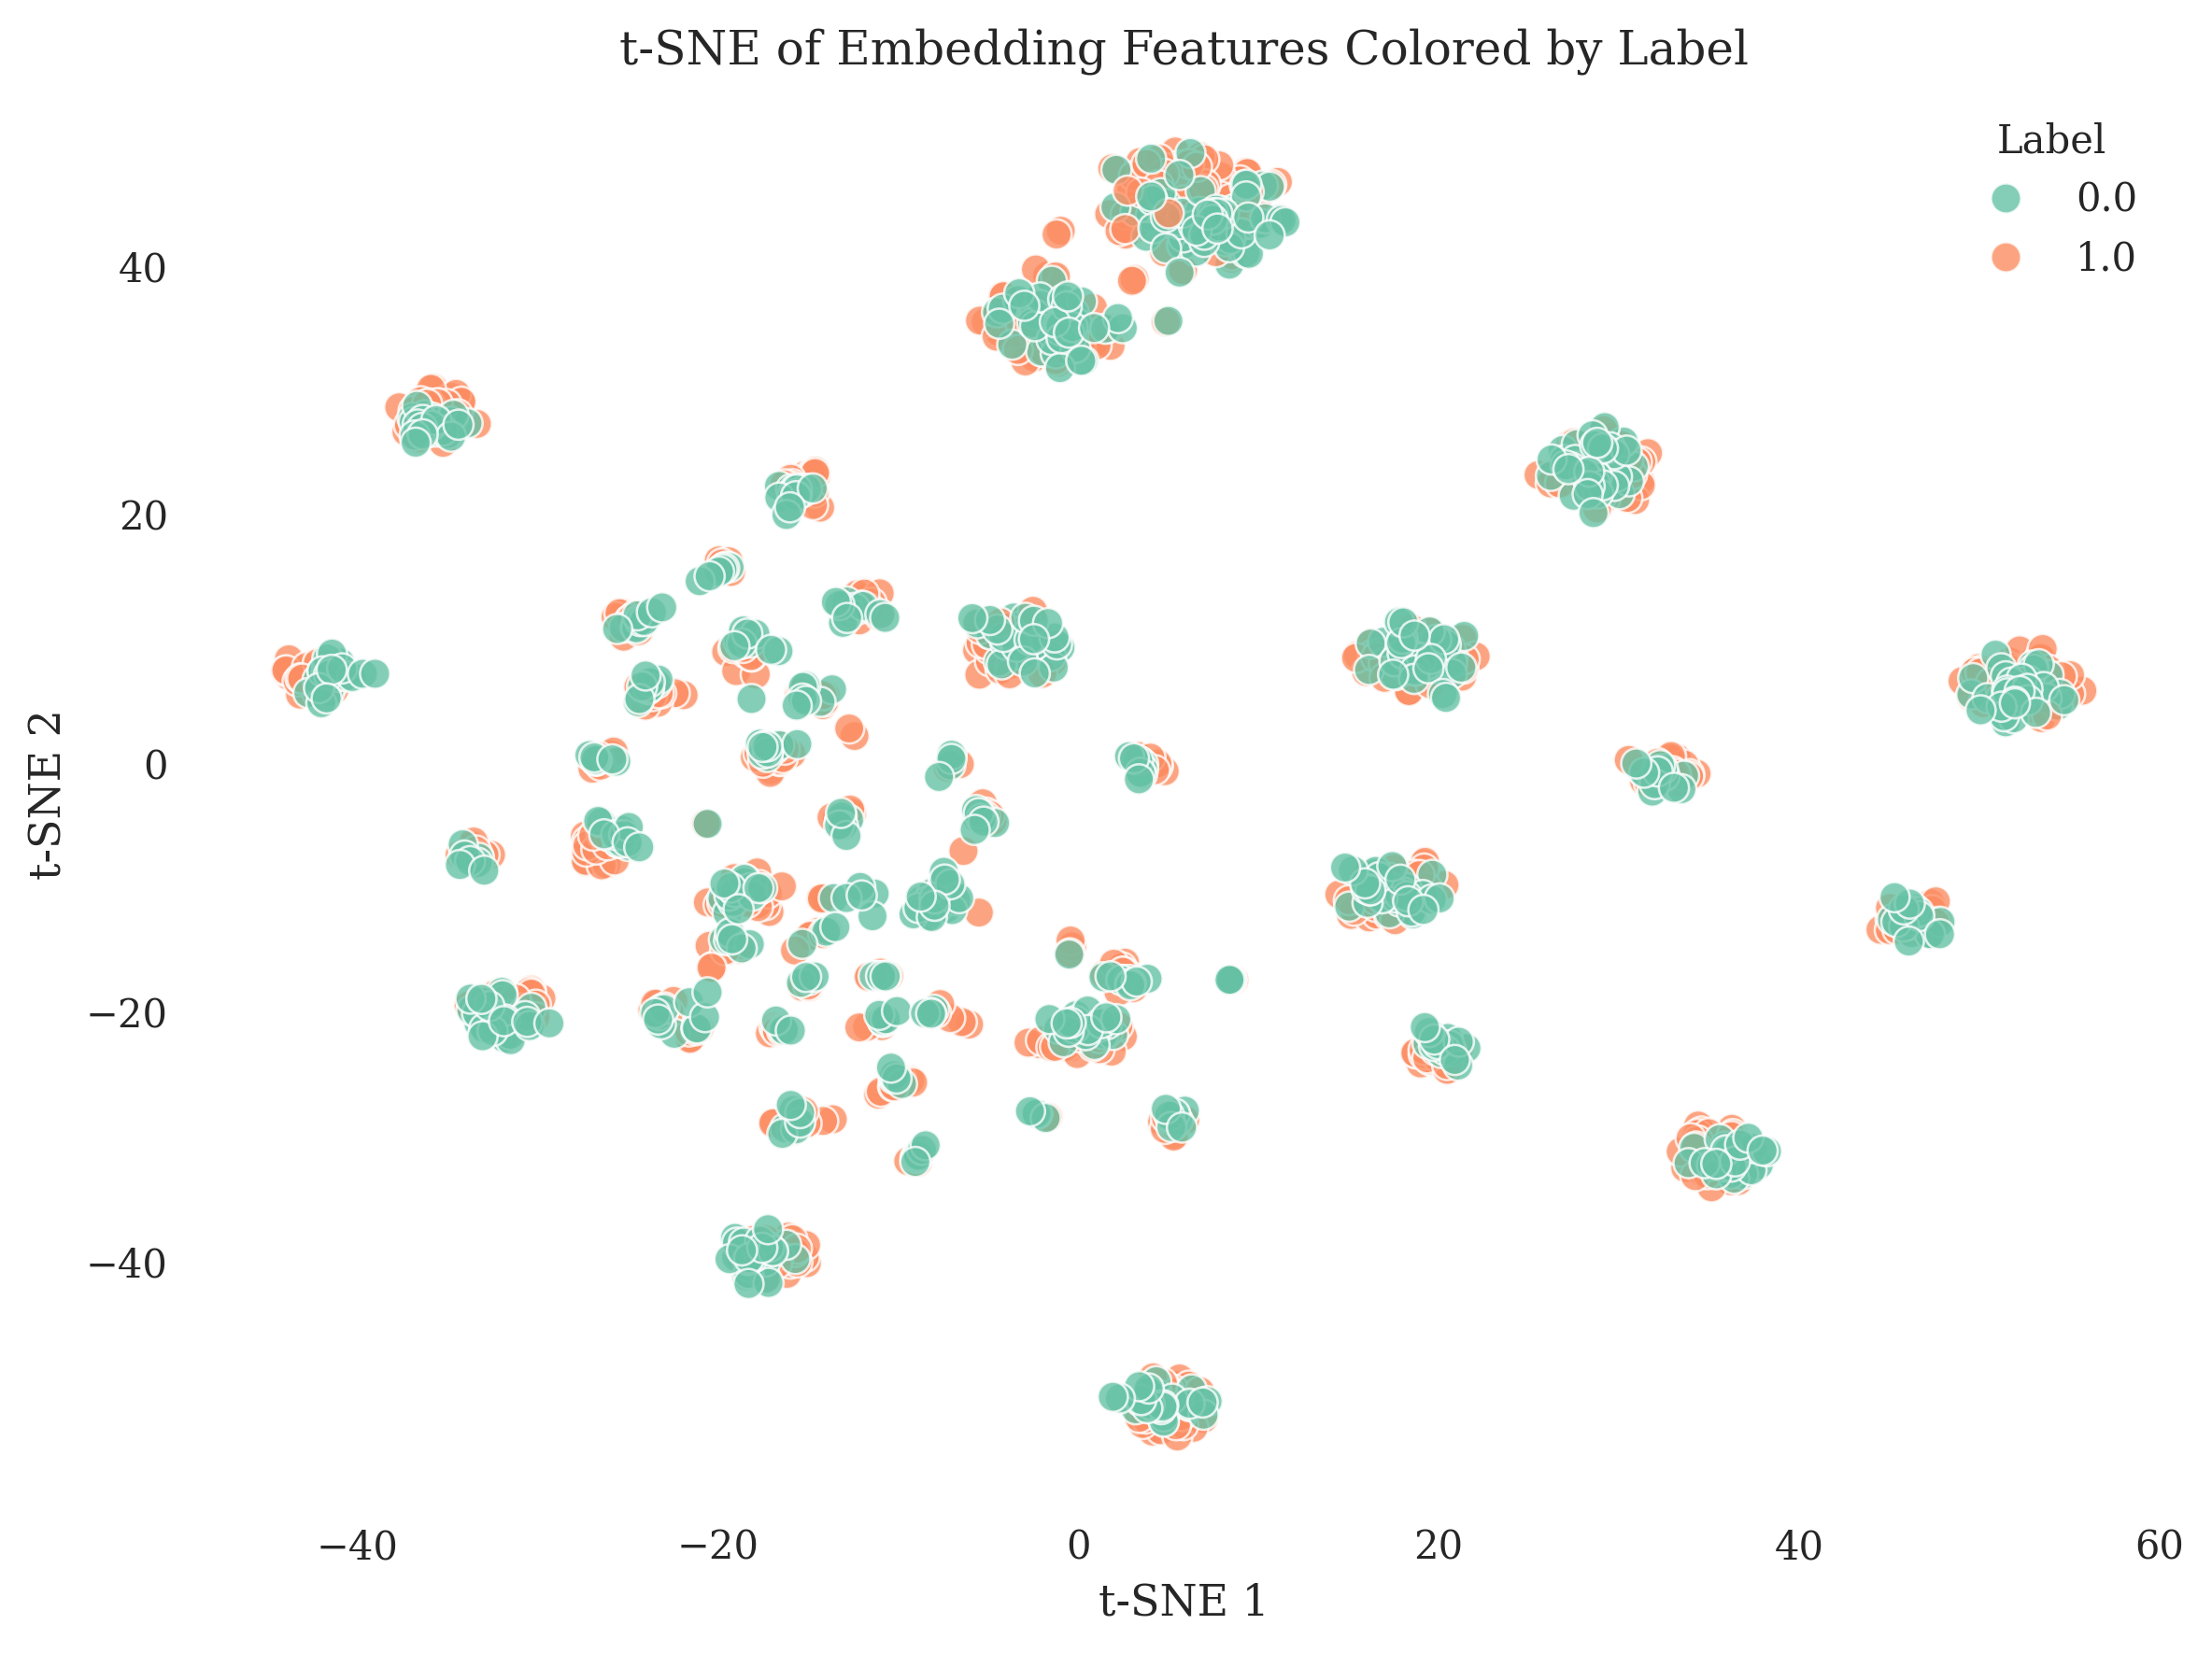

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib as mpl
import seaborn as sns
plt.style.use('default')  # Use default style instead of seaborn
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300  # Higher resolution
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.figsize'] = (10, 10)  # Slightly larger figure
mpl.rcParams['path.simplify'] = True
mpl.rcParams['path.simplify_threshold'] = 1.0
mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
plt.rcParams["font.family"] = "serif"
# 使用 t-SNE 做降維
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
features_2d = tsne.fit_transform(features_np)

plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=features_2d[:, 0], y=features_2d[:, 1],
    hue=labels_np,
    palette='Set2', s=60, alpha=0.8)
plt.title("t-SNE of Embedding Features", fontsize=16,fontweight="bold")
plt.xlabel("t-SNE 1", fontsize=16,fontweight="bold")
plt.ylabel("t-SNE 2", fontsize=16,fontweight="bold")
leg = plt.legend(title="Label", fontsize=13, title_fontsize=14)
plt.setp(leg.get_title(), weight='bold')
plt.tight_layout()
plt.show()

In [35]:
print(np.concatenate(predAUCwithUnknownGT).shape)
print(test_df.shape)
test_df['predict_value'] = np.concatenate(predAUCwithUnknownGT)
test_df

(1586,)
(1586, 7)


drug_name  Label drug_name_normalized          mapped_name  \
2559          epothilone b      1          epothiloneb         epothilone b   
16986            docetaxel      1            docetaxel            docetaxel   
52              bortezomib      1           bortezomib           bortezomib   
2427          epothilone b      1          epothiloneb         epothilone b   
3190             docetaxel      1            docetaxel            docetaxel   
...                    ...    ...                  ...                  ...   
15745  aica ribonucleotide      0                aicar  aica ribonucleotide   
2344            phenformin      0           phenformin           phenformin   
14444           phenformin      0           phenformin           phenformin   
2668            phenformin      0           phenformin           phenformin   
10356           phenformin      0           phenformin           phenformin   

       lnIC50          primary_disease     ModelID  predict_value  
2559    -8.92             Liver Cancer  ACH-000221       0.913835  
16986   -8.92                  Sarcoma  ACH-001715       0.935252  
52      -8.61              Skin Cancer  ACH-000008       0.855526  
2427    -7.84              Skin Cancer  ACH-000219       0.957427  
3190    -7.83             Brain Cancer  ACH-000273       0.889692  
...       ...                      ...         ...            ...  
15745    9.25          Cervical Cancer  ACH-001333       0.008449  
2344     9.52             Liver Cancer  ACH-000217       0.076139  
14444    9.59  Colon/Colorectal Cancer  ACH-000957       0.145353  
2668     9.81        Pancreatic Cancer  ACH-000235       0.010655  
10356    9.84           Bladder Cancer  ACH-000720       0.113737  

[1586 rows x 8 columns]

In [161]:
%%time
# inference
set_seed(seed)
def collate_fn(batch):
        gene_feature, drug_list, target = zip(*batch)
        return list(gene_feature), list(drug_list), list(target)
all_dataset = InstanceResponseDataset(AUC_df, omics_data_dict, drug_df, drug_graph, include_omics, device)
all_loader = DataLoader(all_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn) #, num_workers=4, pin_memory=True

(eval_targets, eval_outputs,predAUCwithUnknownGT, 
AttenScorMat_DrugSelf,AttenScorMat_DrugCellSelf,
eval_outputs_before_final_activation_list, 
 mean_batch_eval_loss_WO_penalty)= evaluation(model, None,None,
                                             criterion, all_loader, device,ESPF,Drug_SelfAttention, 
                                             weighted_threshold, few_weight, more_weight, 
                                             outputcontrol='inference')

KeyboardInterrupt: 

In [36]:
print(np.concatenate(predAUCwithUnknownGT).shape)
print(torch.cat(eval_outputs).shape)
print(torch.cat(eval_targets).shape)

(1586,)
torch.Size([1586])
torch.Size([1586])


In [37]:
best_prob_threshold

0.5791569948196411

In [38]:
print(torch.cat(eval_outputs)[:10])
print(torch.cat(eval_targets)[:10])

tensor([0.9138, 0.9353, 0.8555, 0.9574, 0.8897, 0.9822, 0.1102, 0.9363, 0.9919,
        0.8064], device='cuda:0')
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')


In [64]:
print(np.concatenate(predAUCwithUnknownGT).shape)
AUC_df = AUC_df.copy() 
# predAUCmatrix = predAUCwithUnknownGT_list.reshape(476, 1440) # numpy.ndarray
AUC_df['predict_value'] = np.concatenate(predAUCwithUnknownGT)
AUC_df

(189038,)


cell_type           drug_name Label_bi  Unnamed: 0  COSMIC_ID  drug_id  \
136703   OVCAR-3            AS605240        R      127729     905933      224   
182557   OVCAR-3  AKT inhibitor VIII        S      127790     905933      171   
105176   OVCAR-3             AZD6482        S      127778     905933     1066   
105898   OVCAR-3             AZD6482        S      127792     905933      156   
145719   OVCAR-3             AZD6482        S      127792     905933      156   
...          ...                 ...      ...         ...        ...      ...   
174291    CAL-72              AUY922        R       98345     906827      194   
55039     CAL-72          Tipifarnib        R       98332     906827      204   
169907    CAL-72           SL 0101-1        S       98392     906827     1039   
9453      CAL-72           OSU-03012        R       98329     906827      167   
52709     CAL-72          CHIR-99021        S       98294     906827     1241   

        lnIC50                                             smiles  \
136703    5.18                  O=C1NC(=O)/C(=C/c2ccc3nccnc3c2)S1   
182557    0.28  O=c1[nH]c2ccccc2n1C1CCN(Cc2ccc(-c3[nH]c4cc5ncn...   
105176    0.80  Cc1cc([C@@H](C)Nc2ccccc2C(=O)O)c2nc(N3CCOCC3)c...   
105898   -0.68  Cc1cc([C@@H](C)Nc2ccccc2C(=O)O)c2nc(N3CCOCC3)c...   
145719   -0.68  Cc1cc([C@@H](C)Nc2ccccc2C(=O)O)c2nc(N3CCOCC3)c...   
...        ...                                                ...   
174291   -1.10  CCNC(=O)c1noc(-c2cc(C(C)C)c(O)cc2O)c1-c1ccc(CN...   
55039     1.66  Cn1cncc1[C@@](N)(c1ccc(Cl)cc1)c1ccc2c(c1)c(-c1...   
169907    2.72  CC(=O)O[C@H]1[C@H](C)O[C@@H](Oc2c(-c3ccc(O)cc3...   
9453      2.97  NCC(=O)Nc1ccc(-n2nc(C(F)(F)F)cc2-c2ccc3c(ccc4c...   
52709     2.85  Cc1cnc(-c2cnc(NCCNc3ccc(C#N)cn3)nc2-c2ccc(Cl)c...   

                        assay_name   GDSC_tissue cancer_type  Label  \
136703  5500994172383112813930_E09         ovary          OV      0   
182557  5500994172383112813930_E09         ovary          OV      1   
105176  5500994172383112813930_E09         ovary          OV      1   
105898  5500994172383112813930_E09         ovary          OV      1   
145719  5500994172383112813930_E09         ovary          OV      1   
...                            ...           ...         ...    ...   
174291  5500994158987071513209_H07  osteosarcoma         NaN      0   
55039   5500994158987071513209_H07  osteosarcoma         NaN      0   
169907  5500994158987071513209_H07  osteosarcoma         NaN      1   
9453    5500994158987071513209_H07  osteosarcoma         NaN      0   
52709   5500994158987071513209_H07  osteosarcoma         NaN      1   

           ModelID  predict_value  
136703  ACH-000001       0.481772  
182557  ACH-000001       0.864117  
105176  ACH-000001       0.717422  
105898  ACH-000001       0.717422  
145719  ACH-000001       0.717422  
...            ...            ...  
174291  ACH-001715       0.364026  
55039   ACH-001715       0.347944  
169907  ACH-001715       0.688974  
9453    ACH-001715       0.250898  
52709   ACH-001715       0.882483  

[189038 rows x 14 columns]

/tmp/ipykernel_36292/3806759023.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Better default style
/tmp/ipykernel_36292/3806759023.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bce_by_cancer, x='primary_disease', y='Mean_BCE', palette='coolwarm')


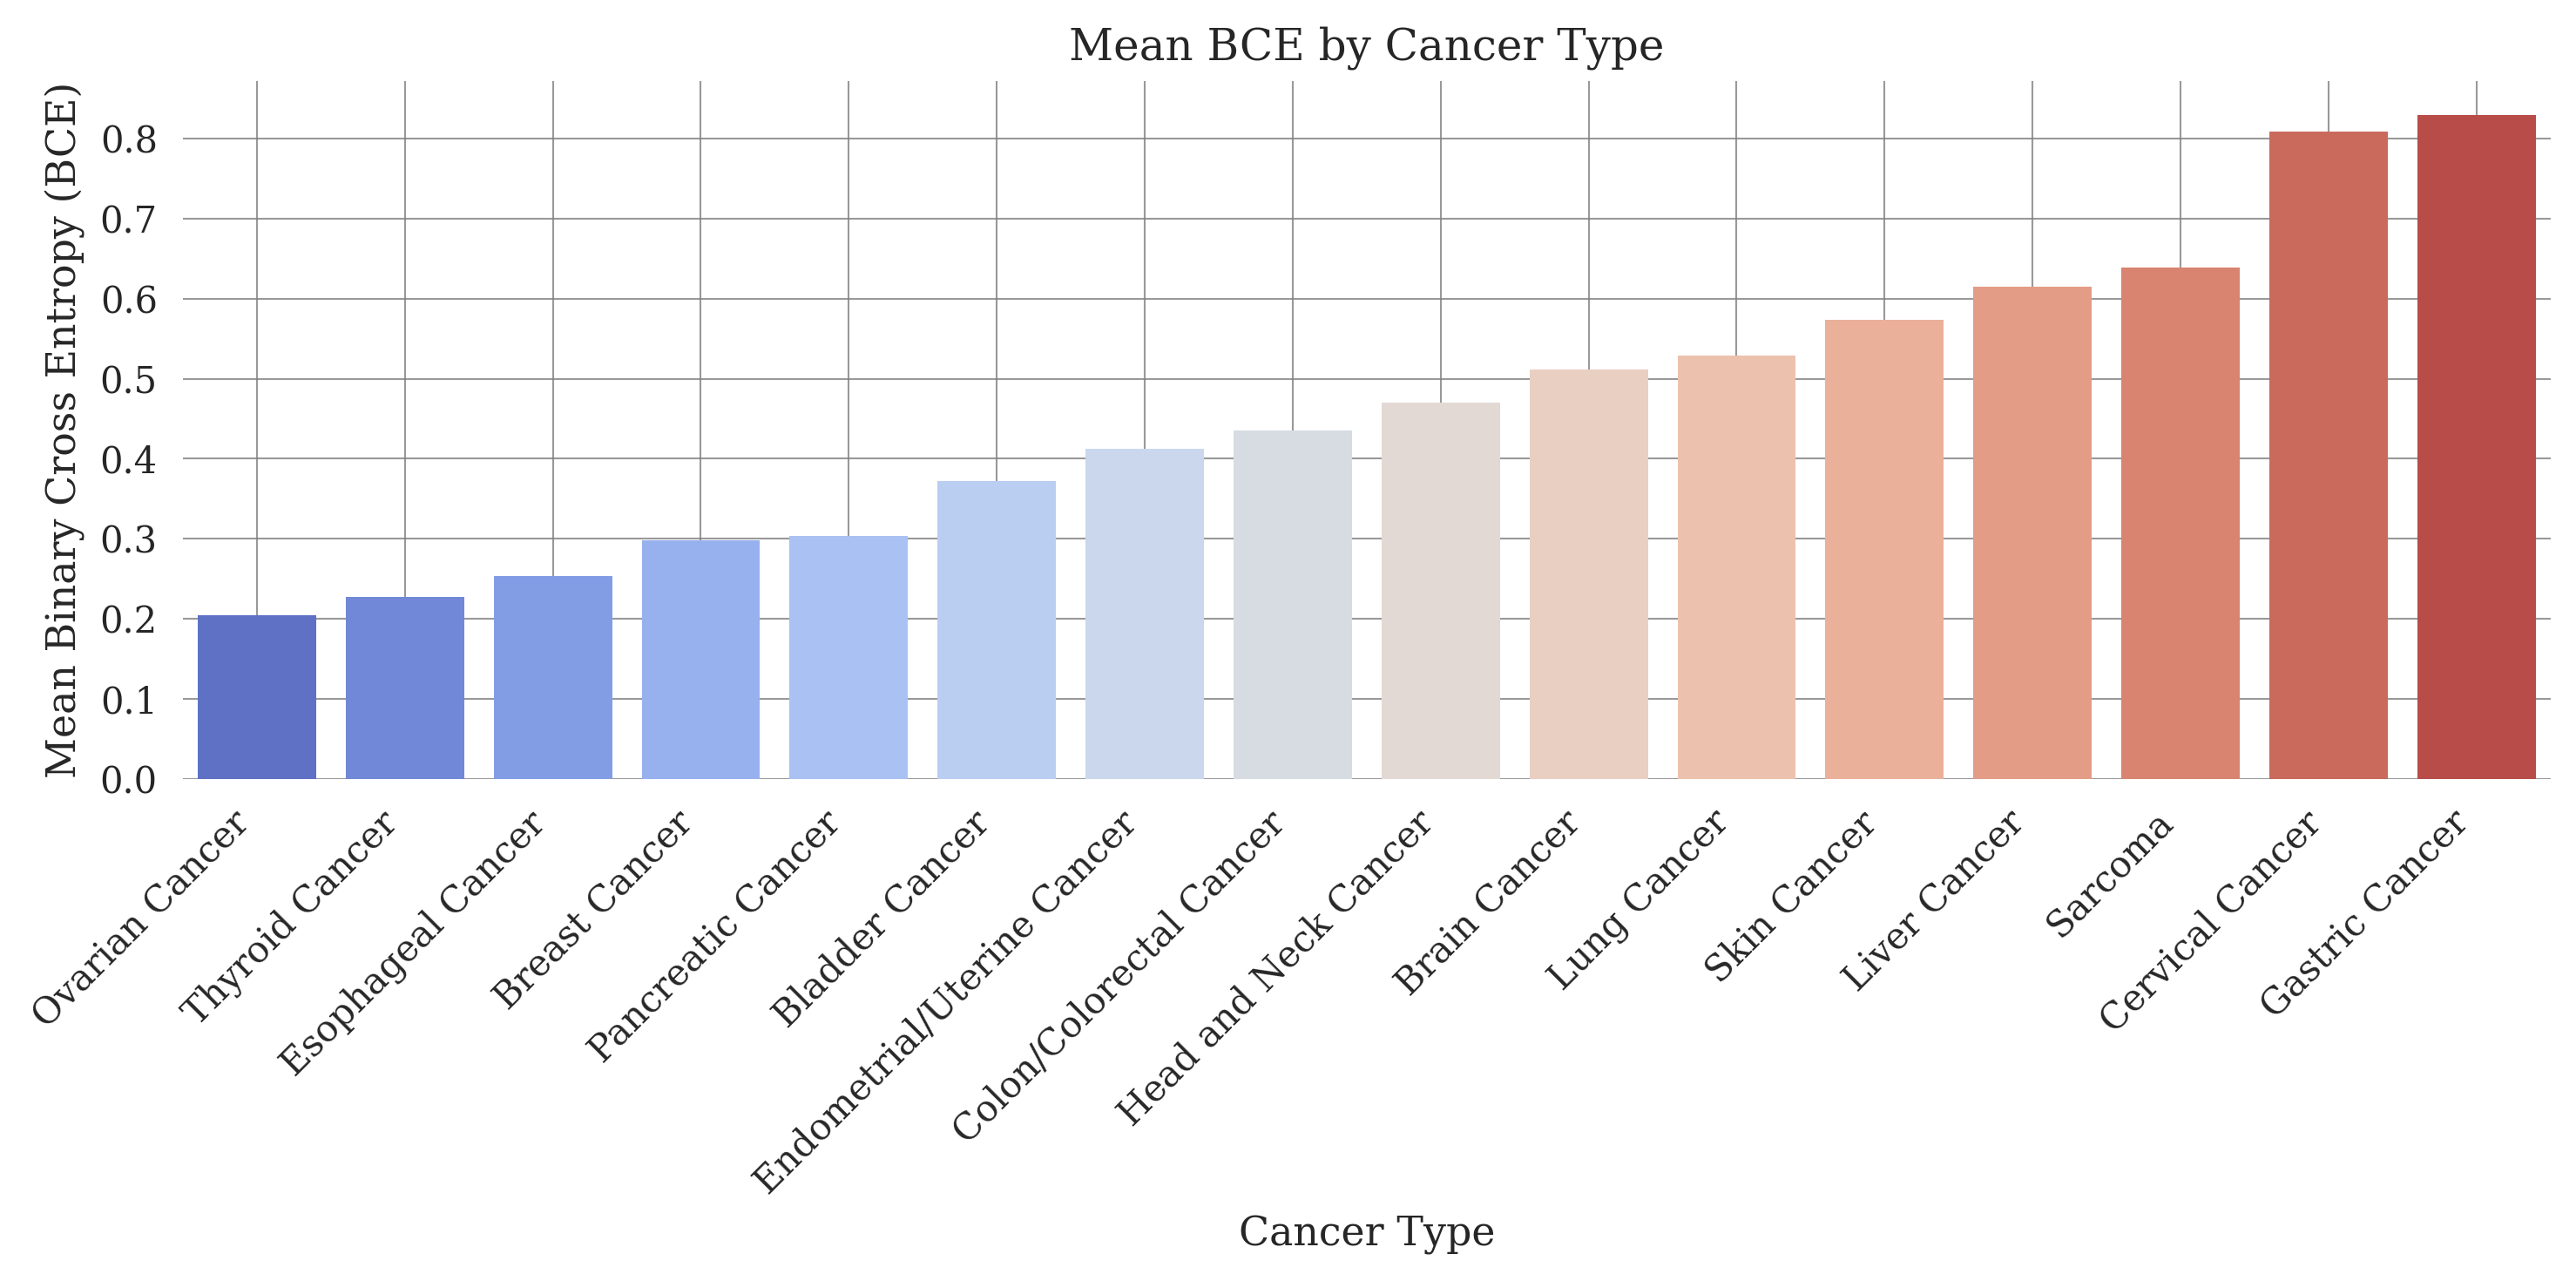

In [46]:
from sklearn.metrics import log_loss
# 先過濾掉缺失值（保險起見）
response_df = test_df.dropna(subset=['primary_disease', 'Label', 'predict_value'])
# 計算每個 primary_disease 的 mean BCE
bce_by_cancer = (
    response_df
    .groupby('primary_disease')
    .apply(lambda df: log_loss(df['Label'], df['predict_value'], labels=[0, 1]))
    .reset_index(name='Mean_BCE')
    .sort_values(by='Mean_BCE')
)
import matplotlib.font_manager as fm
import matplotlib as mpl
plt.style.use('seaborn')  # Better default style
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300  # Higher resolution
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.figsize'] = (8, 5)  # Slightly larger figure
mpl.rcParams['path.simplify'] = True
mpl.rcParams['path.simplify_threshold'] = 1.0
mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
plt.rcParams["font.family"] = "serif"

plt.figure(figsize=(10, 5))
sns.barplot(data=bce_by_cancer, x='primary_disease', y='Mean_BCE', palette='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean Binary Cross Entropy (BCE)")
plt.xlabel("Cancer Type")
plt.title("Mean BCE by Cancer Type")
plt.tight_layout()
plt.grid(True, linestyle='-', color='gray', linewidth=0.5, alpha=0.8)

plt.savefig('./results/Mean BCE by Cancer Type (Bar).png', format='png', dpi=300) 
plt.show()

/tmp/ipykernel_36292/1523102381.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Better default style


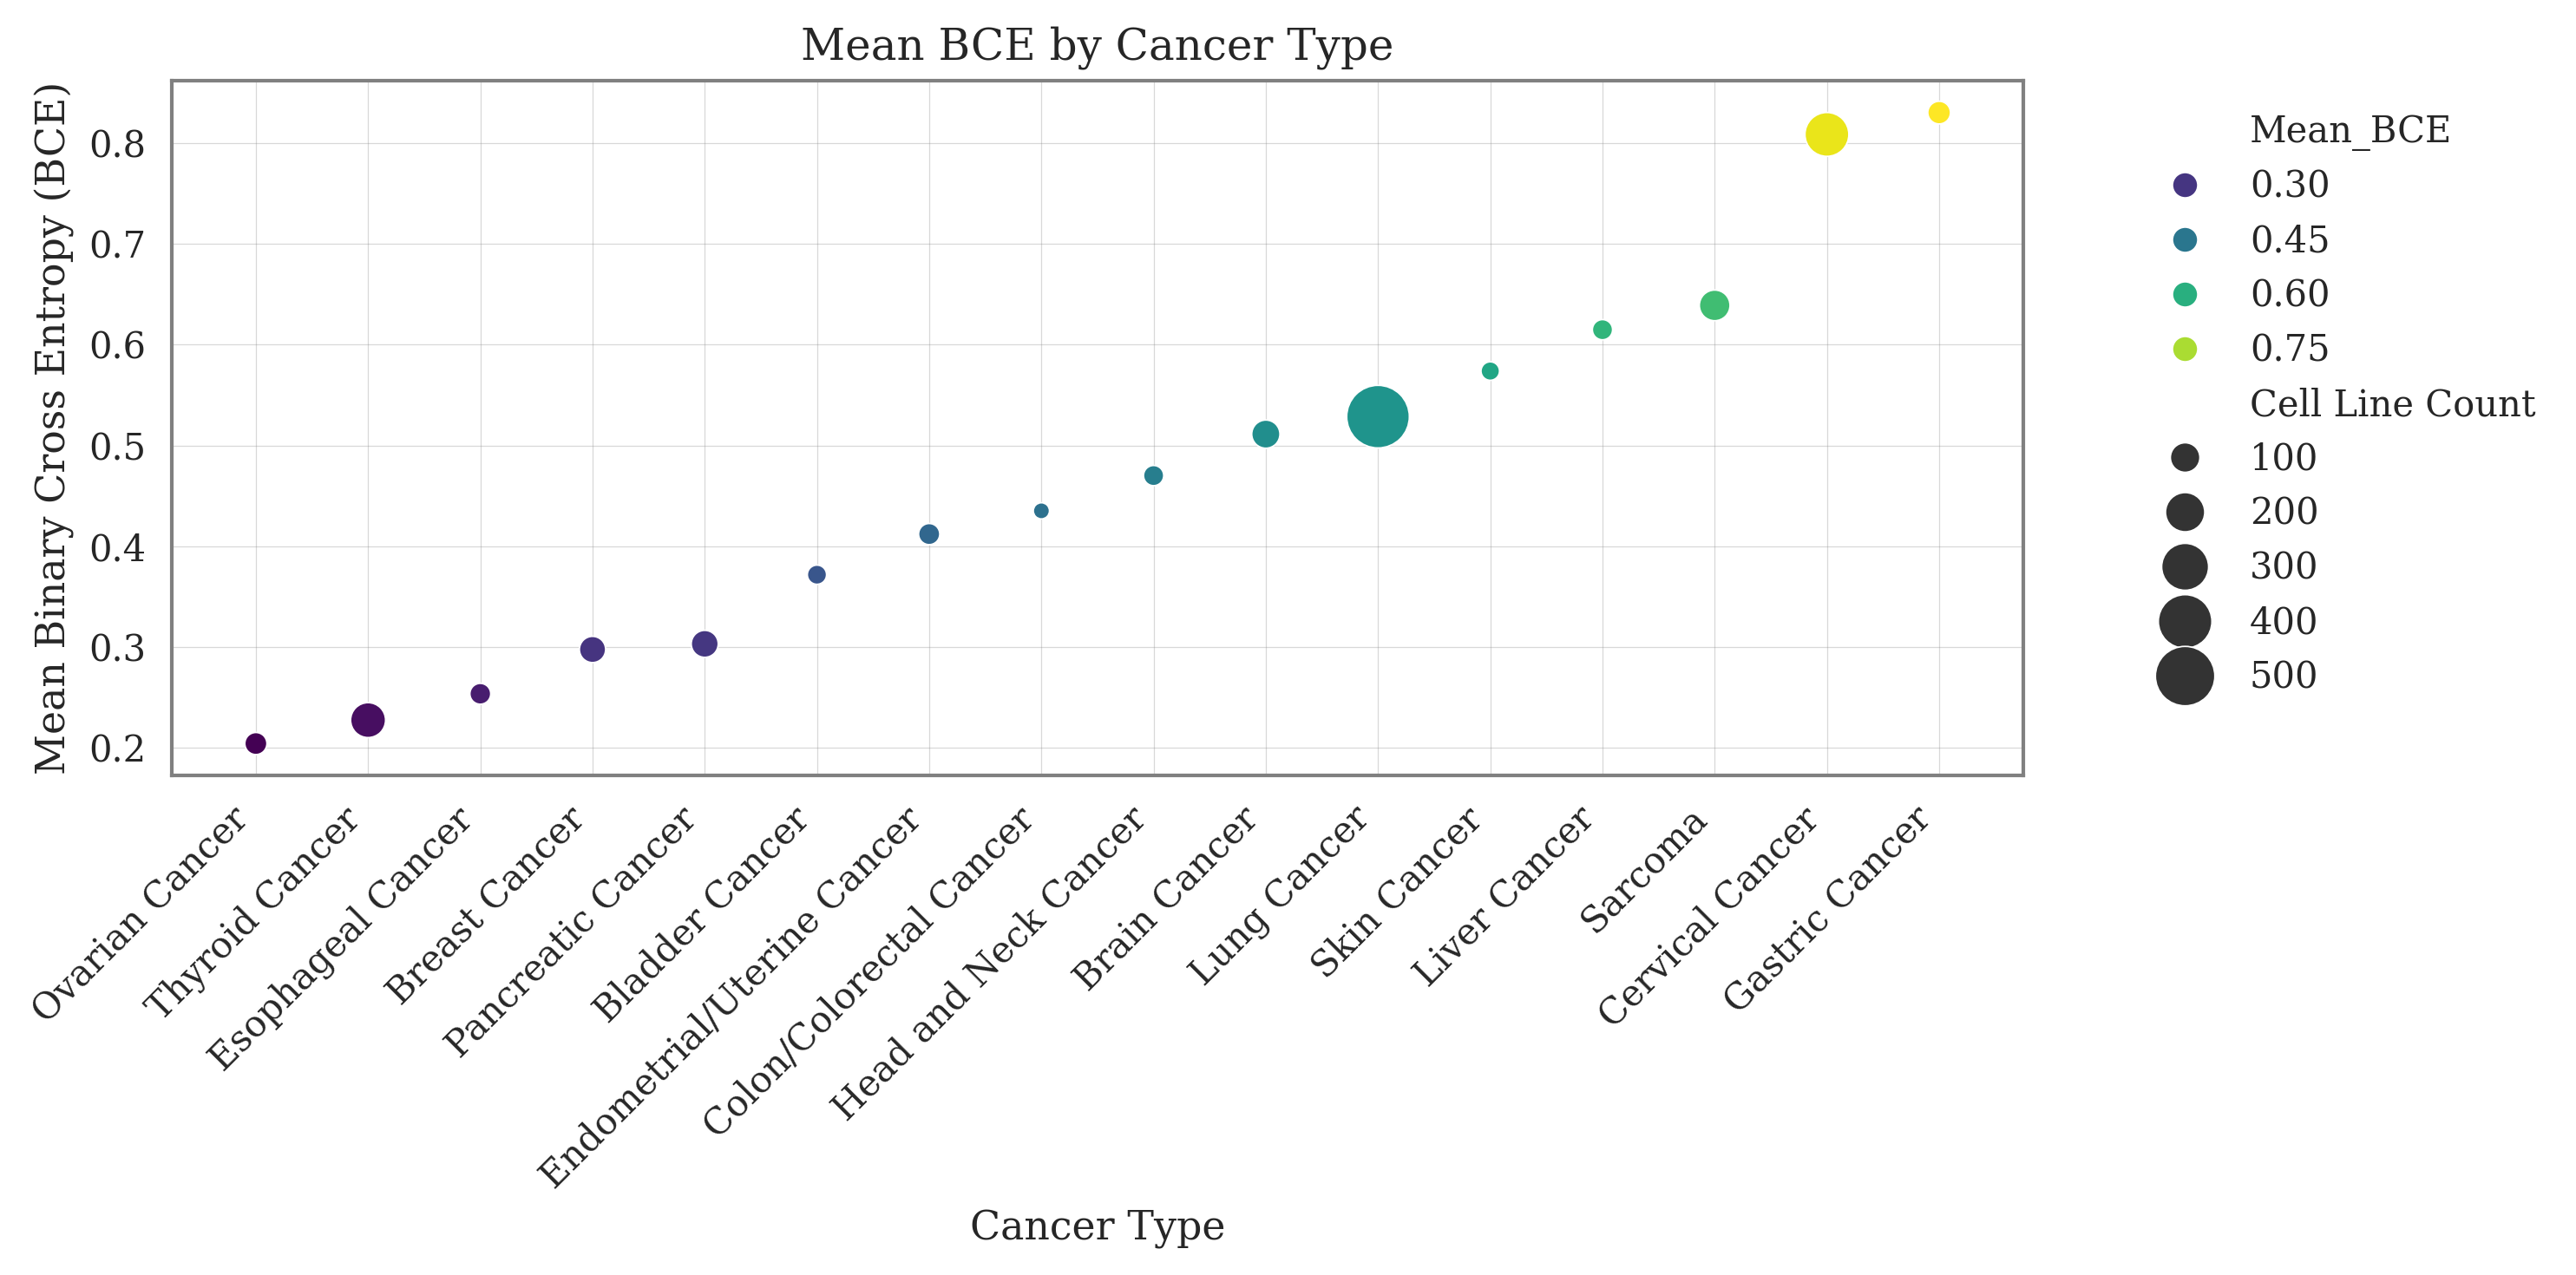

In [47]:
import matplotlib.font_manager as fm
import matplotlib as mpl
plt.style.use('seaborn')  # Better default style
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300  # Higher resolution
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.figsize'] = (8, 5)  # Slightly larger figure
mpl.rcParams['path.simplify'] = True
mpl.rcParams['path.simplify_threshold'] = 1.0
mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
plt.rcParams["font.family"] = "serif"

bce_by_cancer['Cell Line Count'] = response_df.groupby('primary_disease').size().values
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=bce_by_cancer, x='primary_disease', y='Mean_BCE',
    size='Cell Line Count', sizes=(20, 300), hue='Mean_BCE', palette='viridis', legend='brief')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean Binary Cross Entropy (BCE)")
plt.xlabel("Cancer Type")
plt.title("Mean BCE by Cancer Type")
plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, linestyle='-', color='gray', linewidth=0.3, alpha=0.3)
for spine in plt.gca().spines.values():
    spine.set_color('gray')  
    spine.set_linewidth(1)
plt.savefig('./results/Mean BCE by Cancer Type (Bubble)in testset.png', format='png', dpi=300) 
plt.show()

In [11]:
test_df

cell_type     drug_name Label_bi  Unnamed: 0  COSMIC_ID  drug_id  \
15609        HEL      BIX02189        S      122745     907053      279   
1201         HEL    Tipifarnib        S      122833     907053      204   
184358       HEL  Bryostatin 1        S      122841     907053      197   
40091        HEL      T0901317        S      122769     907053      333   
170571       HEL         GNF-2        R      122882     907053       52   
...          ...           ...      ...         ...        ...      ...   
159551       TGW    GSK429286A        S       15045     910780      230   
15479        TGW      CAY10603        R       15096     910780      276   
131414       TGW       UNC1215        R       15120     910780     1262   
106893       TGW       SGC0946        S       15121     910780     1264   
185208       TGW         AICAR        S       15210     910780     1001   

        lnIC50                                             smiles  \
15609     2.75  CN(C)Cc1cccc(N=C(c2ccccc2)c2c(O)[nH]c3cc(C(=O)...   
1201     -0.79  Cn1cncc1[C@@](N)(c1ccc(Cl)cc1)c1ccc2c(c1)c(-c1...   
184358   -4.31  CCC/C=C/C=C/C(=O)O[C@H]1/C(=C/C(=O)OC)C[C@H]2C...   
40091     2.97  O=S(=O)(c1ccccc1)N(CC(F)(F)F)c1ccc(C(O)(C(F)(F...   
170571    2.21    NC(=O)c1cccc(-c2cc(Nc3ccc(OC(F)(F)F)cc3)ncn2)c1   
...        ...                                                ...   
159551    3.00  CC1=C(C(=O)Nc2cc3cn[nH]c3cc2F)C(c2ccc(C(F)(F)F...   
15479    -0.96  CC(C)(C)OC(=O)Nc1ccc(-c2cc(C(=O)NCCCCCCC(=O)NO...   
131414    2.01  O=C(c1ccc(C(=O)N2CCC(N3CCCC3)CC2)c(Nc2ccccc2)c...   
106893    0.77  CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...   
185208    6.15  NC(=O)c1ncn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c1N   

                        assay_name              GDSC_tissue cancer_type  \
15609   5500994172383112813929_A10  acute_myeloid_leukaemia        LAML   
1201    5500994172383112813929_A10  acute_myeloid_leukaemia        LAML   
184358  5500994172383112813929_A10  acute_myeloid_leukaemia        LAML   
40091   5500994172383112813929_A10  acute_myeloid_leukaemia        LAML   
170571  5500994172383112813929_A10  acute_myeloid_leukaemia        LAML   
...                            ...                      ...         ...   
159551  5500994172948120113978_H04            neuroblastoma          NB   
15479   5500994172948120113978_H04            neuroblastoma          NB   
131414  5500994172948120113978_H04            neuroblastoma          NB   
106893  5500994172948120113978_H04            neuroblastoma          NB   
185208  5500994172948120113978_H04            neuroblastoma          NB   

        Label     ModelID  predict_value  
15609       1  ACH-000004       0.668553  
1201        1  ACH-000004       0.368039  
184358      1  ACH-000004       0.126383  
40091       1  ACH-000004       0.803510  
170571      0  ACH-000004       0.453579  
...       ...         ...            ...  
159551      1  ACH-001674       0.705689  
15479       0  ACH-001674       0.295484  
131414      0  ACH-001674       0.618928  
106893      1  ACH-001674       0.371908  
185208      1  ACH-001674       0.558721  

[18736 rows x 14 columns]

In [44]:
from scipy.stats import pearsonr, spearmanr
# 建立結果列表
corr_list = []
# 分組處理每個 ModelID
for model_id, group in test_df.groupby('ModelID'):
    if group['Label'].nunique() > 1:
        pearson_corr, _ = pearsonr(group['predict_value'], group['Label'])
        spearman_corr, _ = spearmanr(group['predict_value'], group['Label'])
    else:
        pearson_corr, spearman_corr = None, None
    corr_list.append({'ModelID': model_id, 'PearsonCorr': pearson_corr, 'SpearmanCorr': spearman_corr})
# 轉為 DataFrame
correlation_df = pd.DataFrame(corr_list)

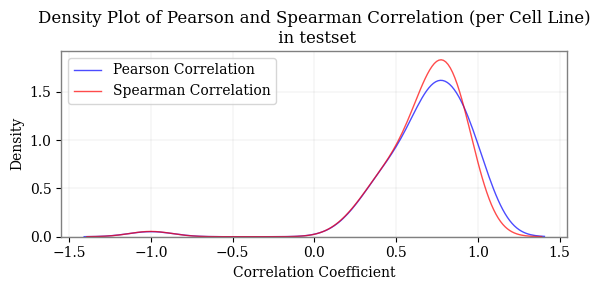

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
valid_corr_df = correlation_df.dropna(subset=['PearsonCorr', 'SpearmanCorr'])# 去除空值（None 或 NaN）
# 繪製 density plot
plt.figure(figsize=(6, 3))
sns.kdeplot(valid_corr_df['PearsonCorr'], label='Pearson Correlation',color='blue', linewidth=1,alpha=0.7 )
sns.kdeplot(valid_corr_df['SpearmanCorr'], label='Spearman Correlation',color='red', linewidth=1,alpha=0.7)

plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.title('Density Plot of Pearson and Spearman Correlation (per Cell Line)\n in testset')
plt.legend(loc='upper left')
plt.grid(True, linestyle='-', color='gray', linewidth=0.3, alpha=0.3)
for spine in plt.gca().spines.values(): # remove the boundary/frame of the plot 
    spine.set_color('gray')      # Set spine color to gray
    spine.set_linewidth(1)
plt.tight_layout()
plt.savefig('./results/Correlation Dendity plot per cell line in testset.png', format='png', dpi=300) 
plt.show()

In [41]:
from scipy.stats import pearsonr, spearmanr
import pandas as pd
correlation_info = []# 儲存結果
# 分群處理
for model_id, group in test_df.groupby('ModelID'):
    if len(group['predict_value'].unique()) > 1 and len(group['Label'].unique()) > 1:
        pearson_corr, _ = pearsonr(group['predict_value'], group['Label'])
        spearman_corr, _ = spearmanr(group['predict_value'], group['Label'])
    else:
        pearson_corr, spearman_corr = float('nan'), float('nan')
    
    cancer_type = group['primary_disease'].iloc[0]
    correlation_info.append({ 'ModelID': model_id,  'primary_disease': cancer_type,
                          'PearsonCorr': pearson_corr,'SpearmanCorr': spearman_corr    })
# 建立 DataFrame
correlation_df = pd.DataFrame(correlation_info)
# 篩選低相關（例如 Pearson < 0.2）
low_corr_df = correlation_df[correlation_df['PearsonCorr'] < 0.2]
# 查看這些 ModelID 屬於哪些 primary_disease
low_corr_counts = low_corr_df['primary_disease'].value_counts()
print(low_corr_counts)

primary_disease
Head and Neck Cancer    1
Name: count, dtype: int64


In [42]:
corr_plot_df = test_df[['ModelID', 'primary_disease']].drop_duplicates().copy()
corr_plot_df = corr_plot_df.merge(correlation_df[['ModelID', 'PearsonCorr']], on='ModelID', how='left')
corr_plot_df = corr_plot_df.merge(correlation_df[['ModelID', 'SpearmanCorr']], on='ModelID', how='left')
corr_plot_df
# 繪製 dot plot：primary_disease 為橫軸，correlation 為縱軸
plt.figure(figsize=(10, 5))
sns.stripplot(data=corr_plot_df, x='primary_disease', y='PearsonCorr', jitter=True,size=10, hue ='PearsonCorr')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Pearson Correlation')
plt.title('Distribution of Pearson Correlation across Cancer Types')
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

In [34]:
sample_counts = test_df['ModelID'].value_counts().rename('SampleCount')
corr_plot_df = corr_plot_df.merge(sample_counts, left_on='ModelID', right_index=True)
# 排序癌別順序
cancer_order = corr_plot_df['primary_disease'].value_counts().index.tolist()
cancer_to_x = {cancer: i for i, cancer in enumerate(cancer_order)}
x_vals = corr_plot_df['primary_disease'].map(cancer_to_x)
# 畫圖
plt.figure(figsize=(13, 5))
sc = plt.scatter(
    x_vals, corr_plot_df['PearsonCorr'],
    c=corr_plot_df['PearsonCorr'],               # 顏色：以 correlation 上色
    cmap='coolwarm',
    s=corr_plot_df['SampleCount_x']*0.8,          # 大小：樣本數 * 10（可依需求調整）
    alpha=0.7,    edgecolor='k')
plt.colorbar(sc, label='')
plt.xticks(ticks=range(len(cancer_order)), labels=cancer_order, rotation=45, ha='right')
plt.ylabel('Pearson Correlation')
plt.title('Pearson Correlation per Cancer Type in testset (Dot Size = Sample Count)')
plt.tight_layout()
plt.grid(True, linestyle='-', color='gray', linewidth=0.3, alpha=0.3)
for size in [50, 100, 300]:
    plt.scatter([], [], c='gray', alpha=0.6, s=size * 0.8, label=f'{size} samples', edgecolors='k')
plt.legend(
    scatterpoints=1, frameon=True, labelspacing=1, title='Sample Count',
    loc='center left', bbox_to_anchor=(1.12, 0.5), borderaxespad=0)
plt.savefig('./results/Pearson Correlation per Cancer Typ in testset.png', format='png', dpi=300)  # High-res raster
plt.show()

In [35]:
import matplotlib.font_manager as fm
import matplotlib as mpl

# Set up high-quality rendering
plt.style.use('seaborn')  # Better default style
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300  # Higher resolution
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.figsize'] = (8, 5)  # Slightly larger figure
mpl.rcParams['path.simplify'] = True
mpl.rcParams['path.simplify_threshold'] = 1.0
mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
plt.rcParams["font.family"] = "serif"

cancer_counts = test_df['primary_disease'].value_counts()
cancer_counts_df = cancer_counts.reset_index()
cancer_counts_df.columns = ['primary_disease', 'SampleCount']
# 畫條形圖
plt.figure(figsize=(8, 5))
bars = plt.bar(cancer_counts_df['primary_disease'], cancer_counts_df['SampleCount'], color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.xlabel('Cancer Type', fontweight="bold")
plt.ylabel('Number of Samples', fontweight="bold")
plt.title('Number of Samples per Cancer Type in Test Set')
plt.tight_layout()
plt.grid(True, linestyle='-', color='gray', linewidth=0.3, alpha=0.3)
for spine in plt.gca().spines.values():
    spine.set_color('gray')  
    spine.set_linewidth(1)
plt.show()

/tmp/ipykernel_6470/1370746851.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Better default style


In [37]:
test_df['primary_disease'].value_counts().sum()

8389

✅ Set read-only permissions on: ./inference/2025-0806-1354_BF1_BCE_test_loss0.5210846_BestValEpo121_filedown_Omics_DrugESPF_Model_ModelID_ESPFFalse_DrugSelfAttenFalse_Exp1426_nlayer1_DA-None/None-Test Confusion_Matrix.png


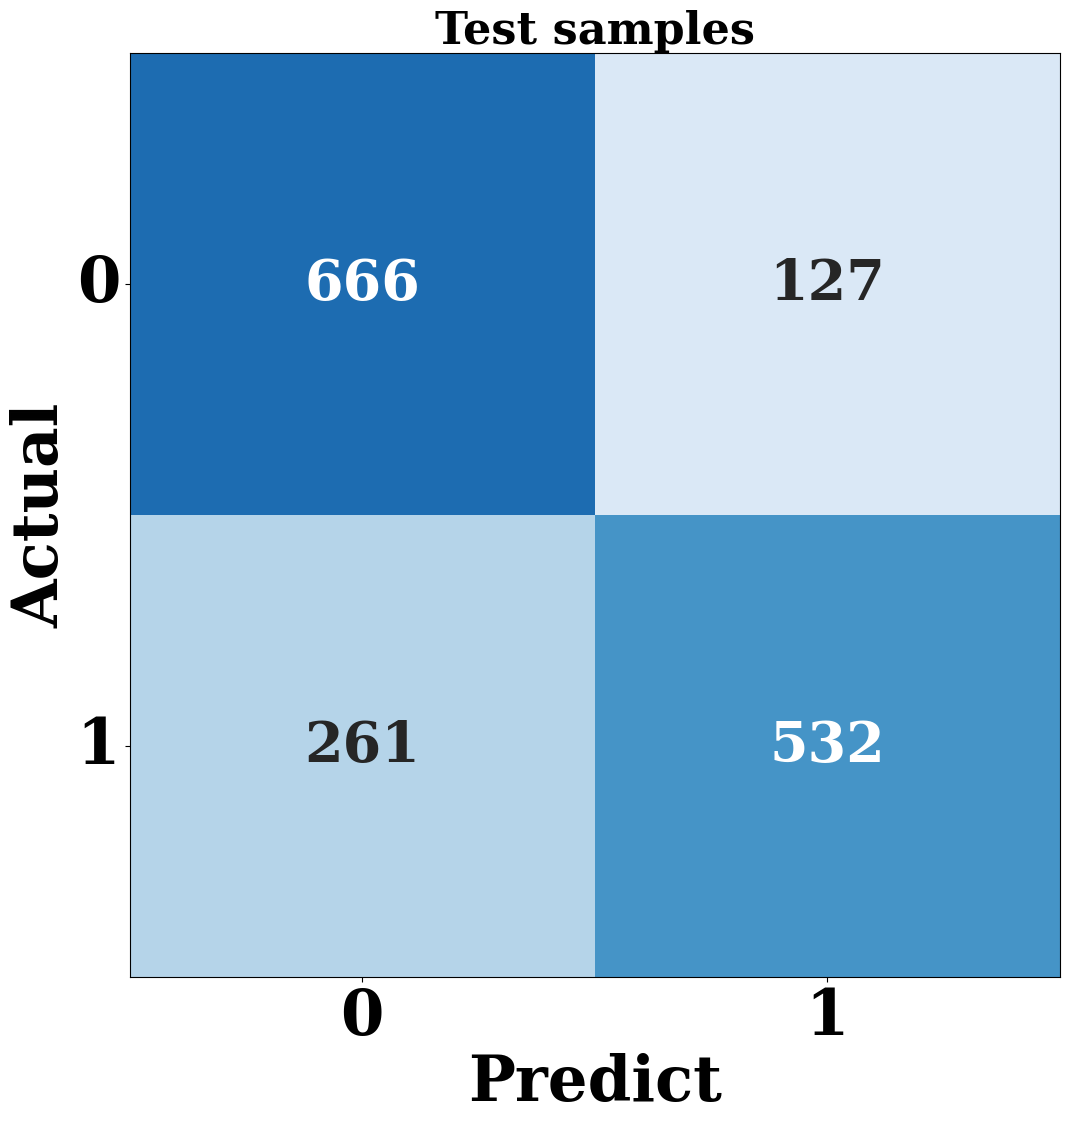

In [39]:
if 'BCE' in criterion.loss_type :
    (test_cm ,  test_GT_0_count, test_GT_1_count, 
    test_pred_binary_0_count, test_pred_binary_1_count ) =metrics_calculator.confusion_matrix(torch.cat(eval_targets), torch.cat(eval_outputs),best_prob_threshold )

    # plot confusion matrix
    cm_datas = [ (test_cm, 'Test', 'Blues')]
    Confusion_Matrix_plot(cm_datas,hyperparameter_folder_path=best_weight_path)

TCGAexp cisplatindata (40, 1426)
label_df cisplatindata (40, 3)
Exp num_features 1426
           DRUG_NAME     PATHWAY_NAME  \
name                                    
cisplatin  cisplatin  DNA replication   

                                                    synonyms     pathway_name  \
name                                                                            
cisplatin  cis-Diammineplatinum(II) dichloride, Platinol,...  DNA replication   

                    target  pubchem Dataset       name  \
name                                                     
cisplatin  DNA crosslinker  84691.0   GDSC2  cisplatin   

                           SMILES  \
name                                
cisplatin  N.N.[Cl-].[Cl-].[Pt+2]   

                                                MACCS166bits  
name                                                          
cisplatin  0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0...  
num_ccl,num_drug:  40 1

 MACCS166 is applied 

✅ Set read-only permis

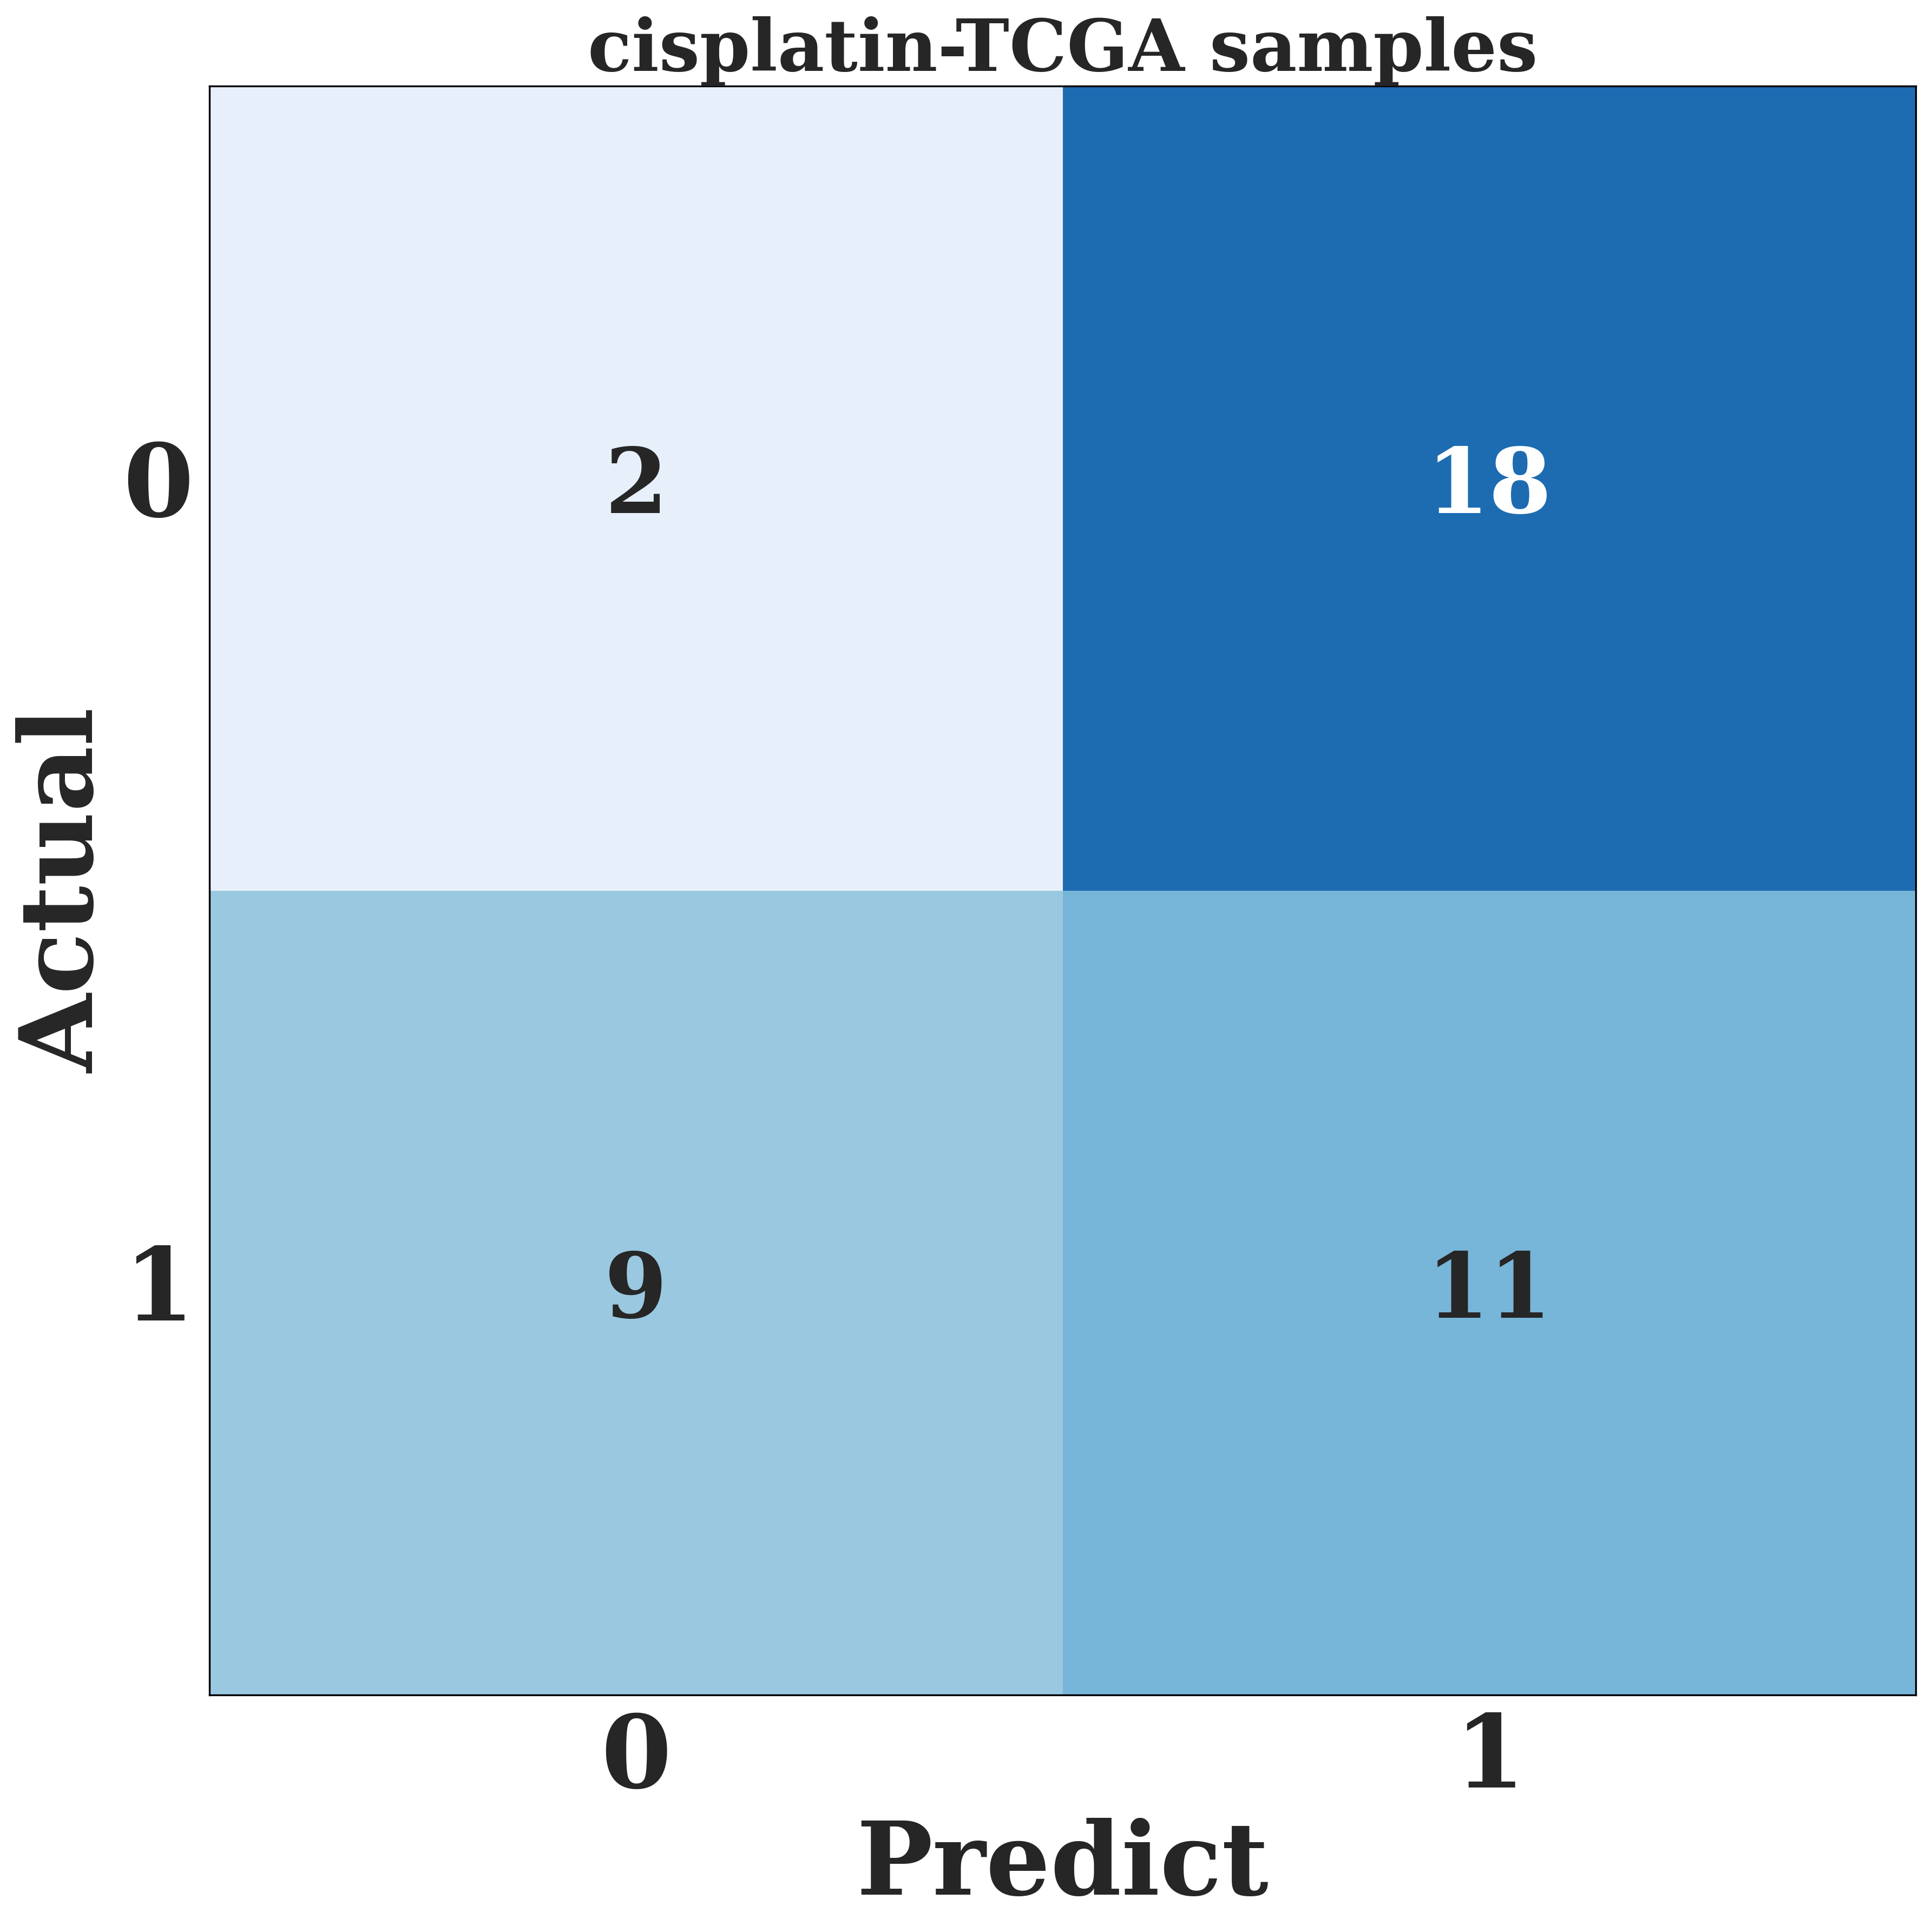

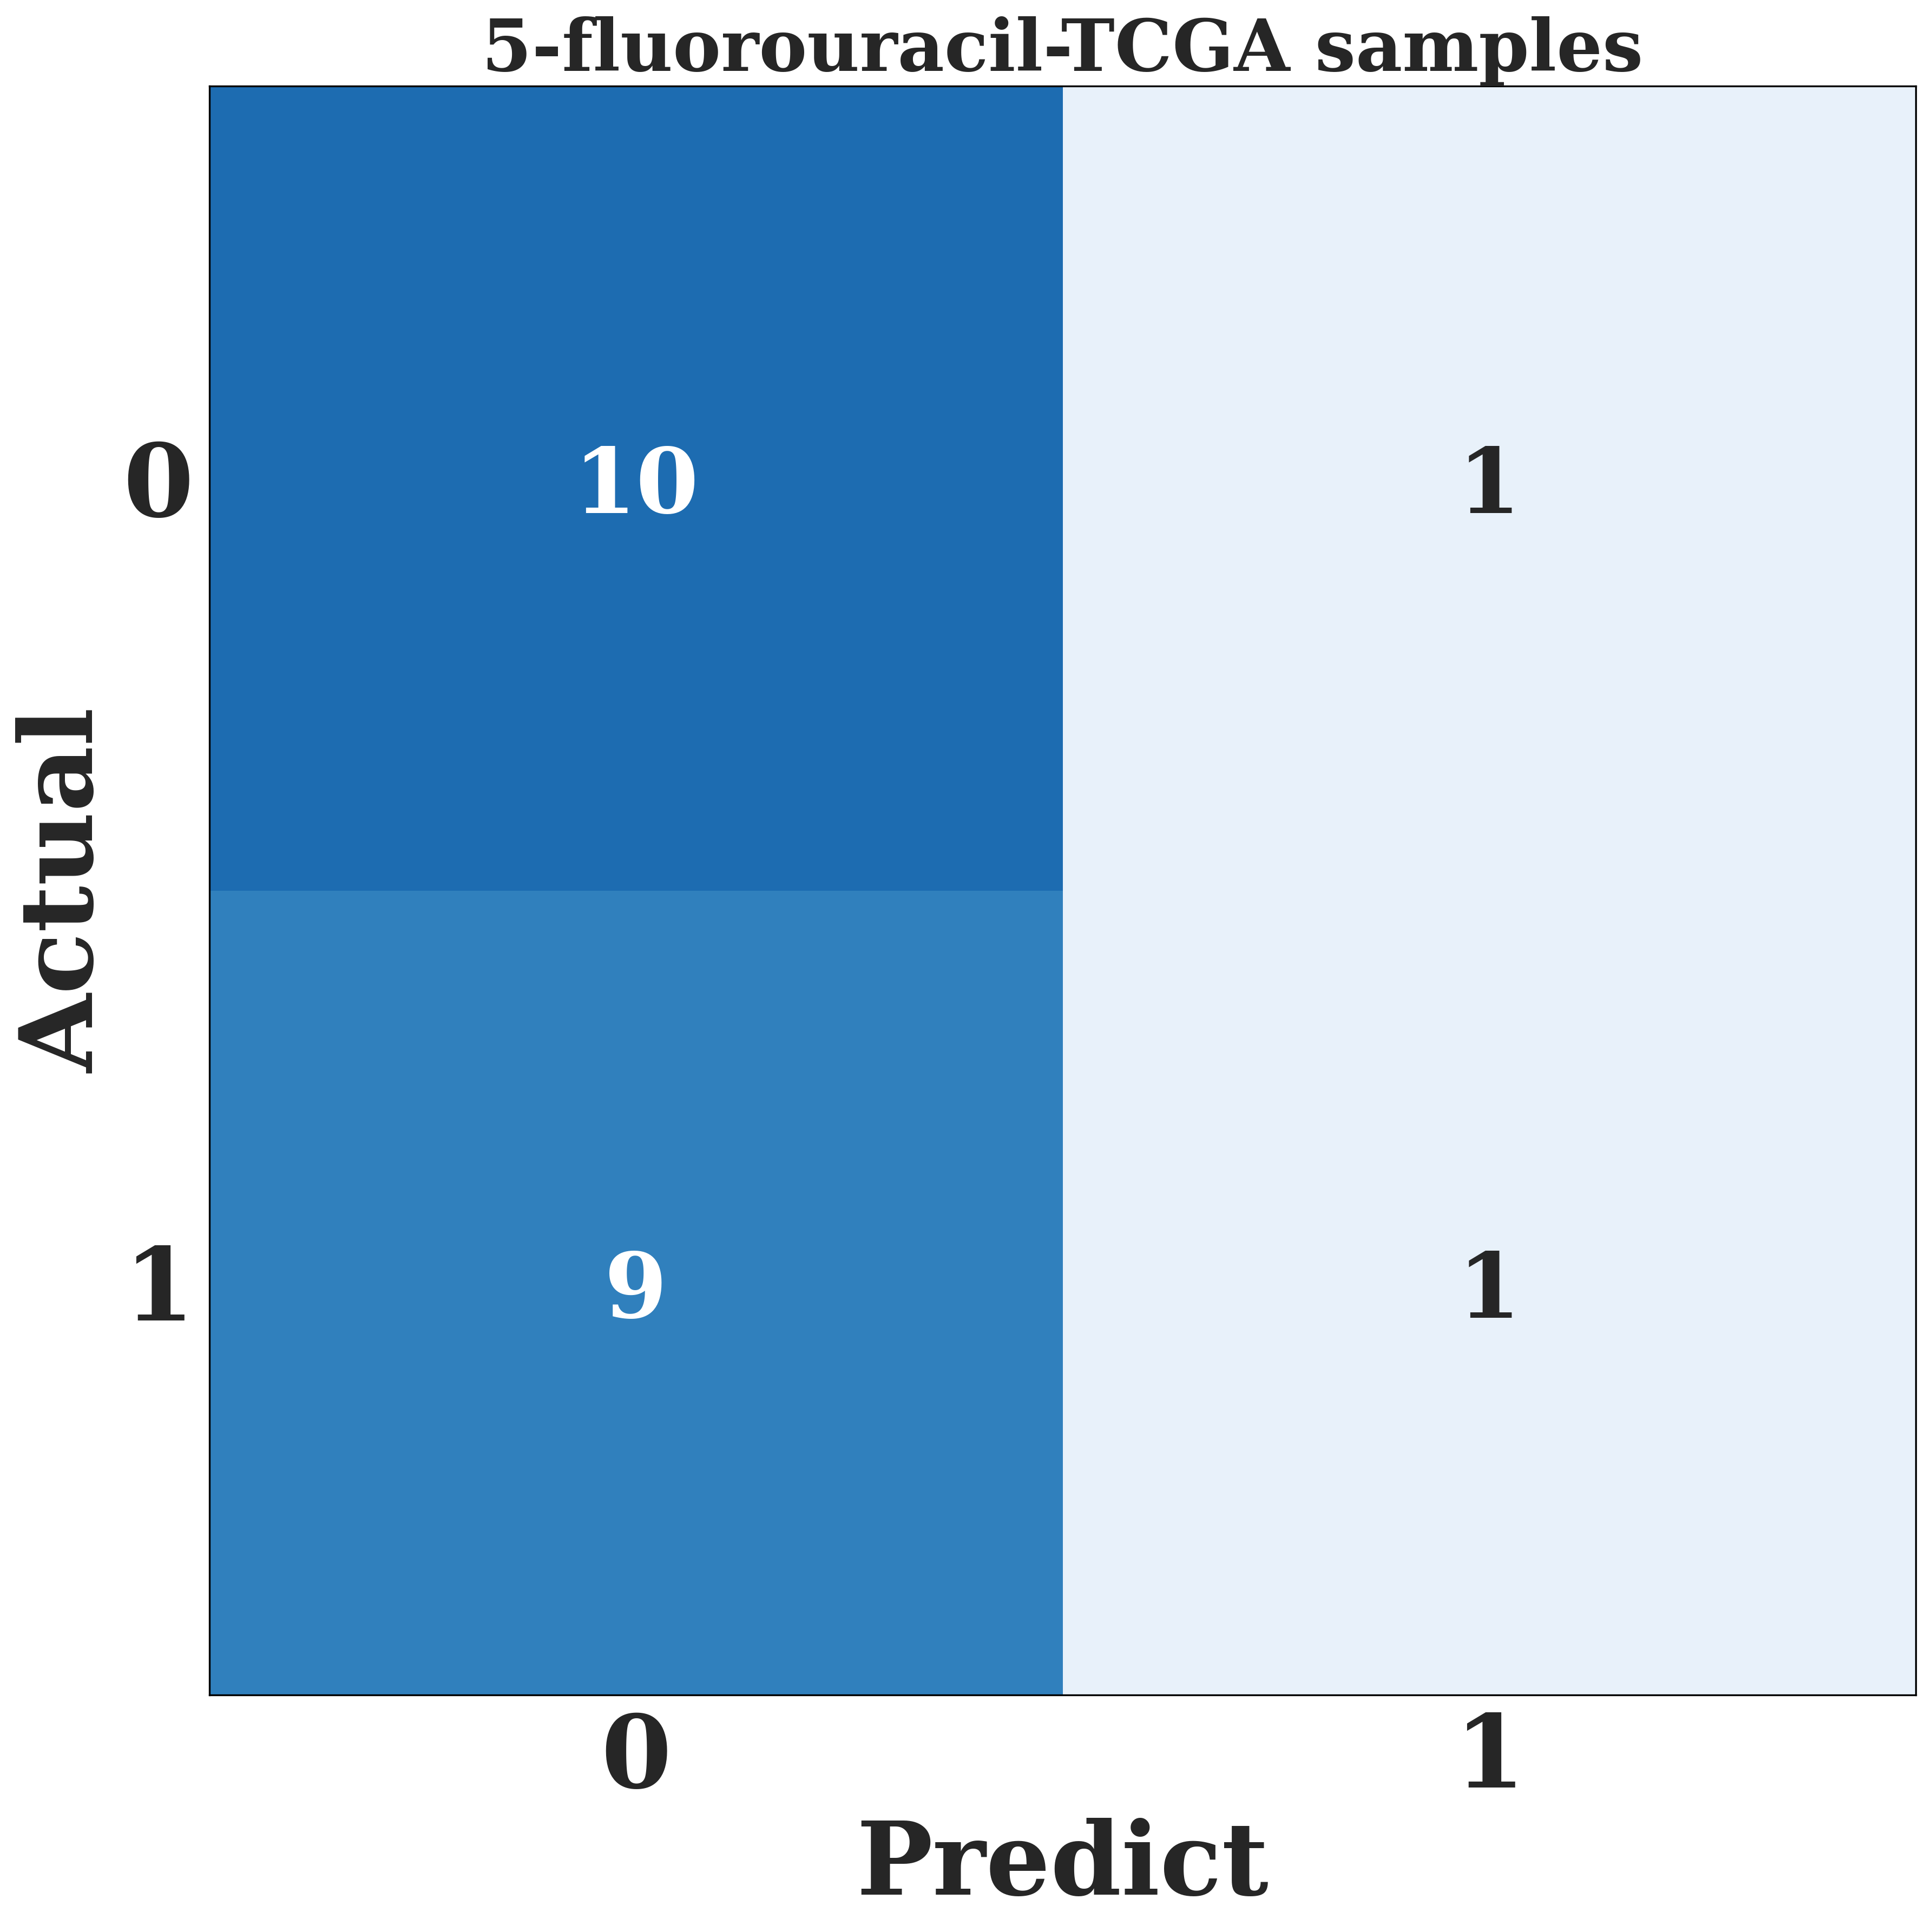

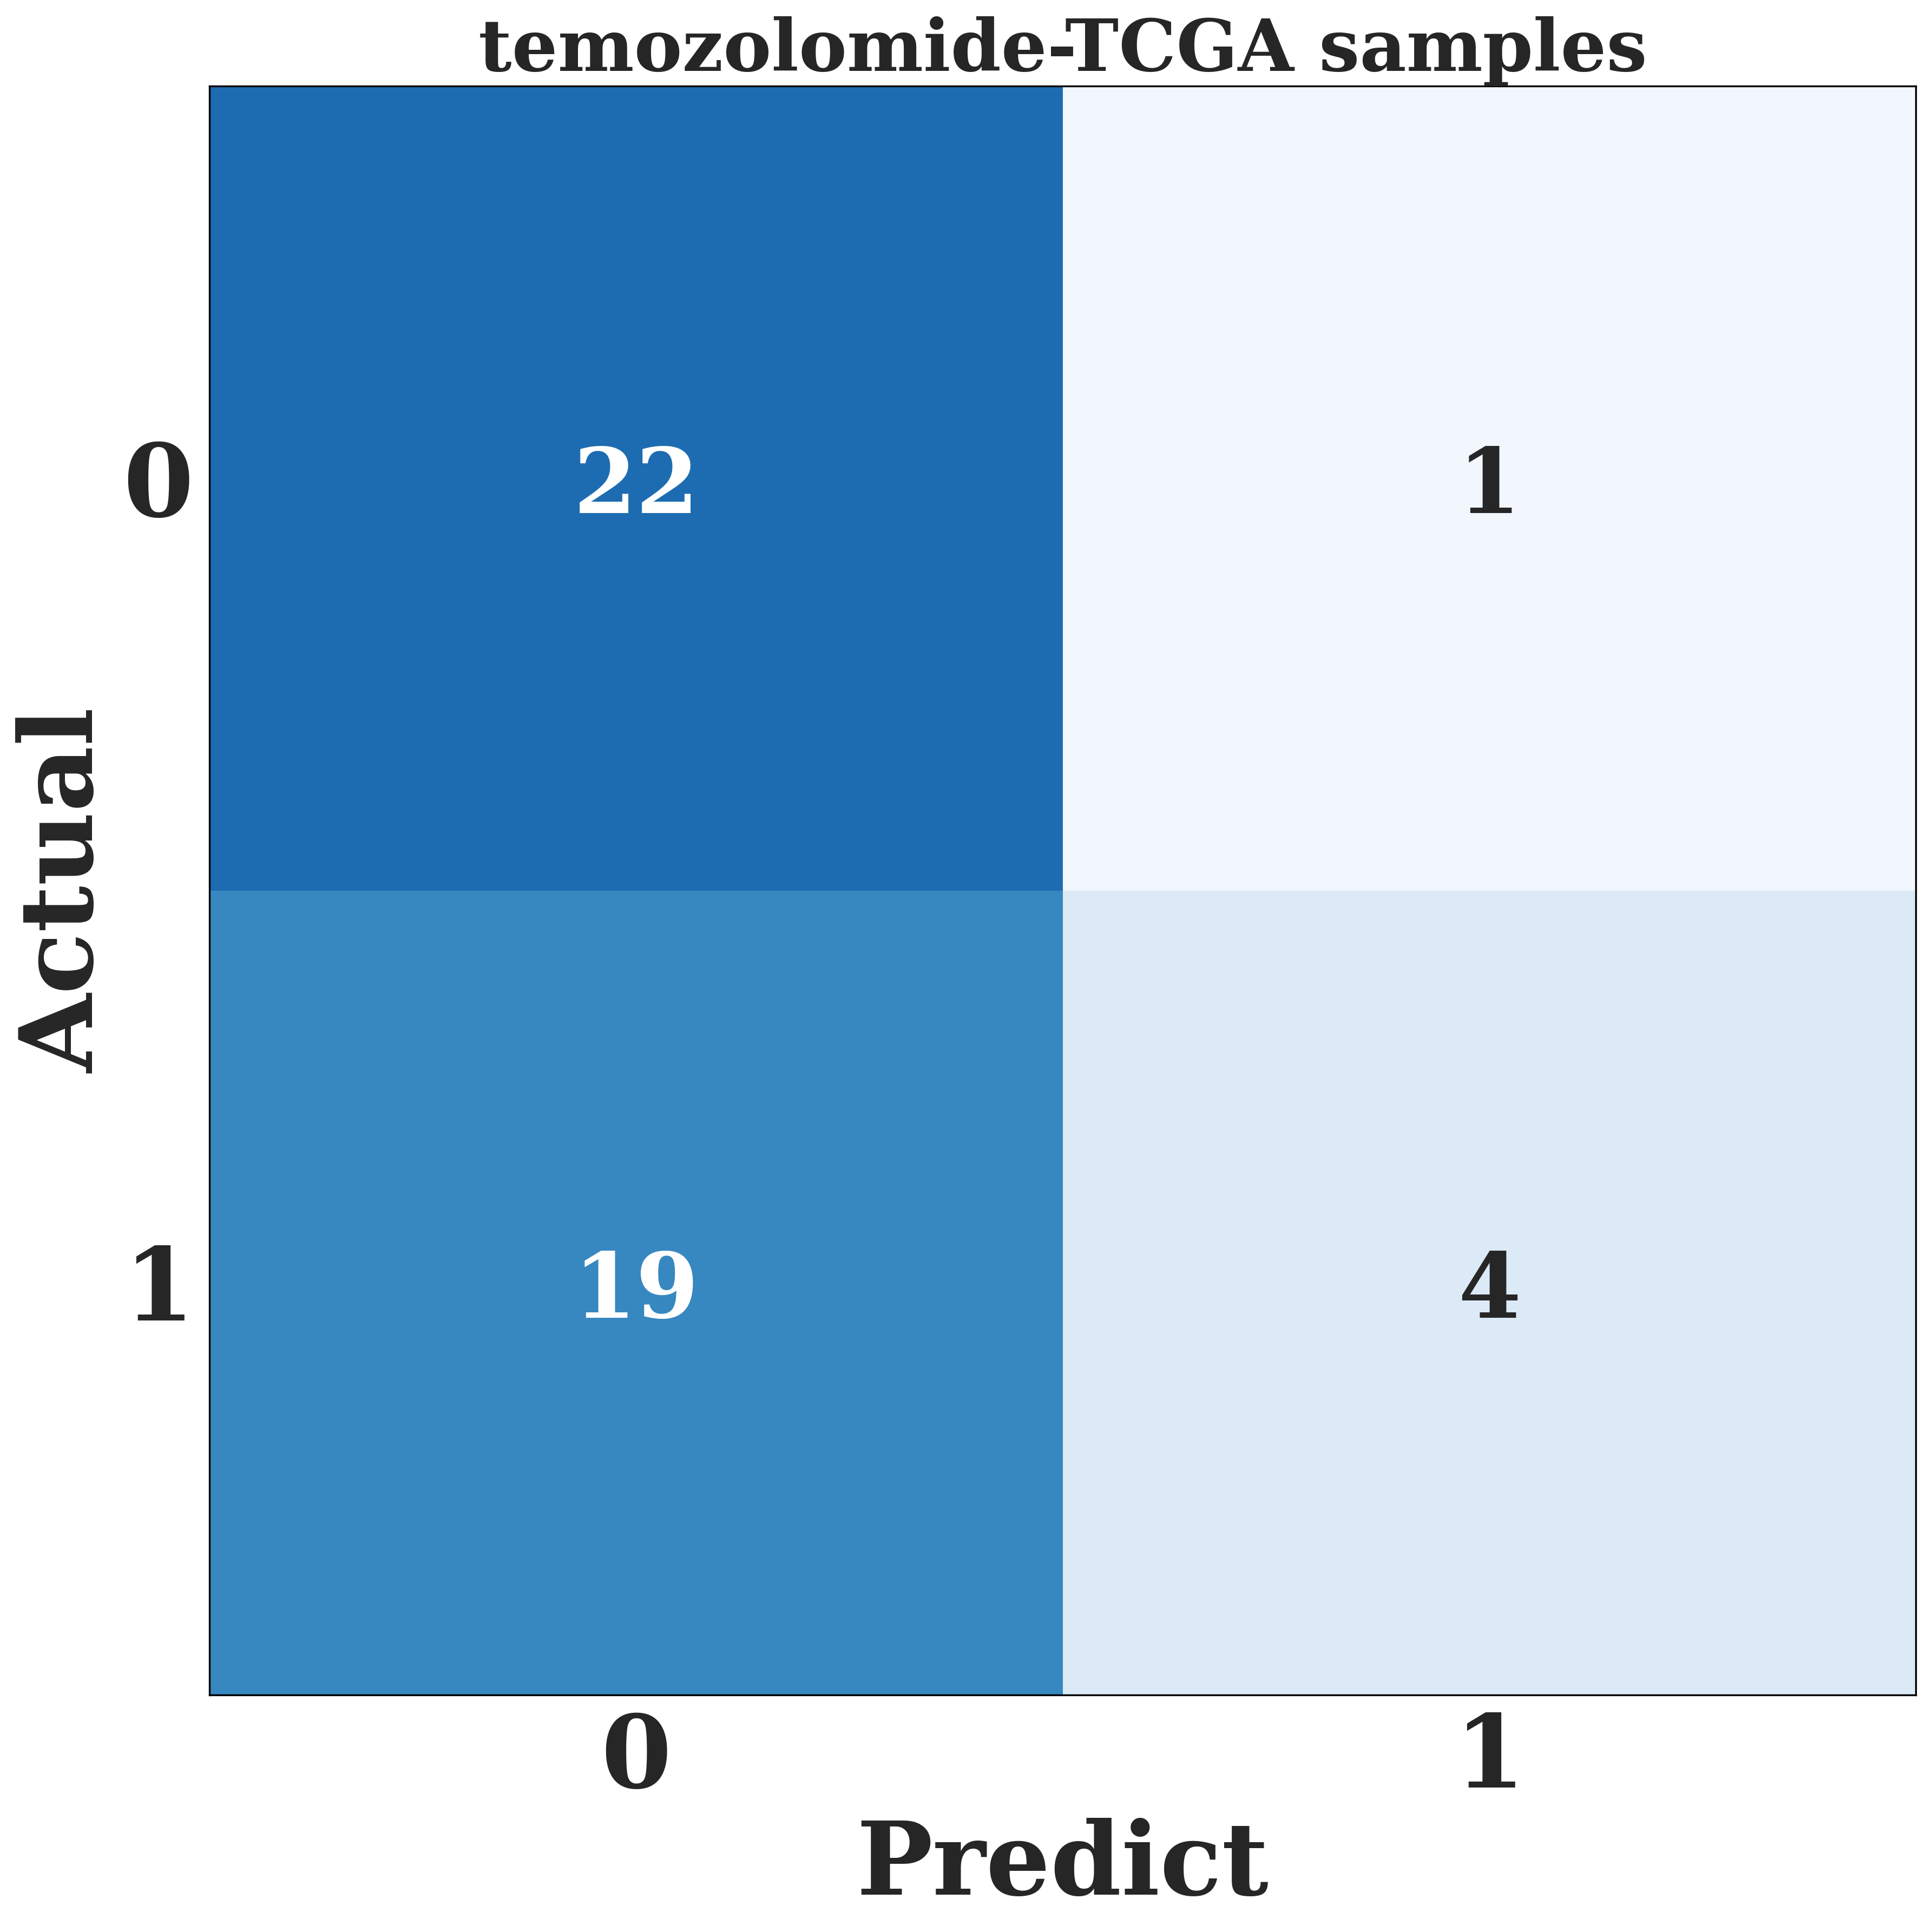

In [51]:
if model_inference is True:
    set_seed(seed)
    if model_name == "Omics_DrugESPF_Model":
        model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                            drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                            n_layer, DA_Folder, TCGA_pretrain_weight_path_dict= None)
    elif model_name == "Omics_DCSA_Model":
        model = Omics_DCSA_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                            drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                            n_layer, DA_Folder, TCGA_pretrain_weight_path_dict= None)
    elif model_name == "GIN_DCSA_model":
        model = GIN_DCSA_model(omics_encode_dim_dict, activation_func,activation_func_final,dense_layer_dim, device,
                            drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, 
                            n_layer, DA_Folder,TCGA_pretrain_weight_path_dict=None)
    model.to(device=device)
    model.load_state_dict(best_weight) 
    drug_list=["cisplatin", "5-fluorouracil", "gemcitabine", "sorafenib", "temozolomide"]
    drugs_metrics={}
    for drug_name in drug_list:
        if DA_Folder != 'None':
            with open(f"../data/DAPL/share/pretrain/{DA_Folder}/{cohort}/{drug_name}_latent_results.pkl", 'rb') as f:
                latent_dict = pickle.load(f)
                CohortExp_df = pd.DataFrame(latent_dict).T # 32
        else:
            CohortExp_df = pd.read_csv(f"../data/DAPL/share/{cohort}_fromDAPL/{drug_name}/{cohort.lower()}data{geneNUM}.csv", sep=',', index_col=0) #1426
        label_df = pd.read_csv(f"../data/DAPL/share/{cohort}_fromDAPL/{drug_name}/{cohort.lower()}label{geneNUM}.csv", sep=',')
        label_df.columns.values[0] = 'ModelID'
        label_df.columns.values[1] = 'Label'
        label_df['drug_name'] = drug_name
        # label_df = 1 - label_df # make label 0 to 1, 1 to 0 to match regressionpredicted output. after that 0: sensitive, 1: resistant
        CohortExp_df = CohortExp_df.sort_index(axis=0).sort_index(axis=1)
        print(f"{cohort}exp {drug_name}data",CohortExp_df.shape)
        label_df = label_df.sort_index(axis=0).sort_index(axis=1)
        print(f"label_df {drug_name}data",label_df.shape)
        for omic_type in include_omics:
            if DA_Folder != 'None':
                omics_data_dict["Exp"] = CohortExp_df
            else:
                if omic_type == "Exp":
                    scaler = scaler_dict[omic_type]
                    omics_data_dict[omic_type] = pd.DataFrame(scaler.transform(CohortExp_df),index=CohortExp_df.index,columns=CohortExp_df.columns) # use fitted CCLE scaler to transform TCGA data
            # omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
            omics_numfeatures_dict[omic_type] = omics_data_dict[omic_type].shape[1]
            # print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
            print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])
#         drug_df_path= "../data/DAPL/share/GDSC_drug_merge_pubchem_dropNA_MACCS.csv"
        drug_df = pd.read_csv( drug_df_path, sep=',')
        drug_df['name'] = drug_df['name'].str.lower()
        drug_df = drug_df.set_index('name', drop=False)
        # get specific drug and ccl
        drug_df = drug_df[drug_df['name'].str.lower() == drug_name.lower()]
        print(drug_df)
        if ESPF is True:
            print("drug_smiles",drug_df["SMILES"])
            # 挑出重複的SMILES
            duplicate =  drug_df["SMILES"][drug_df["SMILES"].duplicated(keep=False)]
            #ESPF
            vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
            sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency
            # 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
            drug_df["drug_encode"] = pd.Series(drug_df["SMILES"]).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
#             print("drug_encode",type(drug_df["drug_encode"]))
            drug_df["drug_encode"] = [i[:2] for i in drug_df["drug_encode"].values]
            print(drug_df["drug_encode"] )
        else:
            drug_df["drug_encode"]=[list(map(int, item.split(','))) for item in drug_df["MACCS166bits"].values]
        #--------------------------------------------------------------------------------------------------------------------------
        num_ccl = list(omics_data_dict.values())[0].shape[0]
        num_drug = drug_df["drug_encode"].shape[0]
        print("num_ccl,num_drug: ",num_ccl,num_drug)
# Fc1c[nH]c(=O)[nH]c1=O 
        set_seed(seed)
        dataset = InstanceResponseDataset(label_df, omics_data_dict, drug_df, drug_graph, include_omics, device)
        onedrug_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
        # eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
        (eval_targets, eval_outputs,predAUCwithUnknownGT,
        AttenScorMat_DrugSelf ,AttenScorMat_DrugCellSelf,
        eval_outputs_before_final_activation_list,  
        mean_batch_eval_loss_WO_penalty)  = evaluation(model, None,None,
                                                    criterion, onedrug_loader, device,ESPF,Drug_SelfAttention, 
                                                    weighted_threshold, few_weight, more_weight, 
                                                    outputcontrol='inference')
        # Calculate classification metrics                                            
        drugs_metrics[drug_name], _  = metrics_calculator(torch.cat(eval_targets), torch.cat(eval_outputs), best_prob_threshold, metric, dataset="test")
        drugs_metrics[drug_name]["eval_targets"]=eval_targets
        drugs_metrics[drug_name]["eval_outputs"]=eval_outputs
        drugs_metrics[drug_name]["eval_outputs_before_final_activation_list"]=eval_outputs_before_final_activation_list
        drugs_metrics[drug_name][criterion.loss_type] = mean_batch_eval_loss_WO_penalty

        if 'BCE' in criterion.loss_type :
            (test_cm ,  test_GT_0_count, test_GT_1_count, 
            test_pred_binary_0_count, test_pred_binary_1_count ) =metrics_calculator.confusion_matrix(torch.cat(eval_targets), torch.cat(eval_outputs), best_prob_threshold)
            drugs_metrics[drug_name]["CM"] = test_cm
            # # plot confusion matrix
            cm_datas = [(test_cm, cohort, 'Blues')]
            Confusion_Matrix_plot(cm_datas,hyperparameter_folder_path=best_weight_path,drug=drug_name)
        else:#regression use prob_threshold to get binary outcome
            df = pd.DataFrame({'predicted AUDRC': torch.cat(eval_outputs).cpu().numpy(),
                    'Label': torch.cat(eval_targets).cpu().numpy()})
            # Perform t-test between the two groups
            sensitive = df[df['Label'] == 1]['predicted AUDRC']
            resistant = df[df['Label'] == 0]['predicted AUDRC']
            t_stat, p_val = ttest_ind(sensitive, resistant)
            drugs_metrics[drug_name]["pvalue"]= p_val
            if p_val<=0.05:
                TCGA_predAUDRC_box_plot_twoClass(drug_name,cohort,df,sensitive,resistant,p_val,best_weight_path)
    output_file = f"{best_weight_path}/NEW_BF{BF}_{cohort}_inference_result.txt"
    with open(output_file, "w") as file:
        if 'BCE' in criterion.loss_type :
            for drug_name, metrics in drugs_metrics.items():
                file.write(f"\n{drug_name}\n")
                file.write(f"BF_best_prob_threshold: {best_prob_threshold} according to {metric}\n")
                file.write(f"  test {criterion.loss_type}loss: {metrics[criterion.loss_type].item():.6f}\n")
                for key in metrics_type_set:
                    file.write(f"  '{key}': {metrics[key].item():.4f}\n")
                for key in ["eval_targets","eval_outputs_before_final_activation_list","eval_outputs"]:
                    file.write(f"\n{key}\n{metrics[key][0][:20]}\n\n")
        else:
            for drug_name, metrics in drugs_metrics.items():
                file.write(f"{drug_name}\n")
                file.write(f"  test {criterion.loss_type}loss: {metrics[criterion.loss_type].item():.6f}\n")
                if metrics['pvalue'].item() <= 0.05:
                    file.write(f"\n pvalue <= 0.05 ")
                else:
                    file.write(f"\n pvalue > 0.05 ")
                file.write(f"{drug_name} pvalue: {metrics['pvalue'].item():.4f}\n\n")
                for key in ["eval_targets","eval_outputs_before_final_activation_list","eval_outputs"]:
                    file.write(f"\n{key}\n{metrics[key][0][:20]}\n")       
#     os.chmod(output_file, 0o444)
    del model
    torch.cuda.set_device("cuda:0")# Set the current device
    gc.collect()# Optionally, force garbage collection to release memory 
    torch.cuda.empty_cache() # Empty PyTorch cache

In [50]:
print("eval_targets\n",eval_targets[0][:10])
print("eval_outputs_before_final_activation_list\n",eval_outputs_before_final_activation_list[0][:10])
print("eval_outputs\n",eval_outputs[0][:10])
print("\n mean_batch_eval_lossWOpenalty",mean_batch_eval_lossWOpenalty)
eval_metrics= metrics_calculator(torch.cat(eval_targets), torch.cat(eval_outputs),median_value=None)
print(eval_metrics)

eval_targets
 tensor([1., 1., 1., 1., 0., 0., 1., 0., 1., 0.], device='cuda:0')
eval_outputs_before_final_activation_list
 [-0.8490349  -2.7432127   0.06351329 -1.9881604  -2.5853007  -3.3482187
 -1.1625171  -4.42436    -1.5388207  -4.357288  ]
eval_outputs
 tensor([0.2996, 0.0605, 0.5159, 0.1205, 0.0701, 0.0340, 0.2382, 0.0118, 0.1767,
        0.0127], device='cuda:0')


NameError: name 'mean_batch_eval_lossWOpenalty' is not defined

In [49]:
if splitType == "byCCL":
    id_unrepeat_whole = list(range(476))
elif splitType == "byDrug":
    id_unrepeat_whole = list(range(1440))
    id_unrepeat_whole[:10], id_unrepeat_whole[-10:]  # Display the first and last 10 elements to confirm

eval_pearson, eval_spearman,eval_AllSameValuesList_count  = correlation_func(splitType, AUC_df.values,AUC_df.index,AUC_df.columns,id_unrepeat_whole,torch.cat(eval_targets),torch.cat(eval_outputs))

NameError: name 'id_unrepeat_whole' is not defined

NameError: name 'eval_pearson' is not defined

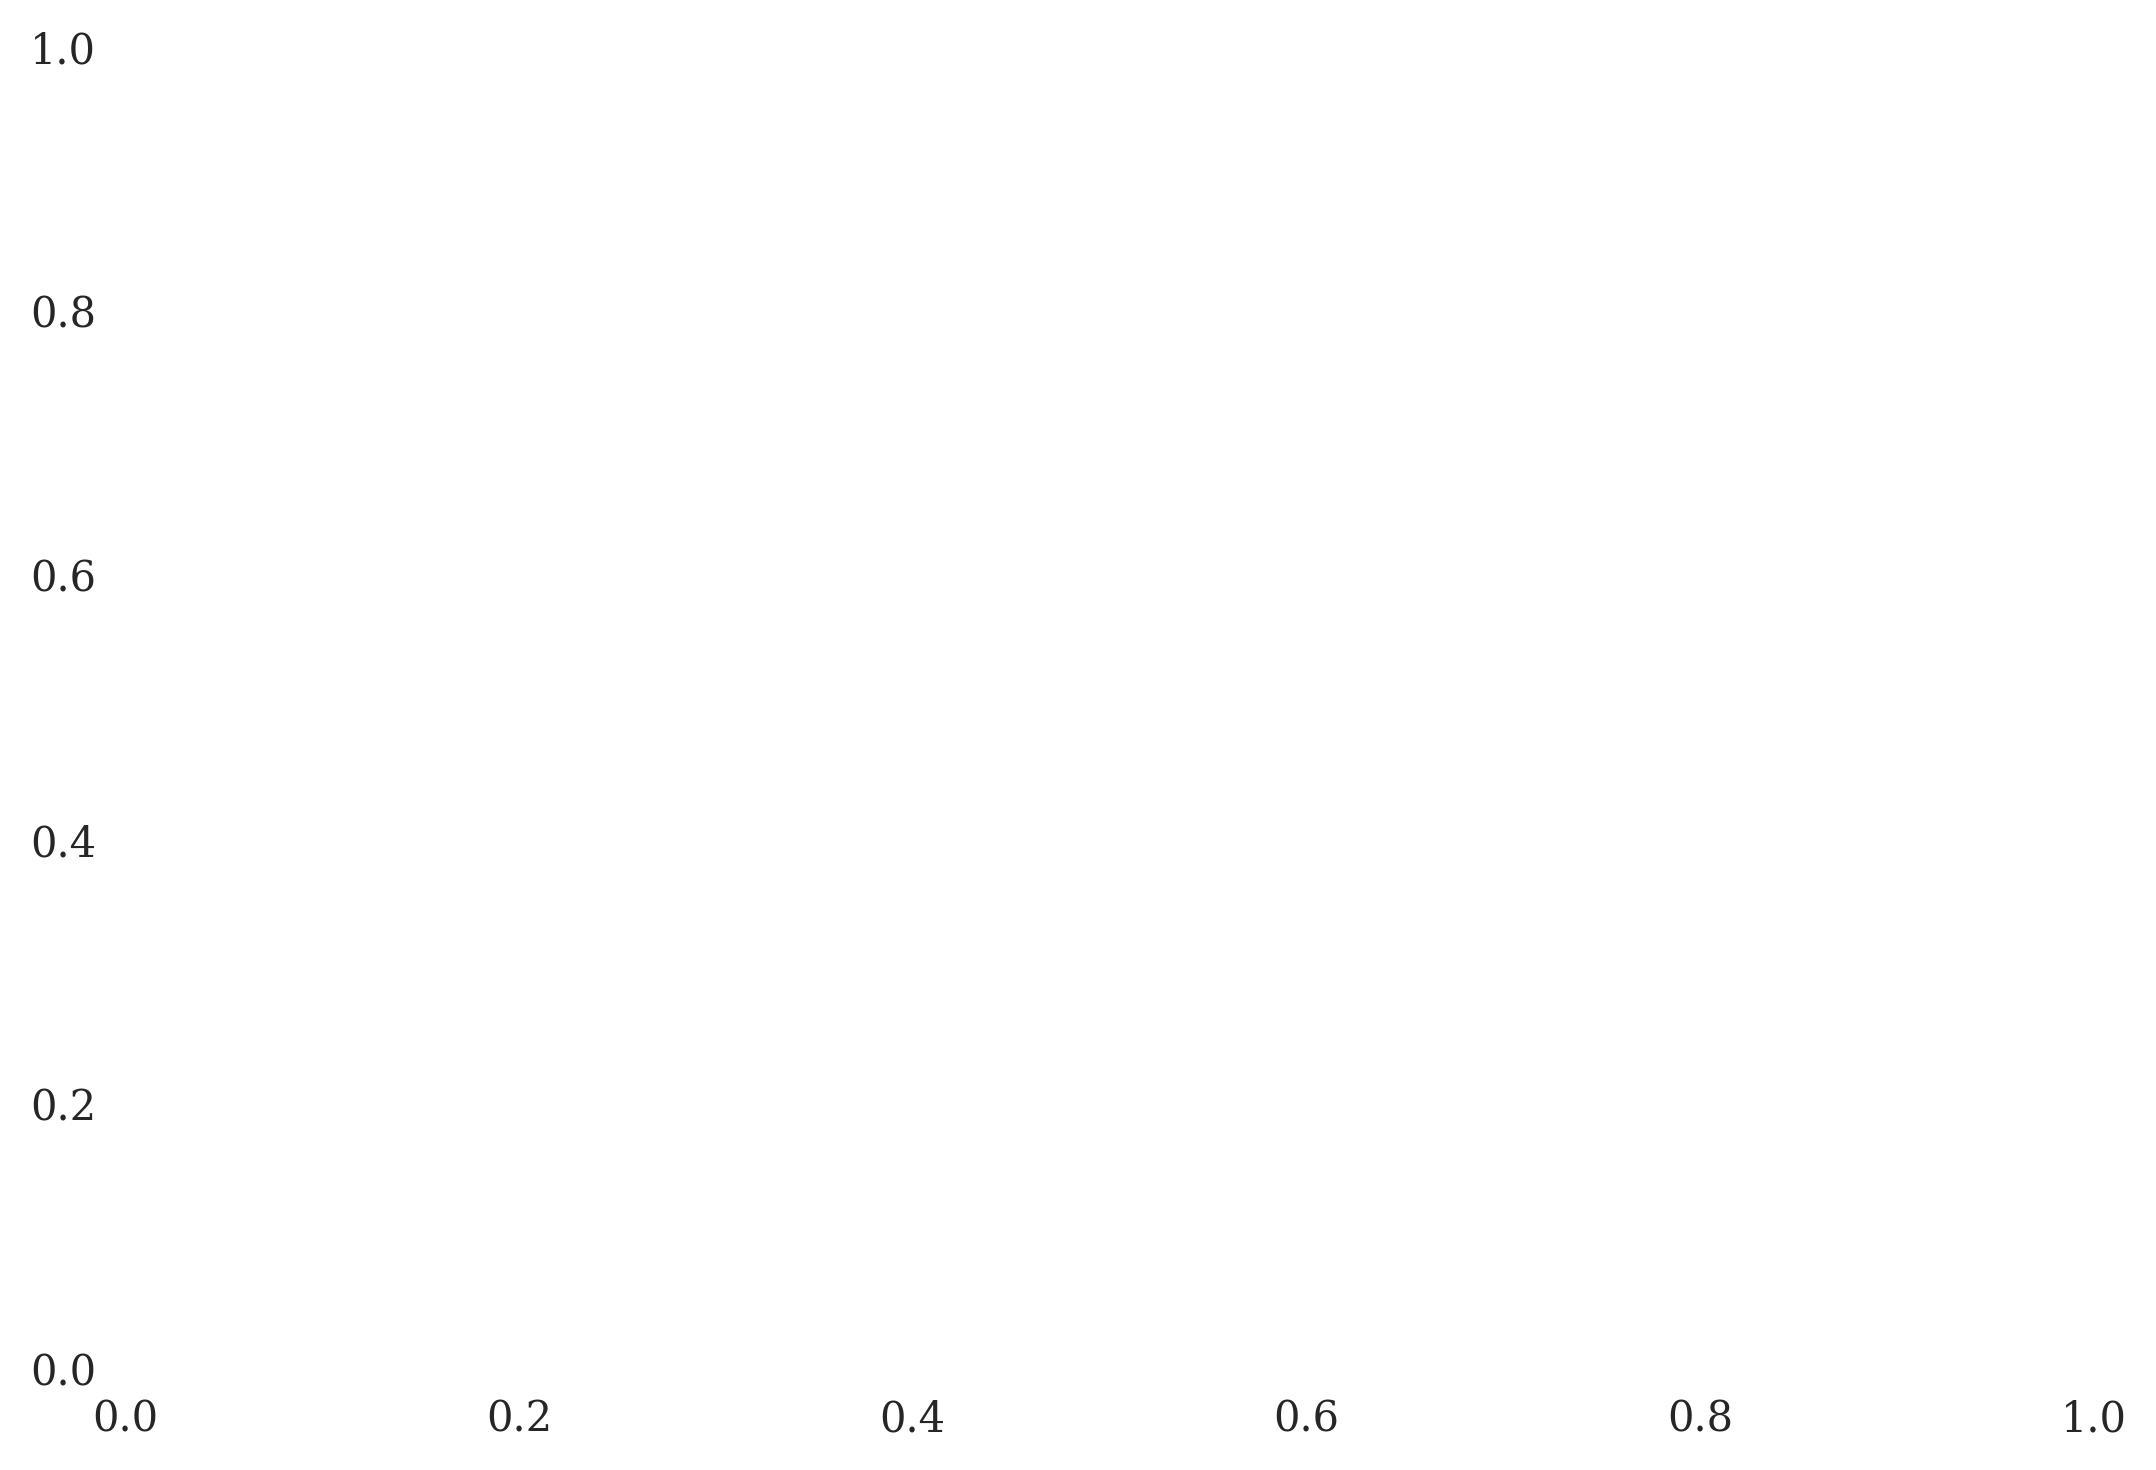

In [48]:
#pearson
# Create a density plot using seaborn's kdeplot function
fig=plt.figure(figsize=(14, 5))
# Set the title of the plot

plt.subplot(1,2,1)
# sns.kdeplot(test_pearson1, fill=True, color='red', label='up',linewidth=1.5)
sns.kdeplot(eval_pearson, fill=True, color='blue', label='down',linewidth=1.5)
# Set the x-axis label to 'Density'
plt.xlabel('Pearson\'s Correlation Coefficient Value', fontsize=16)
# Set the y-axis label to 'Pearson\'s Correlation Coefficient Value'
plt.ylabel('Density', fontsize=16)
plt.legend(loc='upper left',fontsize=10) 

plt.subplot(1,2,2)
#spearman
# Create a density plot using seaborn's kdeplot function
# sns.kdeplot(test_spearman1, fill=True, color='red', label='up',linewidth=1.5)
sns.kdeplot(eval_spearman, fill=True, color='blue', label='down',linewidth=1.5)
# Set the x-axis label to 'Density'
plt.xlabel('Spearman\'s Correlation Coefficient Value', fontsize=16)
# Set the y-axis label to 'Pearson\'s Correlation Coefficient Value'
plt.ylabel('Density', fontsize=16)
plt.legend(loc='upper left',fontsize=10) 
fig.suptitle(f'Density Plot of Correlation {model_name}', fontsize=16)

In [17]:
# for name, pearson in [("Test", test_pearson1)]:
#     print(f"Mean Median Mode {name} Pearson {model_name}:\t{np.mean(pearson):.6f} ± {np.std(pearson):.4f}\t{stats.skew(pearson, bias=False, nan_policy='raise'):.6f}\t {np.median(pearson):.6f}\t{stats.mode(np.round(pearson,2))}\n")
# for name, spearman in [("Test", test_spearman1)]:
#     print(f"Mean Median Mode {name} Spearman {model_name}:\t{np.mean(spearman):.6f} ± {np.std(spearman):.4f}\t{stats.skew(spearman, bias=False, nan_policy='raise'):.6f}\t {np.median(spearman):.6f}\t{stats.mode(np.round(spearman,2))}\n")

for name, pearson in [("Test", eval_pearson)]:
    print(f"Mean Median Mode {name} Pearson {model_name}:\t{np.mean(pearson):.6f} ± {np.std(pearson):.4f}\t{stats.skew(pearson, bias=False, nan_policy='raise'):.6f}\t {np.median(pearson):.6f}\t{stats.mode(np.round(pearson,2))}\n")
for name, spearman in [("Test", eval_spearman)]:
    print(f"Mean Median Mode {name} Spearman {model_name}:\t{np.mean(spearman):.6f} ± {np.std(spearman):.4f}\t{stats.skew(spearman, bias=False, nan_policy='raise'):.6f}\t {np.median(spearman):.6f}\t{stats.mode(np.round(spearman,2))}\n")


Mean Median Mode Test Pearson Omics_DCSA_Model:	0.885606 ± 0.0462	-2.039972	 0.892931	ModeResult(mode=0.91, count=62)

Mean Median Mode Test Spearman Omics_DCSA_Model:	0.793078 ± 0.0583	-1.147673	 0.801224	ModeResult(mode=0.8, count=47)



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

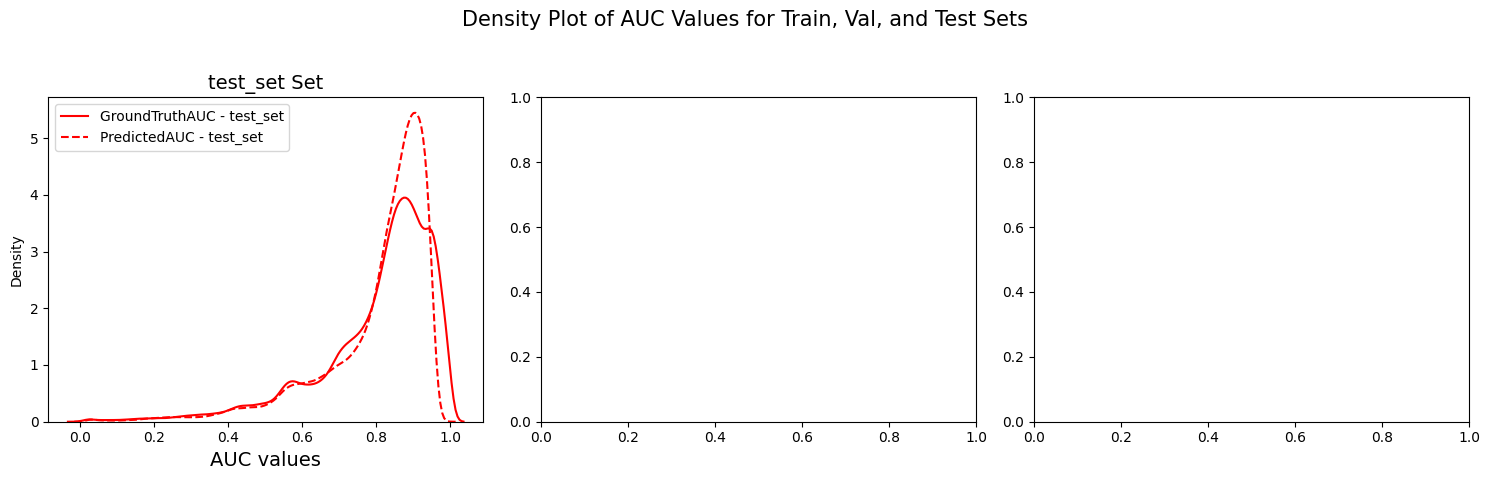

In [18]:
datas = [(eval_targets, eval_outputs, 'test_set', 'red')] #[torch.tensor([], device='cuda:0')]
# plot Density_Plot_of_AUC_Values of train val test datasets
hyperparameter_folder_path = None
Density_Plot_of_AUC_Values(datas,hyperparameter_folder_path)

In [16]:
predAUCmatrix_df = pd.read_csv(best_weight_path+"predicted AUC values with UnknownGroundTruth samples.csv", sep=',', index_col=0)

In [17]:
# get index of specific  CCL type
CCLtypeDF = pd.read_csv("../data/CCLE/480CCL all sample types list.txt", sep='\t', index_col=0)
print(CCLtypeDF.shape)
print((set(CCLtypeDF.index)-set(matched_samples)))
CCLtypeDF= (CCLtypeDF.T[matched_samples]).T
print(CCLtypeDF.shape)
Tissue_Type = ['Prostate', 'Ovary and Fallopian Tube', 'Esophagus and Stomach', 
                                    'Pancreas', 'Lung', 'Biliary Tract', 'CNS Brain', 'Breast',
                                    'Bladder or Urinary Tract', 'Thyroid', 'Kidney', 'Head and Neck',
                                    'Uterus', 'Bowel', 'Skin', 'Liver', 'Pleura']

dict = {"Tissue_Type":Tissue_Type, "MAE":[],"Sample_Size":[]}
for type in Tissue_Type:
    type_indices = CCLtypeDF.index[CCLtypeDF["OncotreeLineage"] == type].tolist()
    pred_AUC = np.concatenate(predAUCmatrix_df.loc[type_indices].values)
    GT_AUC = np.concatenate(AUC_df.loc[type_indices].values)
    mask = ~np.isnan(GT_AUC)
    mse = np.mean((pred_AUC[mask] - GT_AUC[mask]) ** 2)
    mae = np.mean(np.abs(pred_AUC[mask] - GT_AUC[mask]))
    dict["MAE"].append(mae)
    dict["Sample_Size"].append(len(type_indices))
print(dict)

(480, 1)
{'ACH-000047', 'ACH-001024', 'ACH-000309', 'ACH-000979'}
(476, 1)
{'Tissue_Type': ['Prostate', 'Ovary and Fallopian Tube', 'Esophagus and Stomach', 'Pancreas', 'Lung', 'Biliary Tract', 'CNS Brain', 'Breast', 'Bladder or Urinary Tract', 'Thyroid', 'Kidney', 'Head and Neck', 'Uterus', 'Bowel', 'Skin', 'Liver', 'Pleura'], 'MAE': [0.053161212311937864, 0.04807667112087825, 0.048818469367331696, 0.051602280614034414, 0.050509283479876654, 0.05048725885369153, 0.05071948666172378, 0.05139497059868344, 0.05120264580784668, 0.05151358878648829, 0.0547444460281538, 0.05038012766762808, 0.0504408430583611, 0.05739064591184097, 0.05010206953891626, 0.056035468440888754, 0.05928841260387694], 'Sample_Size': [3, 30, 40, 33, 92, 7, 34, 22, 23, 9, 17, 23, 23, 27, 39, 17, 9]}


In [18]:
combined_data = list(zip(dict['Tissue_Type'], dict['MAE'], dict['Sample_Size']))
# Sort the list by the MAE value (second element of each tuple)
sorted_dict = sorted(combined_data, key=lambda x: x[1])
# Unzip the sorted dict back into separate lists
sorted_tissue_type, sorted_mae, sorted_sample_size = zip(*sorted_dict)
# Convert back to lists
sorted_tissue_type = list(sorted_tissue_type)
sorted_mae = list(sorted_mae)
sorted_sample_size = list(sorted_sample_size)
# Update the dictionary with sorted values
sorted_data_dict = {'Tissue_Type': sorted_tissue_type,
                    'MAE': sorted_mae,
                    'Sample_Size': sorted_sample_size}
print(sorted_data_dict)

{'Tissue_Type': ['Ovary and Fallopian Tube', 'Esophagus and Stomach', 'Skin', 'Head and Neck', 'Uterus', 'Biliary Tract', 'Lung', 'CNS Brain', 'Bladder or Urinary Tract', 'Breast', 'Thyroid', 'Pancreas', 'Prostate', 'Kidney', 'Liver', 'Bowel', 'Pleura'], 'MAE': [0.04807667112087825, 0.048818469367331696, 0.05010206953891626, 0.05038012766762808, 0.0504408430583611, 0.05048725885369153, 0.050509283479876654, 0.05071948666172378, 0.05120264580784668, 0.05139497059868344, 0.05151358878648829, 0.051602280614034414, 0.053161212311937864, 0.0547444460281538, 0.056035468440888754, 0.05739064591184097, 0.05928841260387694], 'Sample_Size': [30, 40, 39, 23, 23, 7, 92, 34, 23, 22, 9, 33, 3, 17, 17, 27, 9]}


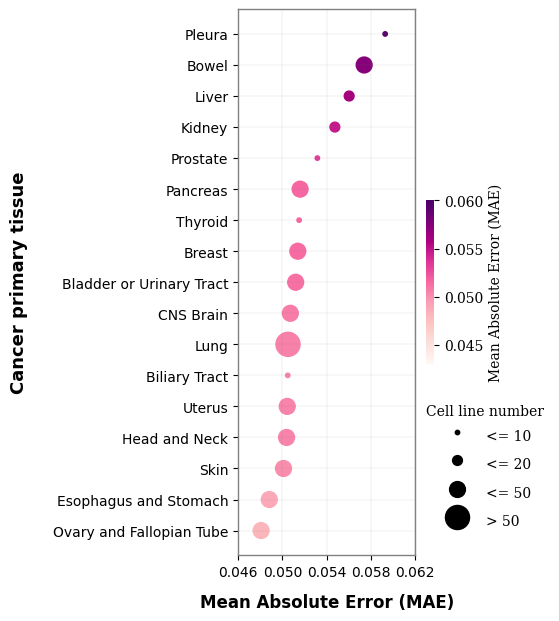

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Sample data
data = pd.DataFrame(sorted_data_dict)
# Define bubble size
bubble_size = result = [10 if x <= 10 else
                        50 if x <= 20 else
                        130 if x <= 50 else
                        300
                        for x in data['Sample_Size']   ]
# Create figure
fig, ax = plt.subplots(figsize=(5, 6))
plt.rcParams["font.family"] = "serif"
# Scatter plot (bubble plot)
sc = ax.scatter(
    data['MAE'], data['Tissue_Type'], 
    s=bubble_size, c=data['MAE'], cmap='RdPu',vmin=0.043,vmax=0.060)
# Add colorbar
cbar = plt.colorbar(sc, ax=ax,shrink=0.3)
cbar.set_label("Mean Absolute Error (MAE)")
cbar.outline.set_visible(False) # remove the boundary/frame of the colorbar 
# Legend for sample sizes
legend_sizes = [10, 50, 130, 300]  # Example reference sizes
legend_labels = ["<= 10", "<= 20", "<= 50", "> 50"]
legend_handles = [
    plt.scatter([], [], s=size, color='black', label=label)
    for size, label in zip(legend_sizes, legend_labels)]
legend = ax.legend(
    handles=legend_handles, title="Cell line number",
    bbox_to_anchor=(1.8, 0.3),
    handlelength=2.5,        # Length of the legend handles (e.g., lines)
    handleheight=2.0, )
legend.get_frame().set_visible(False)
# Adjust layout to prevent cropping
plt.tight_layout(rect=[0, 0, 1.2, 1])
plt.grid(True, linestyle='-', color='gray', linewidth=0.3, alpha=0.3)
plt.ylabel("Cancer primary tissue", fontsize=13, fontweight="bold", labelpad=18)
plt.xlabel("Mean Absolute Error (MAE)", fontsize=12, fontweight="bold", labelpad=10)
plt.xticks([0.046, 0.050, 0.054, 0.058, 0.062])
for spine in plt.gca().spines.values(): # remove the boundary/frame of the plot 
    spine.set_color('gray')      # Set spine color to gray
    spine.set_linewidth(1)
plt.show()

/tmp/ipykernel_26740/2589213400.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Better default style


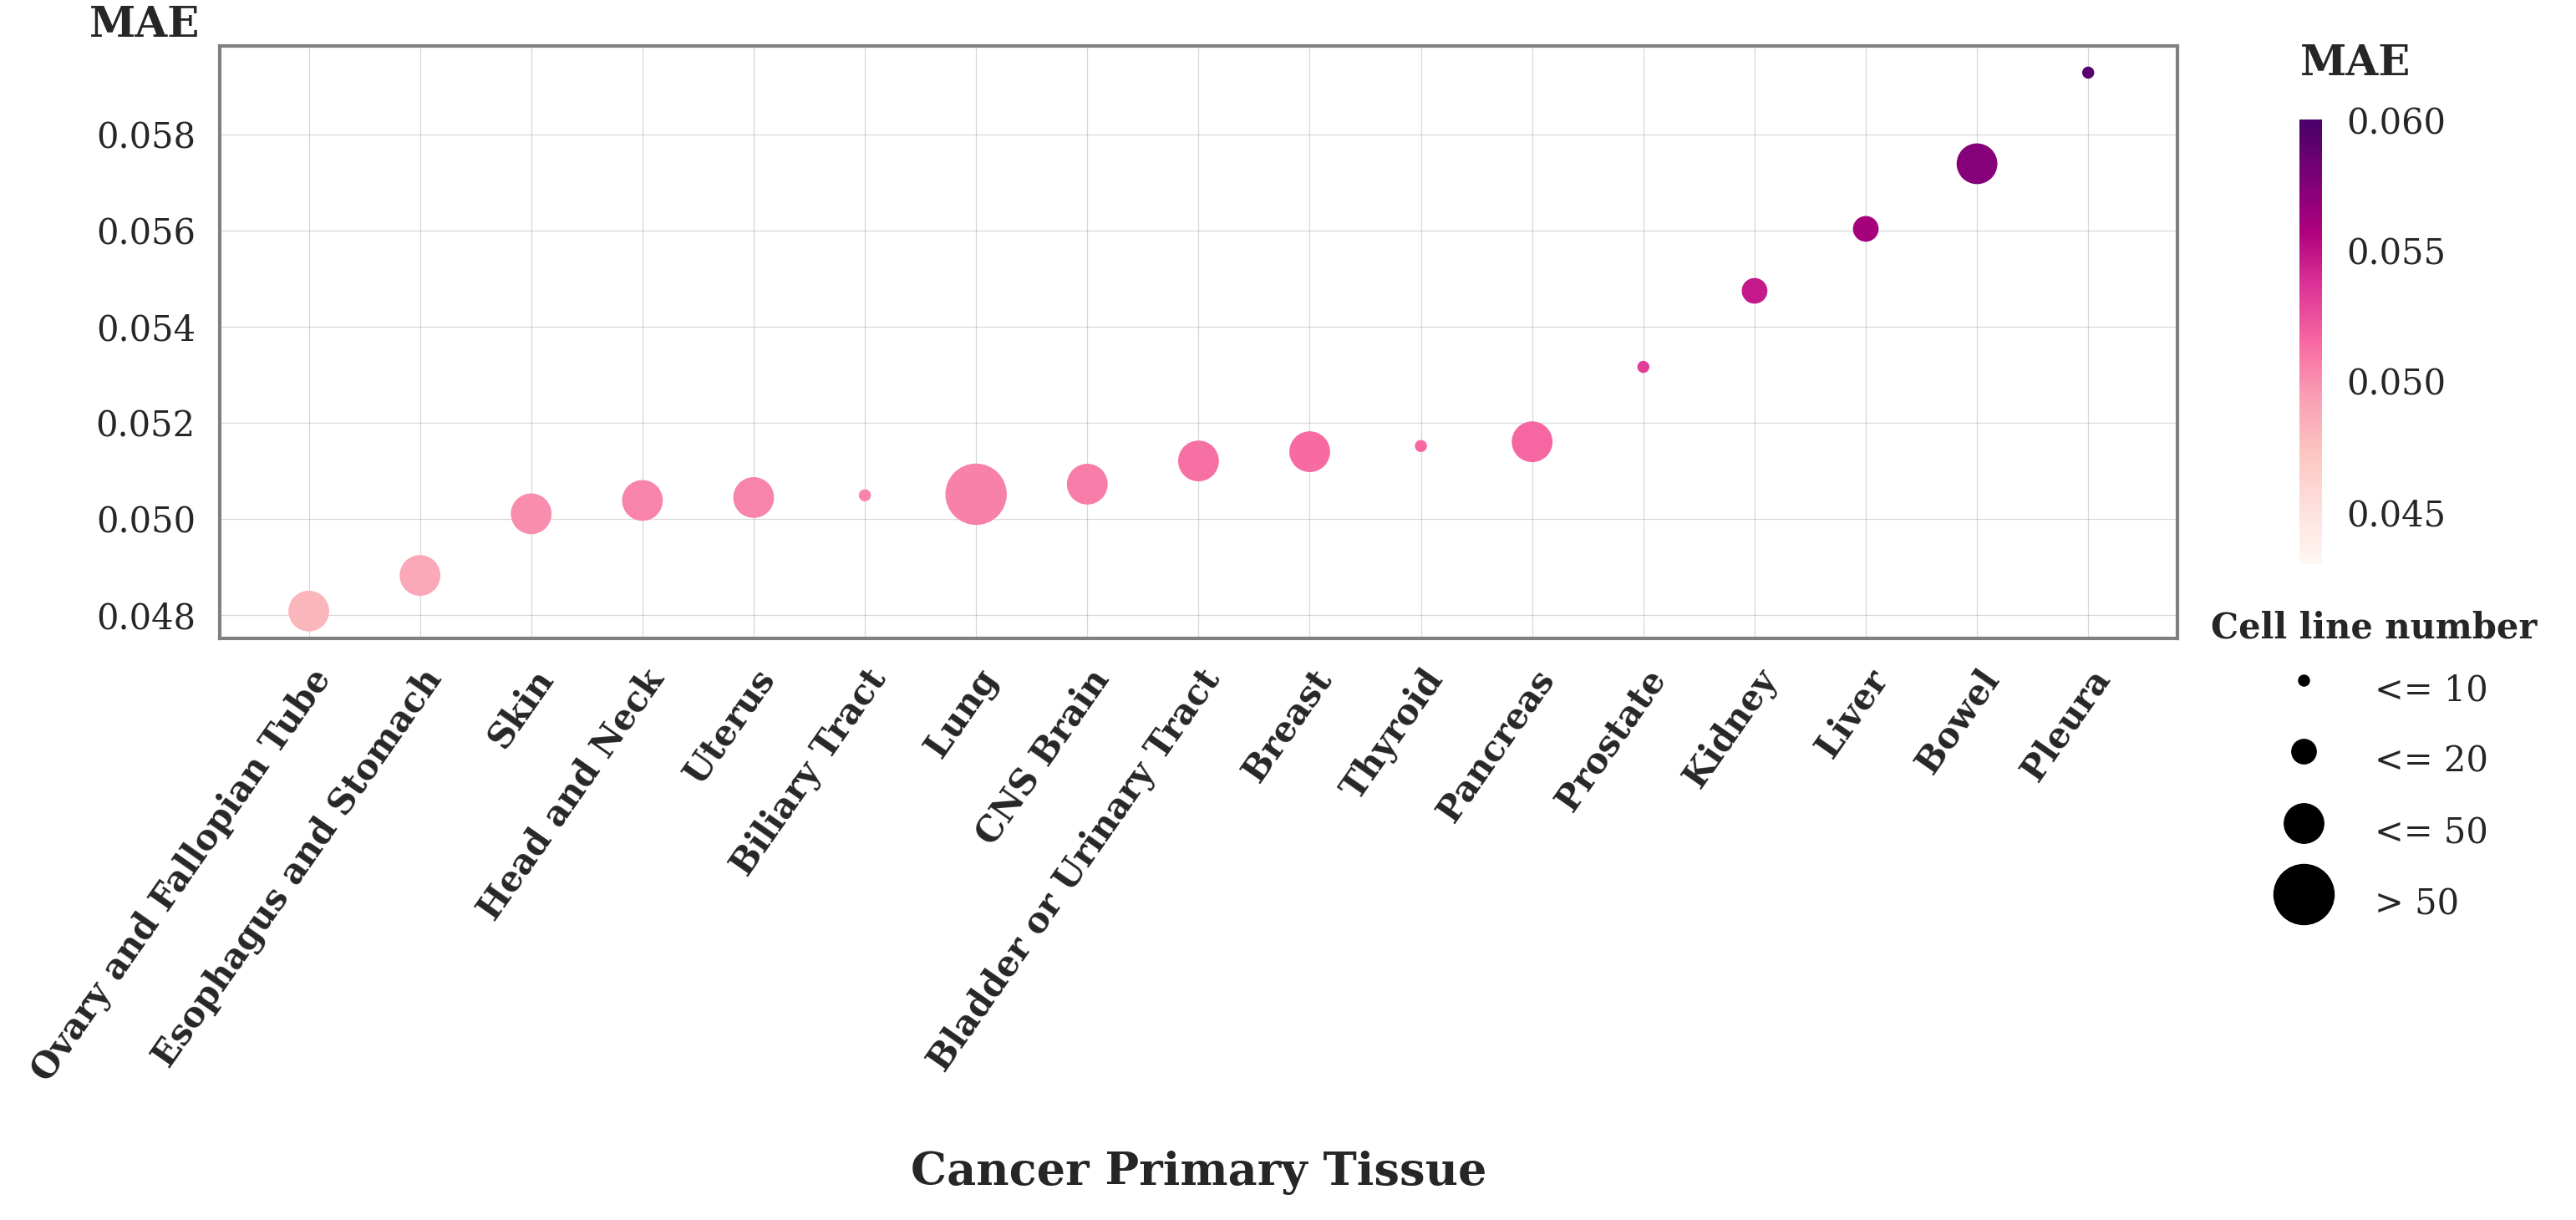

<Figure size 2400x1500 with 0 Axes>

In [20]:
import matplotlib.font_manager as fm
import matplotlib as mpl

# Set up high-quality rendering
plt.style.use('seaborn')  # Better default style
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300  # Higher resolution
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.figsize'] = (8, 5)  # Slightly larger figure
mpl.rcParams['path.simplify'] = True
mpl.rcParams['path.simplify_threshold'] = 1.0
mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
plt.rcParams["font.family"] = "serif"
data = pd.DataFrame(sorted_data_dict)
# Define bubble size
bubble_size = [10 if x <= 10 else
               50 if x <= 20 else
               130 if x <= 50 else
               300 for x in data['Sample_Size']]
# Create figure
fig, ax = plt.subplots(figsize=(6, 3.5))
plt.rcParams["font.family"] = "serif"
# Scatter plot (bubble plot) with swapped axes
sc = ax.scatter(
    data['Tissue_Type'], data['MAE'], 
    s=bubble_size, c=data['MAE'], cmap='RdPu', vmin=0.043, vmax=0.060)
# Add colorbar
cbar = plt.colorbar(sc, ax=ax, shrink=0.75)
cbar.ax.set_xlabel("MAE", fontsize=12, fontweight="bold", labelpad=10)
cbar.ax.xaxis.set_label_position("top") 
cbar.ax.xaxis.set_label_coords(2.5, 1.1)
cbar.outline.set_visible(False)  # Remove boundary/frame of colorbar 
# Legend for sample sizes
legend_sizes = [10, 50, 130, 300]  # Reference sizes
legend_labels = ["<= 10", "<= 20", "<= 50", "> 50"]
legend_handles = [
    plt.scatter([], [], s=size, color='black', label=label)
    for size, label in zip(legend_sizes, legend_labels)]
legend = ax.legend(
    handles=legend_handles, title="Cell line number",title_fontproperties=fm.FontProperties(weight='bold'),
    bbox_to_anchor=(1.2, 0.1),
    handlelength=2.5, handleheight=2.0)
legend.get_frame().set_visible(False)
# Adjust layout to prevent cropping
plt.tight_layout(rect=[0, 0, 1.8, 1.1])
plt.grid(True, linestyle='-', color='gray', linewidth=0.3, alpha=0.3)
# Swap x and y labels
plt.xlabel("Cancer Primary Tissue", fontsize=13, fontweight="bold", labelpad=18)

plt.ylabel("MAE",rotation=0, fontsize=12, fontweight="bold", labelpad=-30, loc='top')

# Adjust x-ticks if needed
plt.xticks(rotation=55, ha='right', rotation_mode='anchor', fontweight="bold")  # Rotate for better readability
# Remove the boundary/frame of the plot
for spine in plt.gca().spines.values():
    spine.set_color('gray')  
    spine.set_linewidth(1)
plt.show()
plt.savefig('./inference/high_quality_MAE horizontal plot.png', format='png', dpi=300)  # High-res raster

In [6]:
target_to_source_map = {
        'acute myeloid leukemia': 'na', #Only solid tumors
        'adrenocortical cancer': 'na',
        'bladder urothelial carcinoma': 'Bladder Cancer',
        'brain lower grade glioma': 'Brain Cancer',
        'breast invasive carcinoma': 'Breast Cancer',
        'cervical & endocervical cancer': 'Cervical Cancer',
        'cholangiocarcinoma': 'Bile Duct Cancer',
        'colon adenocarcinoma': 'Colon/Colorectal Cancer',
        'diffuse large B-cell lymphoma': 'na', #Only solid tumors
        'esophageal carcinoma': 'Esophageal Cancer',
        'glioblastoma multiforme': 'Brain Cancer',
        'head & neck squamous cell carcinoma': 'Head and Neck Cancer',
        'kidney chromophobe': 'Kidney Cancer',
        'kidney clear cell carcinoma': 'Kidney Cancer',
        'kidney papillary cell carcinoma': 'Kidney Cancer',
        'liver hepatocellular carcinoma': 'Liver Cancer',
        'lung adenocarcinoma': 'Lung Cancer',
        'lung squamous cell carcinoma': 'Lung Cancer',
        'mesothelioma': 'na',
        'ovarian serous cystadenocarcinoma': 'Ovarian Cancer',
        'pancreatic adenocarcinoma': 'Pancreatic Cancer',
        'pheochromocytoma & paraganglioma': 'na',
        'prostate adenocarcinoma': 'Prostate Cancer',
        'rectum adenocarcinoma': 'Colon/Colorectal Cancer',
        'sarcoma': 'Sarcoma',
        'skin cutaneous melanoma': 'Skin Cancer',
        'stomach adenocarcinoma': 'Gastric Cancer',
        'testicular germ cell tumor': 'na',
        'thymoma': 'na',
        'thyroid carcinoma': 'Thyroid Cancer',
        'uterine carcinosarcoma': 'Endometrial/Uterine Cancer',
        'uterine corpus endometrioid carcinoma': 'Endometrial/Uterine Cancer',
        'uveal melanoma': 'Eye Cancer'
    }

In [7]:
tcga_type_df= pd.read_csv("../data/DAPL/share/xena_sample_info_df.csv", sep=',')
tcga_type_df.rename(columns={tcga_type_df.columns[0]: 'ModelID'}, inplace=True)
tcga_type_df.rename(columns={tcga_type_df.columns[3]: 'primary_disease'}, inplace=True)
tcga_type_df['ModelID']=tcga_type_df['ModelID'].str.slice(0, -3)
tcga_type_df["primary_disease"] = tcga_type_df["primary_disease"].map(target_to_source_map)
tcga_type_df

ModelID  sample_type_id            sample_type primary_disease
0     TCGA-D3-A1QA             7.0  Additional Metastatic     Skin Cancer
1     TCGA-DE-A4MD             6.0             Metastatic  Thyroid Cancer
2     TCGA-J8-A3O2             6.0             Metastatic  Thyroid Cancer
3     TCGA-J8-A3YH             6.0             Metastatic  Thyroid Cancer
4     TCGA-EM-A2P1             6.0             Metastatic  Thyroid Cancer
...            ...             ...                    ...             ...
9803  TCGA-A7-A13E             1.0          Primary Tumor   Breast Cancer
9804  TCGA-A7-A0DB             1.0          Primary Tumor   Breast Cancer
9805  TCGA-A7-A26J             1.0          Primary Tumor   Breast Cancer
9806  TCGA-A7-A13D             1.0          Primary Tumor   Breast Cancer
9807  TCGA-07-0249             NaN                    NaN    Brain Cancer

[9808 rows x 4 columns]

In [ ]:
# information
struct_time   = time.localtime()
timestamp    = time.strftime("%Y-%m%d-%H%M", struct_time)

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

set_seed(seed)
if model_name == "Omics_DrugESPF_Model":
    model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        n_layer,DA_Folder,TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
elif model_name == "Omics_DCSA_Model":
    model = Omics_DCSA_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        n_layer,DA_Folder,TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
model.to(device=device)
best_weight = best_weight_path + "BestValWeight.pt"    
best_weight = torch.load(best_weight)
model.load_state_dict(best_weight) 
drug_list=["cisplatin", "5-fluorouracil", "gemcitabine", "sorafenib", "temozolomide"]
drugs_metrics={}
for drug_name in drug_list:
    if DA_Folder != 'None':
        with open(f"../data/DAPL/share/pretrain/{DA_Folder}/{cohort}/{drug_name}_latent_results.pkl", 'rb') as f:
            latent_dict = pickle.load(f)
            CohortExp_df = pd.DataFrame(latent_dict).T # 32
    else:
        CohortExp_df = pd.read_csv(f"../data/DAPL/share/{cohort}_fromDAPL/{drug_name}/{cohort.lower()}data{geneNUM}.csv", sep=',', index_col=0) #1426
    label_df = pd.read_csv(f"../data/DAPL/share/{cohort}_fromDAPL/{drug_name}/{cohort.lower()}label{geneNUM}.csv", sep=',')
    # print(label_df)
    label_df.columns.values[0] = 'ModelID'
    label_df.columns.values[1] = 'Label'
    label_df['drug_name'] = drug_name
    label_df = label_df.merge(tcga_type_df[['ModelID', 'primary_disease']], on='ModelID', how='left')
    counts = label_df['primary_disease'].value_counts()    # Step 1: 計算每種 primary_disease 的出現次數
    print("counts",counts)
    diseases_to_analyze = counts[counts > 10].index.tolist()    # Step 2: 選出出現次數大於 10 的疾病
    label_df = label_df[label_df['primary_disease'].isin(diseases_to_analyze)]    # Step 3: 篩選出這些疾病的資料
    CohortExp_df = CohortExp_df.sort_index(axis=0).sort_index(axis=1)
    print(f"{cohort}exp {drug_name}data",CohortExp_df.shape)
    label_df = label_df.sort_index(axis=0).sort_index(axis=1)
    print(f"label_df {drug_name}data",label_df.shape)
    for disease in diseases_to_analyze:    # Step 4: 針對每一個疾病類別做個別分析
        drug_deisease_name = f"{drug_name}_{disease}"
        disease_df = label_df[label_df['primary_disease'] == disease]
        print(f"disease_df {drug_name}data",disease_df.shape)
        for omic_type in include_omics:
            if DA_Folder != 'None':
                omics_data_dict["Exp"] = CohortExp_df
            else:
                if omic_type == "Exp":
                    scaler = scaler_dict[omic_type]
                    omics_data_dict[omic_type] = pd.DataFrame(scaler.transform(CohortExp_df),index=CohortExp_df.index,columns=CohortExp_df.columns) # use fitted CCLE scaler to transform TCGA data
            omics_numfeatures_dict[omic_type] = omics_data_dict[omic_type].shape[1]
            print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])
#       drug_df_path= "../data/DAPL/share/GDSC_drug_merge_pubchem_dropNA_MACCS.csv"
        drug_df = pd.read_csv( drug_df_path, sep=',')
        drug_df['name'] = drug_df['name'].str.lower()
        drug_df = drug_df.set_index('name', drop=False)
        # get specific drug and ccl
        drug_df = drug_df[drug_df['name'].str.lower() == drug_name.lower()]
        print(drug_df)
        if ESPF is True:
            print("drug_smiles",drug_df["SMILES"])
            # 挑出重複的SMILES
            duplicate =  drug_df["SMILES"][drug_df["SMILES"].duplicated(keep=False)]
            #ESPF
            vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
            sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency
            # 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
            drug_df["drug_encode"] = pd.Series(drug_df["SMILES"]).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
#             print("drug_encode",type(drug_df["drug_encode"]))
            drug_df["drug_encode"] = [i[:2] for i in drug_df["drug_encode"].values]
            print(drug_df["drug_encode"] )
        else:
            drug_df["drug_encode"]=[list(map(int, item.split(','))) for item in drug_df["MACCS166bits"].values]
        #--------------------------------------------------------------------------------------------------------------------------
        num_ccl = list(omics_data_dict.values())[0].shape[0]
        num_drug = drug_df["drug_encode"].shape[0]
        print("num_ccl,num_drug: ",num_ccl,num_drug)# Fc1c[nH]c(=O)[nH]c1=O 

        set_seed(seed)
        dataset = InstanceResponseDataset(disease_df, omics_data_dict, drug_df, drug_graph, include_omics, device)
        onedrug_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

        # eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
        (eval_targets, eval_outputs,predAUCwithUnknownGT,
        AttenScorMat_DrugSelf ,AttenScorMat_DrugCellSelf,
        eval_outputs_before_final_activation_list,  
        mean_batch_eval_loss_WO_penalty)  = evaluation(model, None,None,
                                                    criterion, onedrug_loader, device,ESPF,Drug_SelfAttention, 
                                                    weighted_threshold, few_weight, more_weight, 
                                                    outputcontrol='inference')
        # Calculate classification metrics                                            
        drugs_metrics[drug_deisease_name], _  = metrics_calculator(torch.cat(eval_targets), torch.cat(eval_outputs), best_prob_threshold, metric, dataset="test")
        drugs_metrics[drug_deisease_name]["eval_targets"]=eval_targets
        drugs_metrics[drug_deisease_name]["eval_outputs"]=eval_outputs
        drugs_metrics[drug_deisease_name]["eval_outputs_before_final_activation_list"]=eval_outputs_before_final_activation_list
        drugs_metrics[drug_deisease_name][criterion.loss_type] = mean_batch_eval_loss_WO_penalty

        if 'BCE' in criterion.loss_type :
            (test_cm ,  test_GT_0_count, test_GT_1_count, 
            test_pred_binary_0_count, test_pred_binary_1_count ) =metrics_calculator.confusion_matrix(torch.cat(eval_targets), torch.cat(eval_outputs), best_prob_threshold)

            drugs_metrics[drug_deisease_name]["CM"] = test_cm
            # # plot confusion matrix
            import matplotlib.font_manager as fm
            import matplotlib as mpl
            plt.style.use('default') # Revert style to default
            plt.rcParams.update(mpl.rcParamsDefault) # Revert all rcParams to their defaults
            cm_datas = [(test_cm, disease, 'Blues')]
            Confusion_Matrix_plot(cm_datas,hyperparameter_folder_path=best_weight_path,drug=drug_name)

        else:#regression use prob_threshold to get binary outcome
            df = pd.DataFrame({'predicted AUDRC': torch.cat(eval_outputs).cpu().numpy(),
                    'Label': torch.cat(eval_targets).cpu().numpy()})
            # Perform t-test between the two groups
            sensitive = df[df['Label'] == 1]['predicted AUDRC']
            resistant = df[df['Label'] == 0]['predicted AUDRC']
            t_stat, p_val = ttest_ind(sensitive, resistant)
            drugs_metrics[drug_deisease_name]["pvalue"]= p_val
            if p_val<=0.05:
                TCGA_predAUDRC_box_plot_twoClass(drug_name,cohort,df,sensitive,resistant,p_val,best_weight_path)
        # not a reasonable way to calculate AUROC and AUPRC to explain the model performance

output_file = f"{best_weight_path}/{cohort}_inference_result.txt"
with open(output_file, "w") as file:
    if 'BCE' in criterion.loss_type :
        for drug_deisease_name, metrics in drugs_metrics.items():
            file.write(f"\n{drug_deisease_name}\n")
            file.write(f"best_prob_threshold: {best_prob_threshold} according to {metric}\n")
            file.write(f"  test {criterion.loss_type}loss: {metrics[criterion.loss_type].item():.6f}\n")
            for key in metrics_type_set:
                file.write(f"  '{key}': {metrics[key].item():.4f}\n")
            for key in ["eval_targets","eval_outputs_before_final_activation_list","eval_outputs"]:
                file.write(f"\n{key}\n{metrics[key][0][:20]}\n\n")
    else:
        for drug_deisease_name, metrics in drugs_metrics.items():
            file.write(f"{drug_deisease_name}\n")
            file.write(f"  test {criterion.loss_type}loss: {metrics[criterion.loss_type].item():.6f}\n")
            if metrics['pvalue'].item() <= 0.05:
                file.write(f"\n pvalue <= 0.05 ")
            else:
                file.write(f"\n pvalue > 0.05 ")
            file.write(f"{drug_deisease_name} pvalue: {metrics['pvalue'].item():.4f}\n\n")
            for key in ["eval_targets","eval_outputs_before_final_activation_list","eval_outputs"]:
                file.write(f"\n{key}\n{metrics[key][0][:20]}\n")

Training on device cuda.
counts primary_disease
Head and Neck Cancer    22
Cervical Cancer         14
Lung Cancer              2
Gastric Cancer           1
Sarcoma                  1
Name: count, dtype: int64
TCGAexp cisplatindata (40, 1426)
label_df cisplatindata (36, 4)
Exp num_features 1426
                name        SMILES  \
name                                 
cisplatin  cisplatin  Cl[Pt]Cl.N.N   

                                                MACCS166bits  
name                                                          
cisplatin  0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0...  
drug_smiles name
cisplatin    Cl[Pt]Cl.N.N
Name: SMILES, dtype: object
name
cisplatin    ([140, 1753, 58, 25, 254, 19, 13, 19, 0, 0, 0,...
Name: drug_encode, dtype: object
num_ccl,num_drug:  40 1

 Drug_SelfAttention is applied 

✅ Set read-only permissions on: ./inference/2025-0724-0223_BF0_BCE_test_loss0.5942421_BestValEpo16_filedown_Omics_DCSA_Model_ModelID_ESPFTrue_DrugSelfAttenTrue_Exp1426_nla

In [38]:
def Confusion_Matrix_plot(datasets,hyperparameter_folder_path=None,drug=None):
    plt.rcParams["font.family"] = "serif"
    if len(datasets)==1:
        fig, ax = plt.subplots(figsize=(12,12))
        cm, title, color = datasets[0]
        sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"}, 
                    cmap=color, cbar=False, vmin=0, vmax=max(cm.max() * 1.3, 1), linewidths=0,
                    xticklabels=["0", "1"], yticklabels=["0", "1"], ax=ax) # xticklabels=["Predicted  0", "Predicted  1"], yticklabels=["Actual  0", "Actual  1"]
        if drug is not None:
            ax.set_title(f'{drug}-{title} samples',fontsize=32, fontweight='bold')
        else:
            ax.set_title(f'{title} samples',fontsize=32, fontweight='bold')
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.8)
            spine.set_edgecolor('black')
        # Make x and y tick labels bold
        ax.tick_params(axis='x', labelsize=45, labelrotation=0)
        ax.tick_params(axis='y', labelsize=45, labelrotation=0)
        ax.set_xlabel("Predict", fontsize=45, fontweight='bold', fontname="serif")
        ax.set_ylabel("Actual", fontsize=45, fontweight='bold', fontname="serif")
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontweight('bold')
        if hyperparameter_folder_path is not None:
            output_file = os.path.join(hyperparameter_folder_path, f'{drug}-{title} Confusion_Matrix.png')
            try:
                fig.savefig(output_file)
#                 os.chmod(output_file, 0o444)
                print(f"✅ Set read-only permissions on: {output_file}")
            except Exception as e:
                print(f"⚠️ Failed to set permissions: {e}")
    return plt

In [18]:
tcga_response_df= pd.read_csv("../data/GDSC/TransCDR/TCGA_response_n1440.csv", sep=',', index_col=0)
tcga_response_df

Unnamed: 0 cancers   patient.arr     drug.name  drug.id  \
0              0     ACC  TCGA-OR-A5JM     Sunitinib  DB01268   
1              1     ACC  TCGA-OR-A5JM  Ketoconazole  DB01026   
2              2    KIRC  TCGA-G6-A5PC     Sunitinib  DB01268   
3              3    KIRC  TCGA-G6-A8L6     Sunitinib  DB01268   
4              4    KIRC  TCGA-G6-A8L6      Axitinib  DB06626   
...          ...     ...           ...           ...      ...   
1435        1435    THCA  TCGA-KS-A4I3  Liothyronine  DB00279   
1436        1436    THCA  TCGA-KS-A4I9  Liothyronine  DB00279   
1437        1437    THCA  TCGA-KS-A4IB  Liothyronine  DB00279   
1438        1438    THCA  TCGA-KS-A4IC  Liothyronine  DB00279   
1439        1439    THCA  TCGA-KS-A4ID  Liothyronine  DB00279   

                          response start.time end.time  pathological_time  \
0     Clinical Progressive Disease        378      439                0.0   
1     Clinical Progressive Disease        378      439                0.0   
2     Clinical Progressive Disease         62      208                0.0   
3                   Stable Disease         73      211                0.0   
4                   Stable Disease        252      272                0.0   
...                            ...        ...      ...                ...   
1435             Complete Response         17       34                0.0   
1436             Complete Response         38       61                0.0   
1437             Complete Response         50       71                0.0   
1438             Complete Response          2       20                0.0   
1439             Complete Response          1       75                0.0   

            procurement_method  procurement_time  nte_time nte_pharm  \
0           Surgical Resection               1.0      72.0       YES   
1           Surgical Resection               1.0      72.0       YES   
2     Open Radical Nephrectomy              14.0       NaN       NaN   
3     Open Radical Nephrectomy               0.0       NaN       NaN   
4     Open Radical Nephrectomy               0.0       NaN       NaN   
...                        ...               ...       ...       ...   
1435        Surgical Resection              16.0       NaN       NaN   
1436        Surgical Resection              36.0       NaN       NaN   
1437        Surgical Resection              48.0       NaN       NaN   
1438        Surgical Resection               0.0       NaN       NaN   
1439        Surgical Resection               0.0       NaN       NaN   

     nte_surgery                                             smiles  Label  
0             NO  CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ccc(F...      0  
1             NO  CC(=O)N1CCN(c2ccc(OCC3COC(Cn4ccnc4)(c4ccc(Cl)c...      0  
2            NaN  CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ccc(F...      0  
3            NaN  CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ccc(F...      0  
4            NaN    CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1      0  
...          ...                                                ...    ...  
1435         NaN    N[C@@H](Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1)C(=O)O      1  
1436         NaN    N[C@@H](Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1)C(=O)O      1  
1437         NaN    N[C@@H](Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1)C(=O)O      1  
1438         NaN    N[C@@H](Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1)C(=O)O      1  
1439         NaN    N[C@@H](Cc1cc(I)c(Oc2ccc(O)c(I)c2)c(I)c1)C(=O)O      1  

[1440 rows x 16 columns]

## boxplot

In [11]:
ccl_cancer_type = "COAD"
ccl_type = ccl_cancer_type
drug_name = 'FLUOROURACIL (BRD:BRD-K24844714-001-24-5)'
drug_name_short = 'Fluorouracil'
# ENCORAFENIB (BRD:BRD-A56085258-001-01-8): inhibit the mutated BRAF protein
# BINIMETINIB (BRD:BRD-K82244583-001-01-3): inhibit the MEK pathway
# FLUOROURACIL (BRD:BRD-K24844714-001-24-5): TP53
inhibit_Gene = "TP53" # TP53 BRAF KRAS

In [12]:
# get index of specific  CCL type
CCLtypeDF = pd.read_csv("../data/CCLE/480CCL all sample types list(TCGA).txt", sep='\t', index_col=0)
print(CCLtypeDF.shape)
match = sorted(set(CCLtypeDF.index) & set(matched_samples))
print(len(match))
CCLtypeDF= (CCLtypeDF.T[match]).T
print(CCLtypeDF.shape)
type_indices = CCLtypeDF.index[CCLtypeDF["OncotreeCode"] == ccl_cancer_type].tolist()
print(len(type_indices),"\n",type_indices)
print(predAUCmatrix_df.loc[type_indices])

(232, 3)
152
(152, 3)
15 
 ['ACH-000007', 'ACH-000252', 'ACH-000403', 'ACH-000552', 'ACH-000680', 'ACH-000926', 'ACH-000943', 'ACH-000955', 'ACH-000957', 'ACH-000958', 'ACH-000970', 'ACH-000971', 'ACH-000985', 'ACH-000991', 'ACH-000997']


NameError: name 'predAUCmatrix_df' is not defined

In [23]:
# get GT AUC of specific drug and type of ccl

GT_AUC_df_type_drug = (AUC_df.loc[type_indices])[[drug_name]]
print(np.concatenate(GT_AUC_df_type_drug.values).shape)

# get predicted AUC of sepecific drug and type of ccl
predAUCmatrix_df_type_drug = (predAUCmatrix_df.loc[type_indices])[[drug_name]]
print(np.concatenate(predAUCmatrix_df_type_drug.values).shape)
print(predAUCmatrix_df_type_drug.min())
print(predAUCmatrix_df_type_drug)


(24,)
(24,)
FLUOROURACIL (BRD:BRD-K24844714-001-24-5)    0.838907
dtype: float64
            FLUOROURACIL (BRD:BRD-K24844714-001-24-5)
CCL                                                  
ACH-000007                                   0.879550
ACH-000252                                   0.893012
ACH-000296                                   0.881473
ACH-000403                                   0.869384
ACH-000467                                   0.884885
ACH-000552                                   0.879064
ACH-000651                                   0.883544
ACH-000680                                   0.879398
ACH-000842                                   0.900292
ACH-000895                                   0.882609
ACH-000926                                   0.897045
ACH-000943                                   0.858490
ACH-000950                                   0.862819
ACH-000955                                   0.838907
ACH-000957                                   0.879106
A

In [24]:
# get specific mut gene label 0/1
for omic_type in include_omics:
    # Read the file
    omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep='\t', index_col=0)
    omics_data_dict[omic_type] = omics_data_dict[omic_type].loc[type_indices] #  index of specific CCL type's omics data(contain gene profiles)
    print((omics_data_dict[omic_type]).shape ) 
    if omic_type == "Mut":
        sample_mut_label = ((omics_data_dict[omic_type])[inhibit_Gene] == 1).astype(int).tolist()
        print(sample_mut_label)
    if omic_type == "Exp":# apply Column-wise Min-Max Normalization 
        scaler = StandardScaler() 
        omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns)
    

(24, 6009)
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1]
(24, 4692)


In [25]:
# get mask from GT_AUC_df_type_drug and get GT_AUC_df_type_drug_dropnan
mask = ~np.isnan(np.concatenate(GT_AUC_df_type_drug.values))
print(mask)
GT_AUC_df_type_drug_dropnan = GT_AUC_df_type_drug.dropna()
GT_AUC_df_type_drug_dropnan.shape

[ True False  True False  True  True False False False False False  True
 False False  True  True  True  True False  True  True False  True  True]


(13, 1)

In [26]:
# get mutation label after mask for GT boxplot
GT_mut_label_masked=np.array(sample_mut_label)[mask] # 1:w ; 0:wo
print("GT_mut_label_masked",GT_mut_label_masked)
# turn 0/1 to 'w/o TP53_Mut'/'TP53_Mut'
GT_mut_label_masked = [f'{inhibit_Gene}_Mut' if label == 1 else f'w/o {inhibit_Gene}_Mut' for label in GT_mut_label_masked]
print(len(GT_mut_label_masked),"\n",GT_mut_label_masked)
sample_mut_label = [f'{inhibit_Gene}_Mut' if label == 1 else f'w/o {inhibit_Gene}_Mut' for label in sample_mut_label]
print("sample_mut_label\n",sample_mut_label)
print(len(sample_mut_label))

GT_mut_label_masked [0 1 1 1 0 0 0 1 1 0 0 1 1]
13 
 ['w/o TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'w/o TP53_Mut', 'w/o TP53_Mut', 'w/o TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'w/o TP53_Mut', 'w/o TP53_Mut', 'TP53_Mut', 'TP53_Mut']
sample_mut_label
 ['w/o TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'w/o TP53_Mut', 'w/o TP53_Mut', 'TP53_Mut', 'w/o TP53_Mut', 'w/o TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'w/o TP53_Mut', 'w/o TP53_Mut', 'TP53_Mut', 'TP53_Mut', 'TP53_Mut']
24


/tmp/ipykernel_26740/2415314854.py:40: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)
/tmp/ipykernel_26740/2415314854.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="mutation_status", y="predicted AUC", data=df, palette=custom_palette)
/tmp/ipykernel_26740/2415314854.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="mutation_status", y="GroundTruth AUC", data=GTdf, palette=custom_palette)


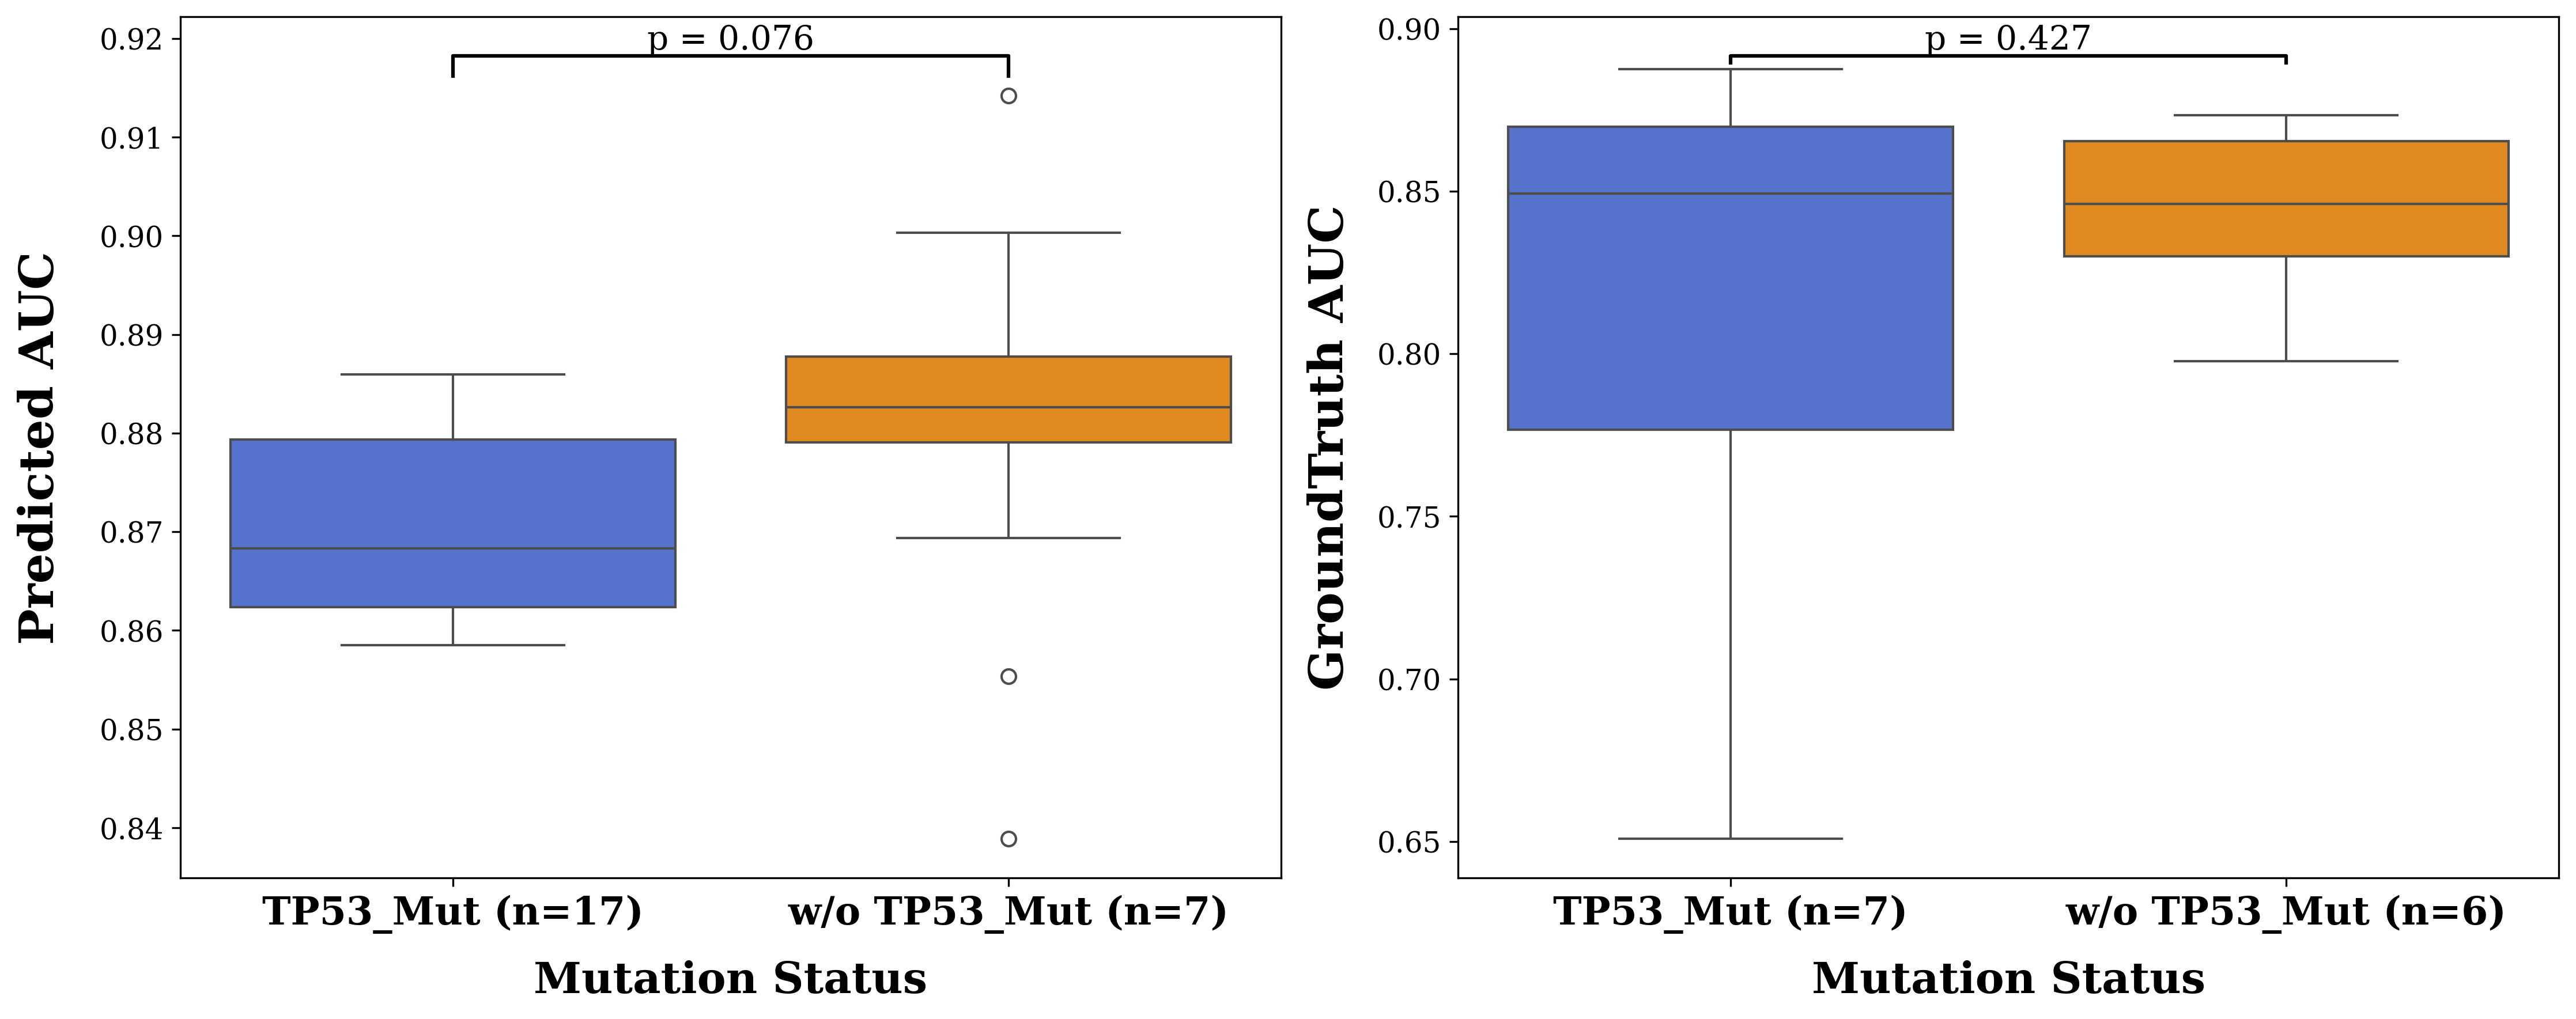

<Figure size 4500x1800 with 0 Axes>

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib as mpl

# Set up high-quality rendering
# plt.style.use('seaborn')  # Better default style
plt.style.use('default')  # Use default style instead of seaborn
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 300  # Higher resolution
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.figsize'] = (15, 6)  # Slightly larger figure
mpl.rcParams['path.simplify'] = True
mpl.rcParams['path.simplify_threshold'] = 1.0
mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
plt.rcParams["font.family"] = "serif"


plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'black'  # Explicitly set edge color
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')  # or any color you prefer
    spine.set_linewidth(1)  # adjust thickness as needed

# fig=plt.figure(figsize=(15,6))
plt.rcParams["font.family"] = "serif"
fig.suptitle(f'Comparison of {drug_name_short} treatment AUC response \n between {inhibit_Gene}-mutated and non-mutated {ccl_cancer_type} samples',fontsize=18, fontweight='bold',y=1.01,linespacing=1.5)

plt.subplot(1,2,1)
df = pd.DataFrame({'predicted AUC': np.concatenate(predAUCmatrix_df_type_drug.values) , 'mutation_status': sample_mut_label})
# Perform t-test
group1 = df[df["mutation_status"] == f'w/o {inhibit_Gene}_Mut']["predicted AUC"]
group2 = df[df["mutation_status"] == f'{inhibit_Gene}_Mut']["predicted AUC"]
t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)  # Welch’s t-test
custom_palette = {f'w/o {inhibit_Gene}_Mut': "royalblue", f'{inhibit_Gene}_Mut': "darkorange"}
ax = sns.boxplot(x="mutation_status", y="predicted AUC", data=df, palette=custom_palette)
# Annotate significance
x1, x2 = 0, 1  # Positions of the two boxplots
y, h = df["predicted AUC"].max() + 0.002, 0.002  # Adjust position
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='k')
plt.text((x1 + x2) / 2, y + h, f"p = {p_value:.3g}", ha='center', va='bottom', fontsize=14)
plt.xticks([1, 0], [f'w/o {inhibit_Gene}_Mut (n={len(group1)})', f'{inhibit_Gene}_Mut (n={len(group2)})'], fontsize=15, fontweight='bold')
# plt.title(f'Comparison of {drug_name_short} treatment Predicted AUC \n between {inhibit_Gene}-mutated and non-mutated {ccl_cancer_type} samples',fontsize=18, fontweight='bold')
plt.xlabel('Mutation Status', fontsize=18, fontweight='bold', labelpad=11)
plt.ylabel('Predicted AUC', fontsize=20, fontweight='bold', labelpad=15)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=12)

plt.subplot(1,2,2)
GTdf = pd.DataFrame({'GroundTruth AUC': np.concatenate(GT_AUC_df_type_drug_dropnan.values) , 'mutation_status': GT_mut_label_masked})
group1 = GTdf[GTdf["mutation_status"] == f"w/o {inhibit_Gene}_Mut"]["GroundTruth AUC"]
group2 = GTdf[GTdf["mutation_status"] == f"{inhibit_Gene}_Mut"]["GroundTruth AUC"]
t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)  # Welch’s t-test
custom_palette = {f"w/o {inhibit_Gene}_Mut": "royalblue", f"{inhibit_Gene}_Mut": "darkorange"}
ax = sns.boxplot(x="mutation_status", y="GroundTruth AUC", data=GTdf, palette=custom_palette)
# Annotate significance
x1, x2 = 0, 1  # Positions of the two boxplots
y, h = GTdf["GroundTruth AUC"].max() + 0.002, 0.002  # Adjust position
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c='k')
plt.text((x1 + x2) / 2, y + h, f"p = {p_value:.3g}", ha='center', va='bottom', fontsize=14)
plt.xticks([1, 0], [f'w/o {inhibit_Gene}_Mut (n={len(group1)})', f'{inhibit_Gene}_Mut (n={len(group2)})'], fontsize=15, fontweight='bold')
plt.xlabel('Mutation Status', fontsize=18, fontweight='bold', labelpad=11)
plt.ylabel('GroundTruth AUC', fontsize=20, fontweight='bold', labelpad=10)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=12)
# plt.title(f'Comparison of {drug_name_short} treatment Ground Truth AUC \n between {inhibit_Gene}-mutated and non-mutated {ccl_cancer_type} samples',fontsize=18, fontweight='bold')
plt.show()
plt.savefig('./inference/high_quality_TP53 COAD 5Flu.png', format='png', dpi=300)  # High-res raster

In [28]:
predAUCmatrix_df = pd.read_csv(best_weight_path+"predicted AUC values with UnknownGroundTruth samples.csv", sep=',', index_col=0)

# Attention matrix score (one drug one ccle/tcga)

In [79]:
drug_ID = "5-Fluorouracil"# PRISM:"BRD-K24844714-001-24-5"
cell_ID = "ACH-000007"
ccl_cancer_type = "COAD"
ccl_type = ccl_cancer_type
drug_name = "5-Fluorouracil"#'FLUOROURACIL (BRD:BRD-K24844714-001-24-5)'
drug_name_short = "5-Fluorouracil"#'Fluorouracil'
# ENCORAFENIB (BRD:BRD-A56085258-001-01-8): inhibit the mutated BRAF protein
# BINIMETINIB (BRD:BRD-K82244583-001-01-3): inhibit the MEK pathway
# FLUOROURACIL (BRD:BRD-K24844714-001-24-5): TP53 
inhibit_Gene = "TP53" # TP53 BRAF KRAS

In [80]:
omics_dict = {'Mut':0,'Exp':1,'CN':2, 'Eff':3, 'Dep':4, 'Met':5}
omics_data_dict = {}

In [81]:
for omic_type in include_omics:
    print("omic_type:",omic_type)
    omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep=',', index_col=0)
    print((omics_data_dict[omic_type]).shape )
    if omic_type == "Mut":
        sample_mut_label = ((omics_data_dict[omic_type])[inhibit_Gene] == 1).astype(int).tolist()
        print(sample_mut_label)
    if omic_type == "Exp":# apply Column-wise Min-Max Normalization 
        scaler = scaler_dict[omic_type]
        omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns)
    omics_numfeatures_dict[omic_type] = omics_data_dict[omic_type].shape[1]#.reshape(1, -1)#  index of specific CCL's omics data(contain gene profiles)
    # print((omics_data_dict[omic_type]) )
    # omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type], dtype=torch.float32).to(device).reshape(1, -1)
    # omics_numfeatures_dict[omic_type] = omics_data_dict[omic_type].shape[1]#[1]
    # print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])

omic_type: Exp
(1305, 1426)
Exp num_features 1426


In [82]:
# drug_df= pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/MACCS(Secondary_Screen_treatment_info)_union_NOrepeat.csv", sep=',', index_col=0)
# AUC_df = pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NOrepeat.csv", sep=',', index_col=0)
# matched AUCfile and omics_data samples

# matched_samples = sorted(set(AUC_df.T.columns) & set(list(omics_data_dict.values())[0].T.columns))
# AUC_df= (AUC_df.T[matched_samples]).T

print("AUC_df",AUC_df.shape)
if AUCtransform == "-log2":
    AUC_df = -np.log2(AUC_df)
if AUCtransform == "-log10":
    AUC_df = -np.log10(AUC_df)
    
print("drug_df",drug_df.shape)
print("AUC_df",AUC_df.shape)

AUC_df (17088, 7)
drug_df (394, 10)
AUC_df (17088, 7)


In [83]:
drug_df

Dataset                                       MACCS166bits  \
DRUG_NAME                                                                      
(5z)-7-oxozeaenol   GDSC1  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
5-fluorouracil      GDSC2  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
I-BET 151           GDSC1  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
a-443654            GDSC1  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
a-770041            GDSC1  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
...                   ...                                                ...   
zg-10               GDSC1  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
zibotentan          GDSC1  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
zm447439            GDSC2  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
zoledronate         GDSC2  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
zstk474             GDSC1  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   

                            PATHWAY_NAME  \
DRUG_NAME                                  
(5z)-7-oxozeaenol         Other, kinases   
5-fluorouracil                     Other   
I-BET 151                Chromatin other   
a-443654             PI3K/MTOR signaling   
a-770041                  Other, kinases   
...                                  ...   
zg-10              JNK and p38 signaling   
zibotentan                         Other   
zm447439                         Mitosis   
zoledronate                 Unclassified   
zstk474              PI3K/MTOR signaling   

                                                              SMILES  \
DRUG_NAME                                                              
(5z)-7-oxozeaenol  C[C@H]1C/C=C\C(=O)[C@H]([C@H](C/C=C/C2=C(C(=CC...   
5-fluorouracil                                 Fc1c[nH]c(=O)[nH]c1=O   
I-BET 151          COc1cc2c3n([C@H](C)c4ccccn4)c(=O)[nH]c3cnc2cc1...   
a-443654           CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OC[C@H](CC4=C...   
a-770041           CC(=O)N1CCN(CC1)C2CCC(CC2)N3C4=NC=NC(=C4C(=N3)...   
...                                                              ...   
zg-10              CN(C)C/C=C/C(=O)NC1=CC=C(C=C1)C(=O)NC2=CC=CC(=...   
zibotentan         CC1=CN=C(C(=N1)OC)NS(=O)(=O)C2=C(N=CC=C2)C3=CC...   
zm447439           COC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=C(C=C3)NC(=O)...   
zoledronate                     C1=CN(C=N1)CC(O)(P(=O)(O)O)P(=O)(O)O   
zstk474            C1COCCN1C2=NC(=NC(=N2)N3C4=CC=CC=C4N=C3C(F)F)N...   

                                name           pathway_name     pubchem  \
DRUG_NAME                                                                 
(5z)-7-oxozeaenol  (5z)-7-oxozeaenol         Other, kinases   9863776.0   
5-fluorouracil        5-fluorouracil                  Other      3385.0   
I-BET 151                  i-bet-151                    NaN         NaN   
a-443654                    a-443654    PI3K/MTOR signaling  10172943.0   
a-770041                    a-770041         Other, kinases   9549184.0   
...                              ...                    ...         ...   
zg-10                          zg-10  JNK and p38 signaling  57340680.0   
zibotentan                zibotentan                  Other   9910224.0   
zm447439                    zm447439                Mitosis   9914412.0   
zoledronate              zoledronate                  Other     68740.0   
zstk474                      zstk474    PI3K/MTOR signaling  11647372.0   

                                           synonyms  \
DRUG_NAME                                             
(5z)-7-oxozeaenol       5Z-7-Oxozeaenol, LL-Z1640-2   
5-fluorouracil                                 5-FU   
I-BET 151                              GSK12100151A   
a-443654                                 KIN001-139   
a-770041                                 KIN001-111   
...                                             ...   
zg-10                                             -

In [84]:
# get specific drug and ccl
drug_df = pd.read_csv( drug_df_path, sep=',')
drug_df = drug_df.set_index('name', drop=False)
# get specific drug and ccl
drug_df = drug_df[drug_df['name'].str.lower() == drug_name.lower()]
print(drug_df)
#get pair GT response 
# matching_columns_name = [col for col in AUC_df.loc[cell_ID].index if drug_ID in col]
# print("matching_columns_name", matching_columns_name)

Label_df = AUC_df[(AUC_df['ModelID'] == cell_ID) & 
            (AUC_df['drug_name'].str.lower() == drug_name.lower())] #(AUC_df.loc[cell_ID])[matching_columns_name] # MK-5108 (BRD:BRD-K53665955-001-03-0)
print("Label_df\n",Label_df)
Label_df
#get pair predicted response 
# predAUCmatrix_df_pair = (predAUCmatrix_df.loc[cell_ID])[matching_columns_name]
# print("predAUCmatrix_df_pair\n",predAUCmatrix_df_pair)

                     DRUG_NAME PATHWAY_NAME synonyms pathway_name  \
name                                                                
5-fluorouracil  5-fluorouracil        Other     5-FU        Other   

                                    target  pubchem Dataset            name  \
name                                                                          
5-fluorouracil  Antimetabolite (DNA & RNA)   3385.0   GDSC2  5-fluorouracil   

                               SMILES  \
name                                    
5-fluorouracil  Fc1c[nH]c(=O)[nH]c1=O   

                                                     MACCS166bits  
name                                                               
5-fluorouracil  0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
Label_df
          drug_name  Label drug_name_normalized     mapped_name  lnIC50  \
36  5-fluorouracil      1        5fluorouracil  5-fluorouracil    0.72   

            primary_disease     ModelID  
36  Colon/Colorectal Canc

drug_name  Label drug_name_normalized     mapped_name  lnIC50  \
36  5-fluorouracil      1        5fluorouracil  5-fluorouracil    0.72   

            primary_disease     ModelID  
36  Colon/Colorectal Cancer  ACH-000007

In [85]:
if ESPF is True:
    drug_smiles =drug_df["SMILES"] # smiles
    drug_names =drug_df.index
    # 挑出重複的SMILES
    duplicate =  drug_df["SMILES"][drug_df["SMILES"].duplicated(keep=False)] #duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]

    #--------------------------------------------------------------------------------------------------------------------------
    #ESPF
    vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency
    # 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
    drug_df["drug_encode"] = pd.Series(drug_df["SMILES"]).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
    drug_encode=drug_df["drug_encode"]
    print("drug_encode",drug_df["drug_encode"][0][2])
    drug_df["drug_encode"] = [i[:2] for i in drug_df["drug_encode"].values]
    print(drug_df["drug_encode"] )
else:
    drug_df["drug_encode"]=[list(map(int, item.split(','))) for item in drug_df["MACCS166bits"].values]
#--------------------------------------------------------------------------------------------------------------------------
num_ccl = list(omics_data_dict.values())[0].shape[0]
num_drug = drug_df["drug_encode"].shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)

num_ccl,num_drug:  1305 1


In [86]:
if 'weighted' in criterion.loss_type :    
    # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
    weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
    total_samples = (~np.isnan(AUC_df.values)).sum().item()
    fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
    moreWt_samples = total_samples - fewWt_samples
    few_weight = total_samples / (2 * fewWt_samples)  
    more_weight = total_samples / (2 * moreWt_samples)   
else:
    weighted_threshold = None
    few_weight = None
    more_weight = None
print("weighted_threshold:",weighted_threshold)

weighted_threshold: None


In [87]:
set_seed(seed)

dataset = InstanceResponseDataset(Label_df, omics_data_dict, drug_df, drug_graph, include_omics, device)
onedrug_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [88]:
# eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
(eval_targets, eval_outputs,predAUCwithUnknownGT,
AttenScorMat_DrugSelf ,AttenScorMat_DrugCellSelf,
eval_outputs_before_final_activation_list,  
mean_batch_eval_loss_WO_penalty)  = evaluation(model, None,None,
                                            criterion, onedrug_loader, device,ESPF,Drug_SelfAttention, 
                                            weighted_threshold, few_weight, more_weight, 
                                            outputcontrol='inference')


In [89]:
# drug selfattention
print(AttenScorMat_DrugSelf.shape)
# average the 8head attention score matrix
AttenScorMat_DrugSelf = AttenScorMat_DrugSelf.mean(dim=1).squeeze(0)# torch.Size([bsz, 8, 50, 50])
# ==>[bsz, 50, 50]
print(AttenScorMat_DrugSelf.shape)

# DrugCell selfattention
print(AttenScorMat_DrugCellSelf.shape)
# average the 8head attention score matrix
AttenScorMat_DrugCellSelf = AttenScorMat_DrugCellSelf.mean(dim=1).squeeze(0)# torch.Size([bsz, 8, 50, 50])
# ==>[bsz, 50, 50]
print(AttenScorMat_DrugCellSelf.shape)

AttributeError: 'NoneType' object has no attribute 'shape'

In [22]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
def heatmap(attention_scores_Matrix, drug_ID, cell_ID,drug_name_short,ccl_type, include_omics ,fontsize_ticks=12, module="", sub=None ):

    # Set up high-quality rendering
    # plt.style.use('seaborn')  # Better default style
    plt.style.use('default')  # Use default style instead of seaborn
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    mpl.rcParams['figure.dpi'] = 300  # Higher resolution
    mpl.rcParams['savefig.dpi'] = 300
    mpl.rcParams['figure.figsize'] = (10, 10)  # Slightly larger figure
    mpl.rcParams['path.simplify'] = True
    mpl.rcParams['path.simplify_threshold'] = 1.0
    mpl.rcParams['agg.path.chunksize'] = 10000
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['figure.constrained_layout.use'] = True
    plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
    plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
    plt.rcParams["font.family"] = "serif"
    
    # # Define the colors and their corresponding positions (anchors)
    # colors = ["#67749f","#6581b2","#b4d5e5", "white","#fae19b","#e9a94f", "red","#a10318"]  # Color sequence
    # anchors = [0.0,0.1, 0.35,0.5,0.55,0.75,0.9, 1.0]  # Position of each color (0 = min, 1 = max)
    # custom_cmap = LinearSegmentedColormap.from_list("custom_heatmap", list(zip(anchors, colors)))
    colors = [ "#6581b2", "#b4d5e5", "white", "#fae19b", "#e9a94f", "red"]
    custom_cmap = LinearSegmentedColormap.from_list("custom_attention", colors)

    # plt.figure(figsize=(10, 8))
    plt.rcParams["font.family"] = "serif"
    plt.imshow(attention_scores_Matrix, aspect="auto", cmap=custom_cmap) # make all color correspond to the specific value
    cbar = plt.colorbar(label="attention score")
    cbar.ax.yaxis.label.set_weight("bold")  # Make label bold
    cbar.ax.set_ylabel("Attention Score", fontsize=20)
    cbar.outline.set_visible(False) # remove the boundary/frame of the colorbar 
    

    # Set x and y axis labels
    if module == "AttenScorMat_DrugSelf":
        plt.xlabel("Drug Substructures", fontsize=20, fontweight='bold', fontname="serif")
        plt.ylabel("Drug Substructures", fontsize=20, fontweight='bold', fontname="serif")
    if module == "AttenScorMat_DrugCellSelf":
        plt.xlabel(f"Substructures_number: {len(drug_encode.values[0][2])}", fontsize=20, fontweight='bold', fontname="serif")
        plt.ylabel(f"Substructures_number: {len(drug_encode.values[0][2])}", fontsize=20, fontweight='bold', fontname="serif")
        
    # Optionally, set the x and y ticks (example with some labels)
    if module == "AttenScorMat_DrugSelf":
        plt.title(f"{drug_ID} \n SelfAttention Score Matrix\n {drug_name_short} - {ccl_type} cell line", fontsize=22, fontweight='bold',y=1.01,linespacing=1.7)
        if sub is not None:
             # Add text annotations for each cell
            rows, cols = attention_scores_Matrix.shape
            for i in range(rows):
                for j in range(cols):
                    plt.text(j, i, f"{attention_scores_Matrix[i, j]:.3f}",  # Format to 2 decimal places
                            ha="center", va="center", color="black", fontsize=12)
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub]) ) 
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub]) ) 
        else:
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=[f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1])])
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=[f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1])])
            
    if module == "AttenScorMat_DrugCellSelf":
        plt.title(f"{drug_ID} - {cell_ID} \n SelfAttention Score Matrix \n {drug_name_short} - {ccl_type} cell line", fontsize=22, fontweight='bold',y=1.01,linespacing=1.7)
        if sub is not None:
             # Add text annotations for each cell
            rows, cols = attention_scores_Matrix.shape
            for i in range(rows):
                for j in range(cols):
                    plt.text(j, i, f"{attention_scores_Matrix[i, j]:.3f}",  # Format to 2 decimal places
                            ha="center", va="center", color="black", fontsize=12)
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub] + include_omics) ) 
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"{i}" for i in sub] + include_omics) ) 
        else:
            plt.xticks(fontsize=fontsize_ticks,fontweight="bold",rotation=75, ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1]-len(include_omics))] + include_omics) ) 
            plt.yticks(fontsize=fontsize_ticks,fontweight="bold",ticks=np.arange(0, attention_scores_Matrix.shape[1], step=1), labels=([f"sub{i+1}" for i in range(attention_scores_Matrix.shape[1]-len(include_omics))] + include_omics) ) 
        
        
    for spine in plt.gca().spines.values(): # remove the boundary/frame of the plot 
        spine.set_visible(False)
    plt.show()

In [23]:
heatmap(AttenScorMat_DrugCellSelf.cpu(), drug_ID, cell_ID, drug_name_short, ccl_type, include_omics, fontsize_ticks=8 ,module="AttenScorMat_DrugCellSelf")

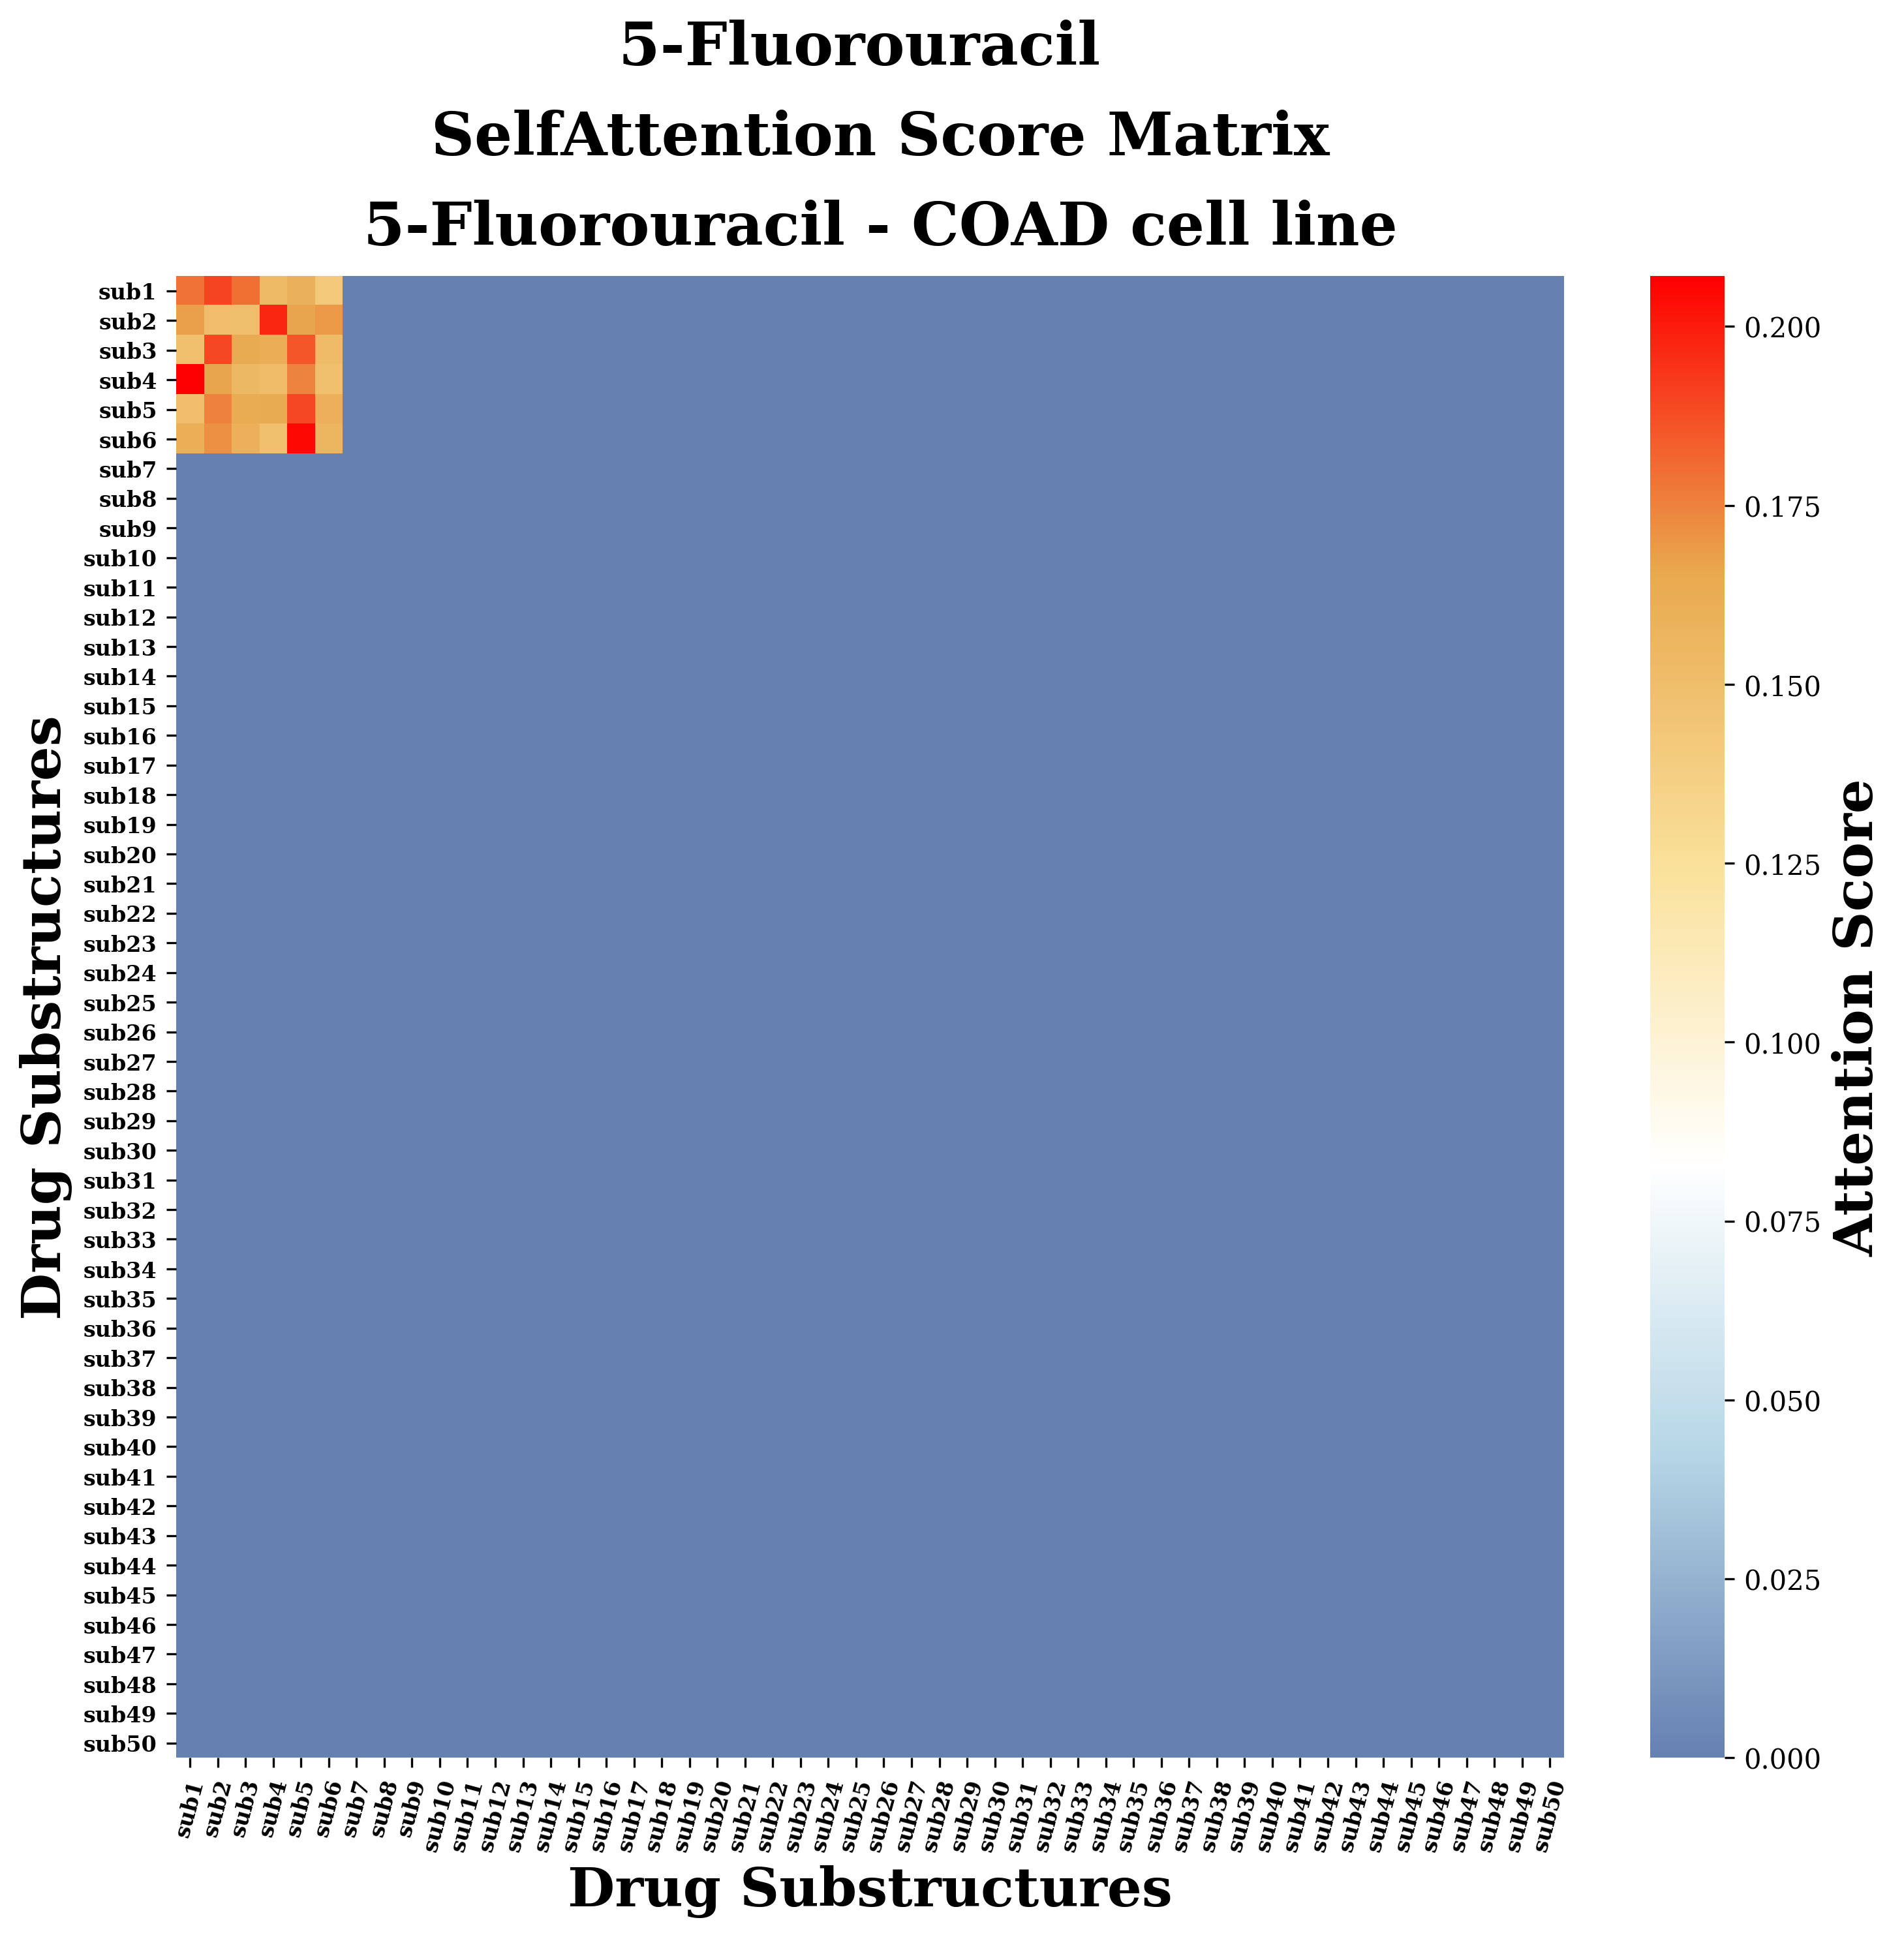

In [24]:
heatmap(AttenScorMat_DrugSelf.cpu(), drug_ID, cell_ID, drug_name_short, ccl_type, include_omics, fontsize_ticks=8 ,module="AttenScorMat_DrugSelf" )

In [25]:
print("drug_encode",drug_df["drug_encode"])
print(drug_encode.values[0][2])
print(len(drug_encode.values[0][2]))

drug_encode name
5-Fluorouracil    ([1228, 1455, 82, 332, 63, 2098, 0, 0, 0, 0, 0...
Name: drug_encode, dtype: object
['O=', 'c1[nH]', 'cc(', 'F)c', '(=O)', '[nH]1']
6


In [26]:
drug_df["drug_encode"][0][1]

/tmp/ipykernel_30568/865545063.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  drug_df["drug_encode"][0][1]


array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

torch.Size([6, 6])


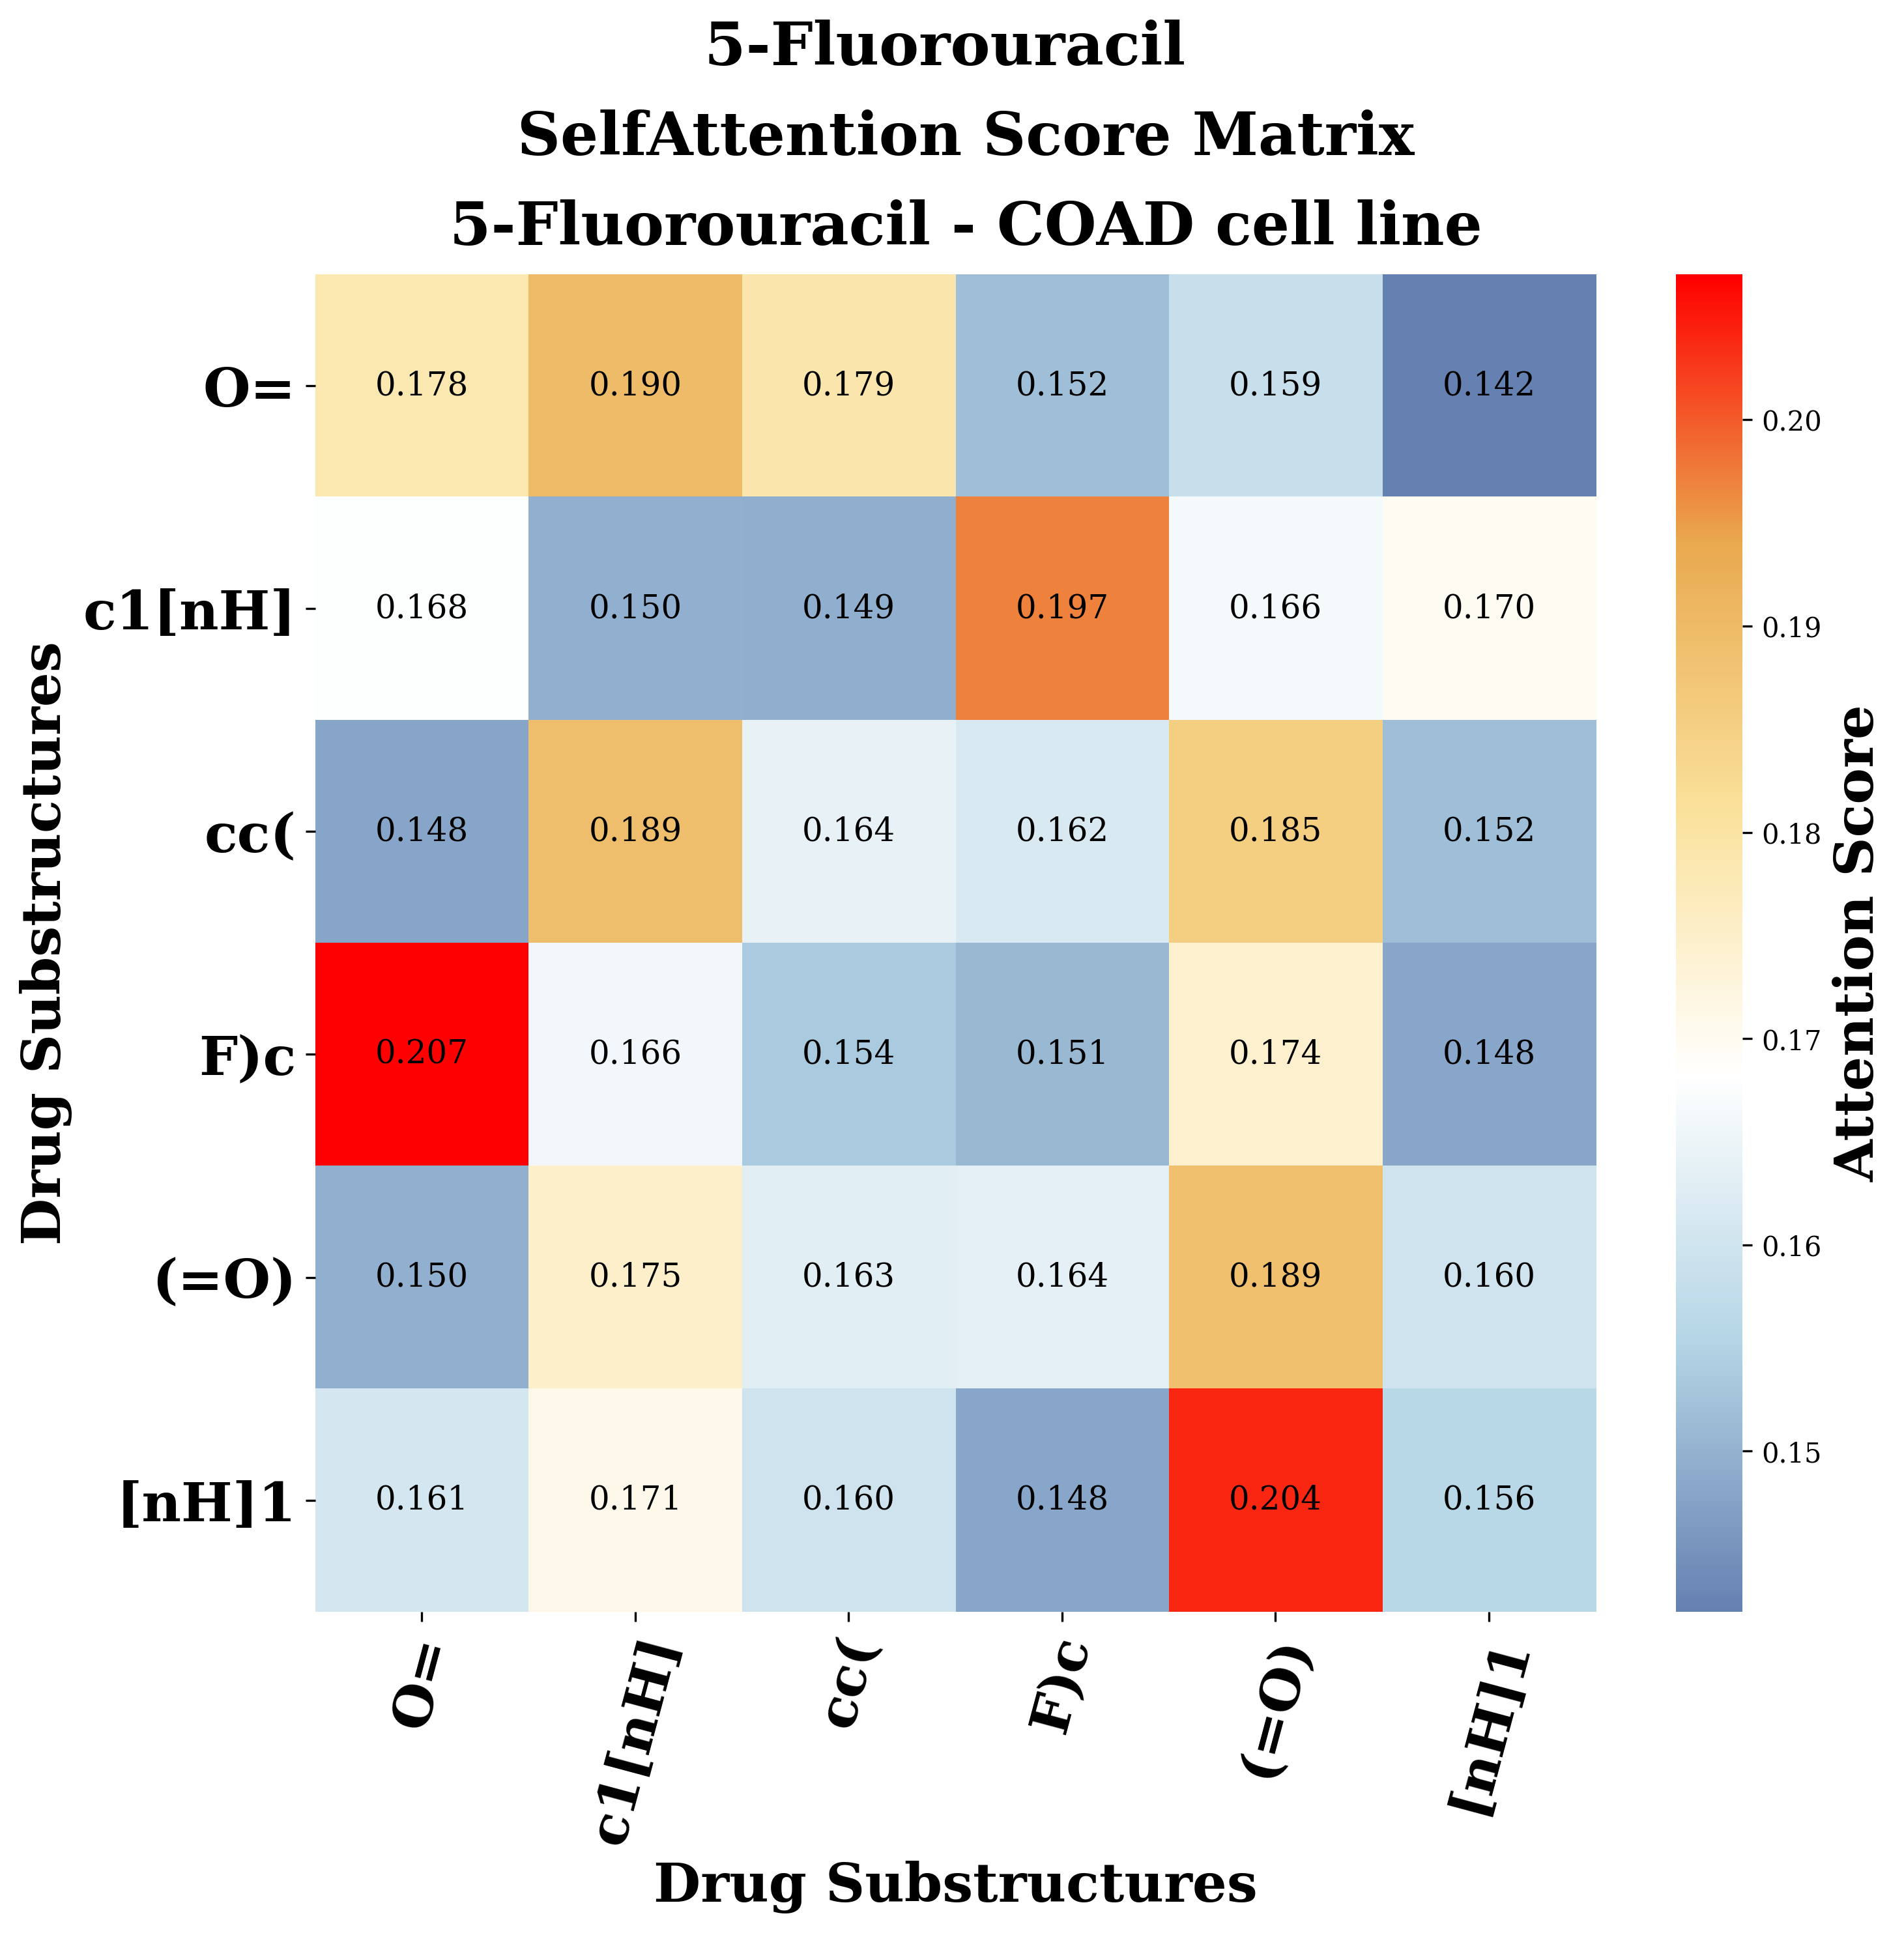

In [27]:
# print(drug_features_tensor) # Fc1c[nH]c(=O)[nH]c1=O 
# Remove rows with all zeros
non_zero_rows = AttenScorMat_DrugSelf[~torch.all(AttenScorMat_DrugSelf == 0, dim=1)]
# Remove columns with all zeros
AttenScorMat_DrugSelf_dropnan = non_zero_rows[:, ~torch.all(non_zero_rows == 0, dim=0)]
print(AttenScorMat_DrugSelf_dropnan.shape)
heatmap(AttenScorMat_DrugSelf_dropnan.cpu(), drug_ID, cell_ID, drug_name_short, ccl_type, include_omics, fontsize_ticks=20, module="AttenScorMat_DrugSelf", sub= drug_encode.values[0][2])

In [28]:
top2 = torch.sort(AttenScorMat_DrugSelf_dropnan.flatten(), descending=True)[:2] # 找出matrix中最大的兩個分數 和indeces

print("top2 indices of flattened score matrix:", top2[1][:2].tolist(),"\n","score values:",top2[0][:2].tolist())
max_y, max_x = divmod(top2[1][0].item(), AttenScorMat_DrugSelf_dropnan.shape[1]) # divmod(index, num_cols) num_cols:矩阵的列数
print("max score matrix index pair:","sub",max_y+1,",", "sub",max_x+1)
print("max score matrix index pair y-axis:", drug_encode.values[0][2][max_y] )
print("max score matrix index pair x-axis:", drug_encode.values[0][2][max_x] )
# print(" max drug category index pair:",drug_features_tensor[0][0][max_y].item(),",",drug_features_tensor[0][0][max_x].item())

sec_max_y, sec_max_x = divmod(top2[1][1].item(), AttenScorMat_DrugSelf_dropnan.shape[1])
print("sec_max score matrix index pair:","sub",sec_max_y+1,",", "sub",sec_max_x+1)
print("sec_max score matrix index pair y-axis:", drug_encode.values[0][2][sec_max_y] )
print("sec_max score matrix index pair x-axis:", drug_encode.values[0][2][sec_max_x] )

# print(" sec_max drug category index pair:",drug_features_tensor[0][0][sec_max_y].item(),",",drug_features_tensor[0][0][sec_max_x].item())

top2 indices of flattened score matrix: [18, 34] 
 score values: [0.20704975724220276, 0.2038472592830658]
max score matrix index pair: sub 4 , sub 1
max score matrix index pair y-axis: F)c
max score matrix index pair x-axis: O=
sec_max score matrix index pair: sub 6 , sub 5
sec_max score matrix index pair y-axis: [nH]1
sec_max score matrix index pair x-axis: (=O)


torch.Size([7, 7])


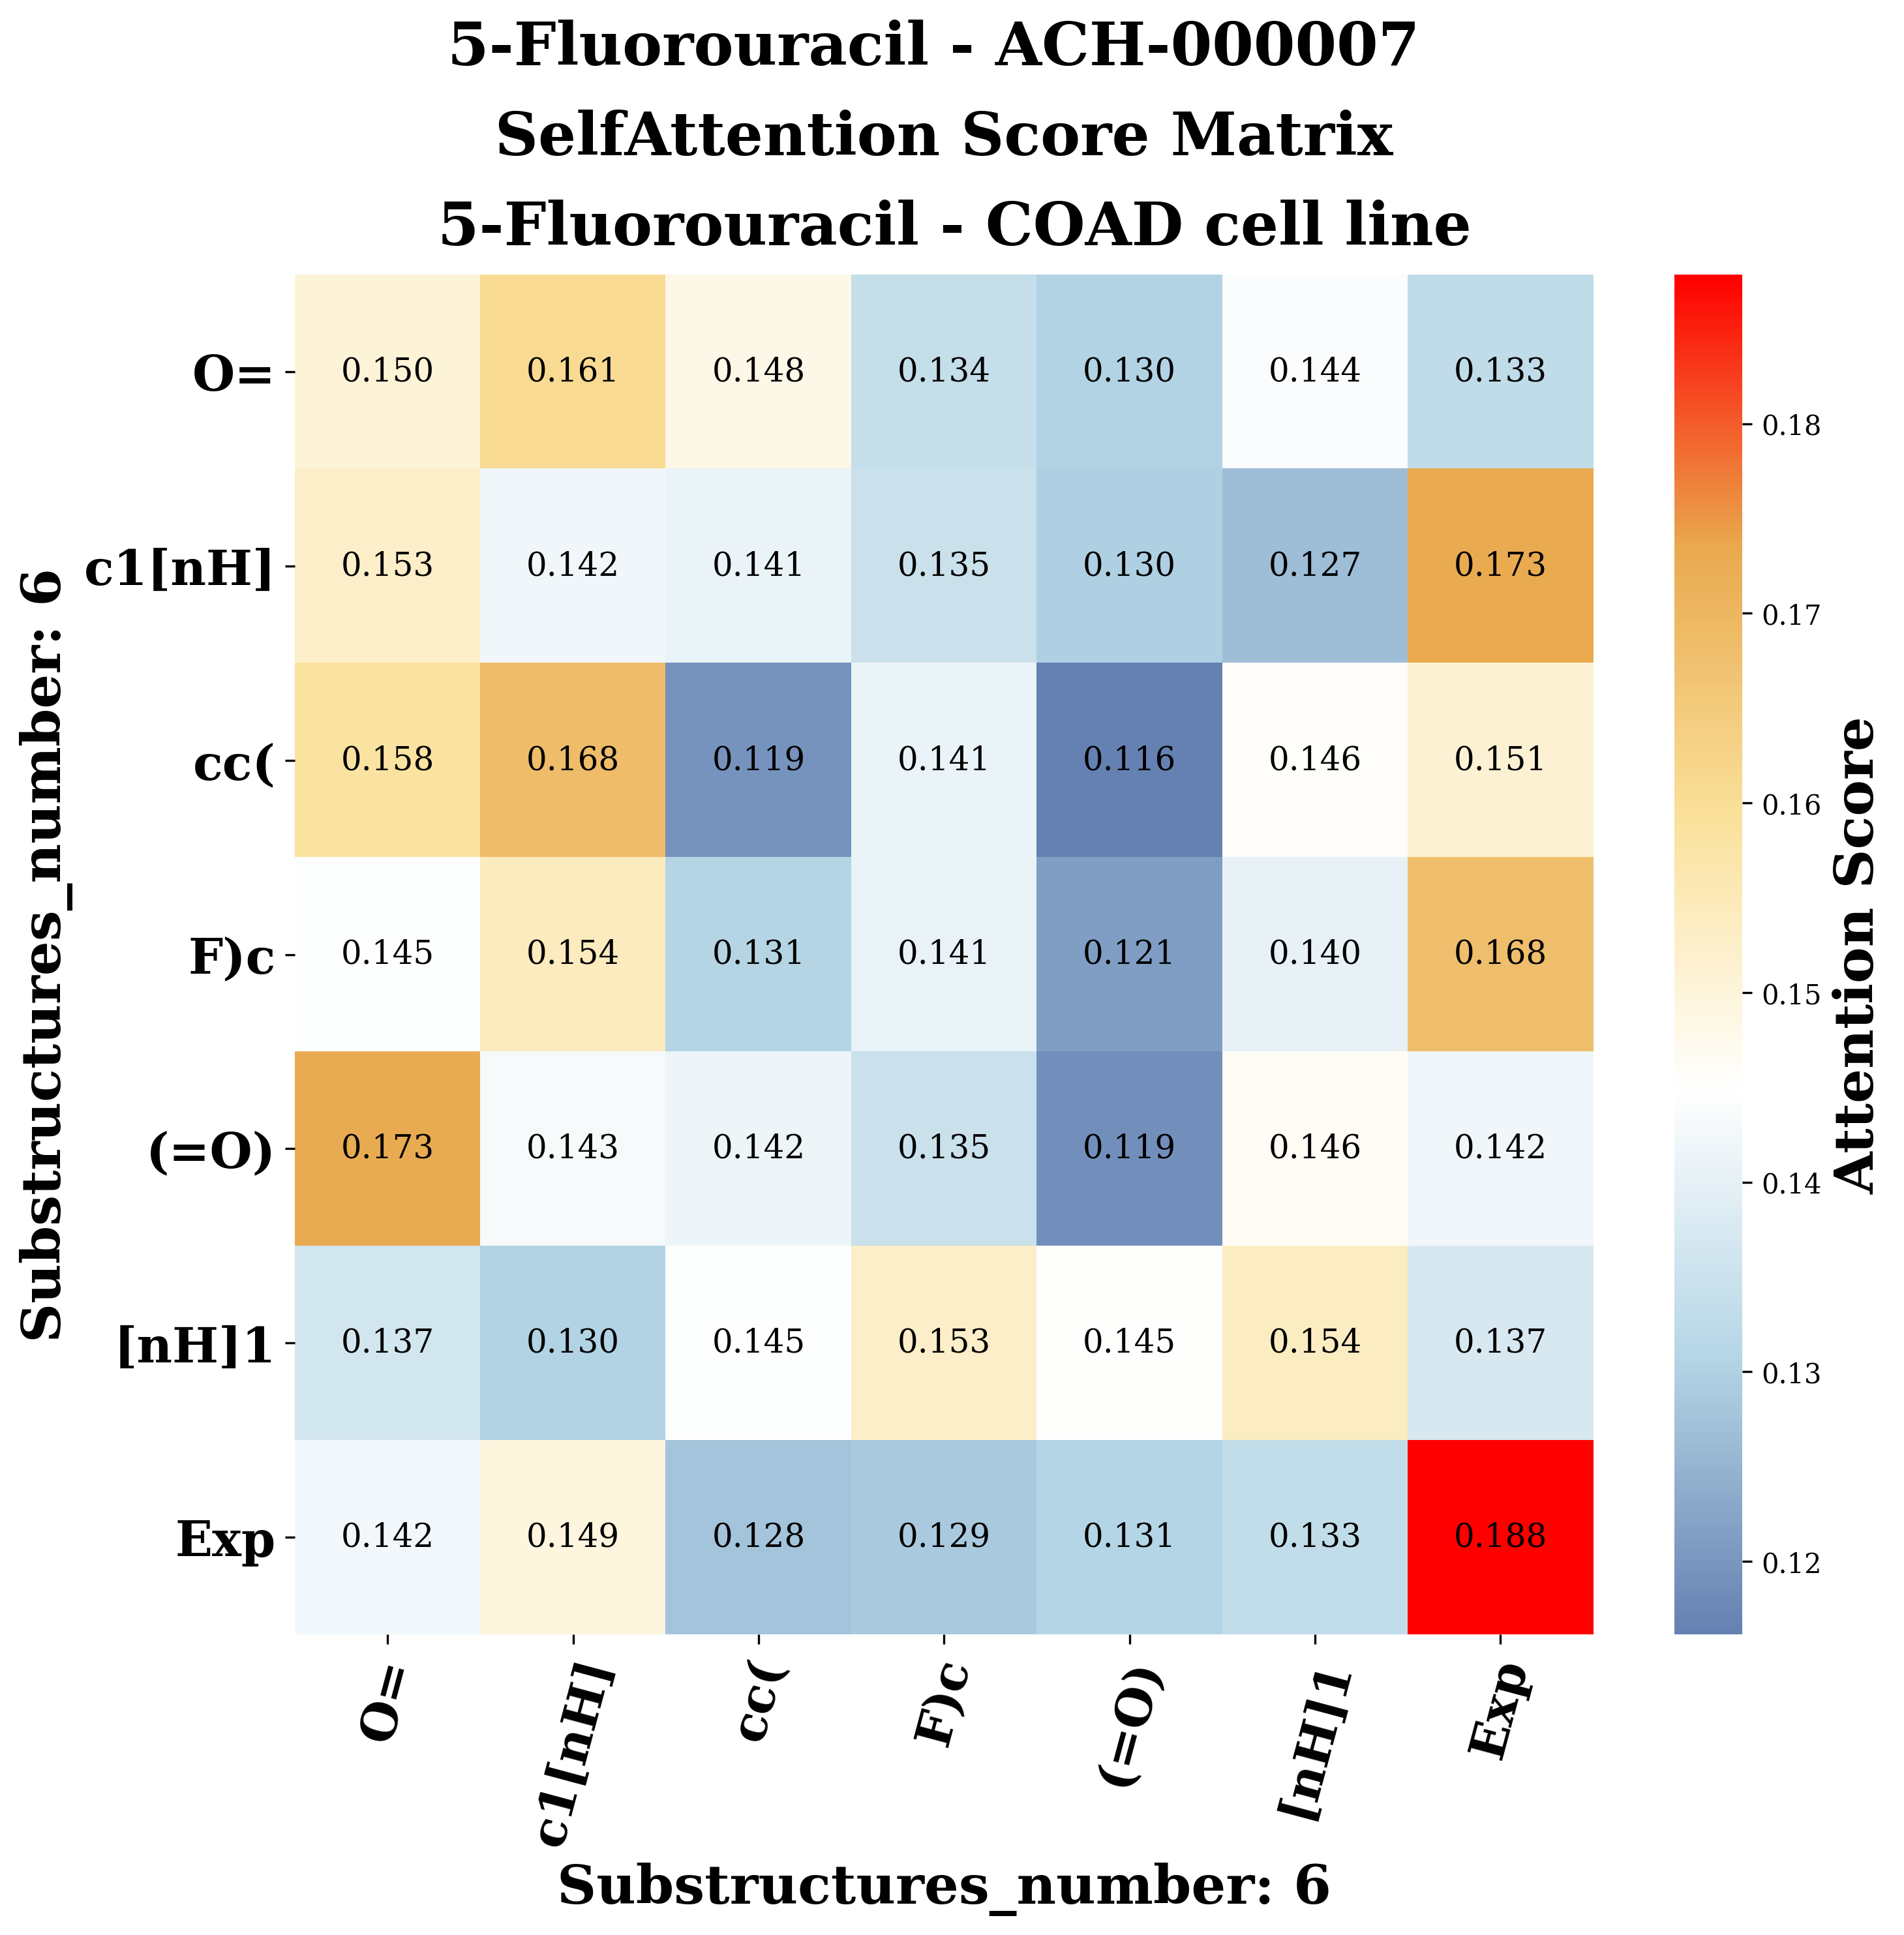

In [29]:
# Remove rows with all zeros
non_zero_rows = AttenScorMat_DrugCellSelf[~torch.all(AttenScorMat_DrugCellSelf == 0, dim=1)]
# Remove columns with all zeros
AttenScorMat_DrugCellSelf_dropnan = non_zero_rows[:, ~torch.all(non_zero_rows == 0, dim=0)]
print(AttenScorMat_DrugCellSelf_dropnan.shape)
heatmap(AttenScorMat_DrugCellSelf_dropnan.cpu(), drug_ID, cell_ID,drug_name_short,ccl_type, include_omics, fontsize_ticks=18, module="AttenScorMat_DrugCellSelf", sub= drug_encode.values[0][2])

In [30]:
top2 = torch.sort(AttenScorMat_DrugCellSelf_dropnan.flatten(), descending=True)[:2] # 找出matrix中最大的兩個分數 和indeces

print("top2 indices of flattened score matrix:", top2[1][:2].tolist(),"\n","score values:",top2[0][:2].tolist())
max_y, max_x = divmod(top2[1][0].item(), AttenScorMat_DrugCellSelf_dropnan.shape[1]) # divmod(index, num_cols) num_cols:矩阵的列数
print("max score matrix index pair:","sub",max_y+1,",","sub", max_x+1)
if max_y+1 > len(drug_encode.values[0][2]) and max_x+1 > len(drug_encode.values[0][2]):
    print("max score matrix index pair y-axis:", include_omics[ max_y - len(drug_encode.values[0][2]) ] )
    print("max score matrix index pair x-axis:", include_omics[ max_x - len(drug_encode.values[0][2]) ] )
elif max_y+1 > len(drug_encode.values[0][2]):
    print("max score matrix index pair y-axis:", include_omics[ max_y - len(drug_encode.values[0][2]) ] )
    print("max score matrix index pair x-axis:", drug_encode.values[0][2][max_x] )
elif max_x+1 > len(drug_encode.values[0][2]):   
    print("max score matrix index pair y-axis:", drug_encode.values[0][2][max_y] )
    print("max score matrix index pair x-axis:", include_omics[ max_x - len(drug_encode.values[0][2]) ] )
else:
    print("max score matrix index pair y-axis:", drug_encode.values[0][2][max_y] )
    print("max score matrix index pair x-axis:", drug_encode.values[0][2][max_x] )
# print(" max drug category index pair:",drug_features_tensor[0][0][max_y].item(),",",drug_features_tensor[0][0][max_x].item())

sec_max_y, sec_max_x = divmod(top2[1][1].item(), AttenScorMat_DrugCellSelf_dropnan.shape[1])
print("sec_max score matrix index pair:","sub",sec_max_y+1,",", "sub",sec_max_x+1)

if  sec_max_y+1 > len(drug_encode.values[0][2]) and sec_max_x+1 > len(drug_encode.values[0][2]):
    print("sec_max score matrix index pair y-axis:", include_omics[ sec_max_y - len(drug_encode.values[0][2]) ] )
    print("sec_max score matrix index pair x-axis:", include_omics[ sec_max_x - len(drug_encode.values[0][2]) ] )
elif sec_max_y+1 > len(drug_encode.values[0][2]):
    print("sec_max score matrix index pair y-axis:", include_omics[ sec_max_y - len(drug_encode.values[0][2]) ] )
    print("sec_max score matrix index pair x-axis:", drug_encode.values[0][2][sec_max_x] )
elif sec_max_x+1 > len(drug_encode.values[0][2]):   
    print("sec_max score matrix index pair y-axis:", drug_encode.values[0][2][sec_max_y] )
    print("sec_max score matrix index pair x-axis:", include_omics[ sec_max_x - len(drug_encode.values[0][2]) ] )
else:
    print("sec_max score matrix index pair y-axis:", drug_encode.values[0][2][sec_max_y] )
    print("sec_max score matrix index pair x-axis:", drug_encode.values[0][2][sec_max_y] )
# print(" sec_max drug category index pair:",drug_features_tensor[0][0][sec_max_y].item(),",",drug_features_tensor[0][0][sec_max_x].item())

top2 indices of flattened score matrix: [48, 13] 
 score values: [0.18785573542118073, 0.17322811484336853]
max score matrix index pair: sub 7 , sub 7
max score matrix index pair y-axis: Exp
max score matrix index pair x-axis: Exp
sec_max score matrix index pair: sub 2 , sub 7
sec_max score matrix index pair y-axis: c1[nH]
sec_max score matrix index pair x-axis: Exp


## TCGA inference, PDX inference

In [ ]:
import torchmetrics
from scipy.stats import ttest_ind
drug_list=["cisplatin", "5-fluorouracil", "gemcitabine", "sorafenib", "temozolomide"] #["cisplatin"]#
# drug_list=[
# "5zdata", "aicdata", "axidata", "az628data", "azd6482data", "azd7762data", "azd8055data",
# "bi2536data", "bms536data", "bms754data", "bosdata", "bx795data", "campdata", "chirdata",
# "dapdata", "embdata", "enzdata", "gefdata", "gsk19data", "gsk26data", "gw44data", "jnkdata",
# "jq1data", "kudata", "lesdata", "mkdata", "motdata", "nildata", "nutdata", "obadata",
# "pac1data", "paldata", "pd03data", "pd17data", "pf47data", "pf56data", "picdata", "ppldata",
# "rodata", "rucdata", "sbdata", "serddata", "sldata", "soradata", "tamdata", "twdata",
# "vordata", "weedata", "ykdata", "zmdata"
# ]
drugs_metrics={}
for drug_name in drug_list:
    if deconfound_EXPembedding is True:
        with open(f"../data/DAPL/share/pretrain/{DA_Folder}/TCGA/{drug_name}_latent_results.pkl", 'rb') as f:
            latent_dict = pickle.load(f)
            TCGAexp_df = pd.DataFrame(latent_dict).T # 32
    else:
        # TCGAexp_df = pd.read_csv(f"../data/DAPL/share/PDTC_fromDAPL/{drug_name}/pdtcdata.csv", sep=',', index_col=0)
        TCGAexp_df = pd.read_csv(f"../data/DAPL/share/TCGA_fromDAPL/{drug_name}/tcgadata.csv", sep=',', index_col=0) #1426
    # label_df = pd.read_csv(f"../data/DAPL/share/PDTC_fromDAPL/{drug_name}/pdtclabel.csv", sep=',', index_col=0)
    label_df = pd.read_csv(f"../data/DAPL/share/TCGA_fromDAPL/{drug_name}/tcgalabel.csv", sep=',', index_col=0)
    label_df = 1 - label_df # make label 0 to 1, 1 to 0 to match predicted output. after that 0: sensitive, 1: resistant
    print(f"TCGAexp {drug_name}data",TCGAexp_df.shape)
    print(f"label_df {drug_name}data",label_df.shape)
    TCGAmut_df = pd.read_csv(f"../data/DAPL/share/TCGA_fromDAPL/{drug_name}/tcgadata.csv", sep=',', index_col=0) #1426
    for omic_type in include_omics:
        if deconfound_EXPembedding is True:
            omics_data_dict["Exp"] = TCGAexp_df
        else:
            if omic_type == "Exp":
                scaler = StandardScaler() 
                omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(TCGAexp_df),index=TCGAexp_df.index,columns=TCGAexp_df.columns)
            elif omic_type == "Mut":
                omics_data_dict[omic_type] = TCGAmut_df
        omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
        print(omics_data_tensor_dict[omic_type].shape)
        omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]

        print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
        print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])

    drug_df_path= "../data/DAPL/share/GDSC_drug_merge_pubchem_dropNA.csv"
    drug_df = pd.read_csv( drug_df_path, sep=',', index_col=0)
    # get specific drug and ccl
    drug_df= drug_df[drug_df['name'] == drug_name]
    print(drug_df)
    if ESPF is True:
        drug_smiles =drug_df["SMILES"] # 
        print("drug_smiles",drug_smiles)
        drug_names =drug_df.index
        # 挑出重複的SMILES
        duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]
        #ESPF
        vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
        sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency
        # 將drug_smiles 使用_drug2emb_encoder function編碼成subword vector
        drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
        drug_features_tensor = torch.tensor(np.array([i[:2] for i in drug_encode.values]), dtype=torch.long).to(device)
    else:
        drug_encode = drug_df["MACCS166bits"]
        drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
        print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
        # Convert your data to tensors if they're in numpy
        drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
    #--------------------------------------------------------------------------------------------------------------------------
    num_ccl = list(omics_data_tensor_dict.values())[0].shape[0]
    num_drug = drug_encode.shape[0]
    print("num_ccl,num_drug: ",num_ccl,num_drug)

    response_matrix_tensor = torch.tensor(label_df.values, dtype=torch.float32).to(device).unsqueeze(1)
    # print(omics_data_tensor_dict)
    print(drug_features_tensor.shape)# Fc1c[nH]c(=O)[nH]c1=O 
    print(response_matrix_tensor.shape)
    # print(drug_encode.values)

    if 'weighted' in criterion.loss_type :    
        # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
        weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
        total_samples = (~np.isnan(AUC_df.values)).sum().item()
        fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
        moreWt_samples = total_samples - fewWt_samples
        few_weight = total_samples / (2 * fewWt_samples)  
        more_weight = total_samples / (2 * moreWt_samples)   
    else:
        weighted_threshold = None
        few_weight = None
        more_weight = None
    print("weighted_threshold:",weighted_threshold)

    set_seed(seed)
    dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)
    onedrug_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list, mean_batch_eval_lossWOpenalty
    (eval_targets, eval_outputs,predAUCwithUnknownGT,
    AttenScorMat_DrugSelf ,AttenScorMat_DrugCellSelf,
    _, 
    mean_batch_eval_loss_WO_penalty)  = evaluation(model, None,None,
                                                criterion, onedrug_loader, device,ESPF,Drug_SelfAttention, 
                                                weighted_threshold, few_weight, more_weight, 
                                                outputcontrol='inference')
    # Calculate classification metrics                                            
    drugs_metrics[drug_name] = metrics_calculator(torch.cat(eval_targets), torch.cat(eval_outputs),median_value)
    
    print("eval_targets\n",eval_targets)
    print("eval_outputs\n",eval_outputs)

    plt.rcParams["font.family"] = "serif"
    plt.rcParams['svg.fonttype'] = 'none'  # Use system fonts in SVG
    plt.rcParams['pdf.fonttype'] = 42  # Use Type 42 (TrueType) fonts
    df = pd.DataFrame({'predicted AUDRC': torch.cat(eval_outputs).cpu().numpy(),
                        'Label': torch.cat(eval_targets).cpu().numpy()})
    # Perform t-test between the two groups
    sensitive = df[df['Label'] == 0]['predicted AUDRC']
    resistant = df[df['Label'] == 1]['predicted AUDRC']
    t_stat, p_val = ttest_ind(sensitive, resistant)
    # plot
    fig, ax = plt.subplots(figsize=(5, 6))
    sns.boxplot(x='Label', y='predicted AUDRC', data=df, ax=ax)
    # Title and p-value annotation
    ax.set_title(f"predicted AUDRC by Label ({drug_name})", fontsize=14)
    p_text = f"p = {p_val:.4f}"
    x1, x2 = 0, 1
    y, h = max(df['predicted AUDRC']) + 0.002, 0.002
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
    ax.text((x1+x2) / 2, y+h, p_text, ha='center', va='bottom', fontsize=14, color='red')
    # Axis labels
    ax.set_xticklabels([    f'sensitive (n={len(sensitive)})\nlabel=0',
                            f'resistant (n={len(resistant)})\nlabel=1'], fontsize=14)
    ax.set_xlabel("Label", fontsize=14)
    ax.set_ylabel("predicted AUDRC", fontsize=14)
    plt.tight_layout()
    plt.show()

    if criterion.loss_type == "BCE":
        (test_cm ,  test_GT_0_count, test_GT_1_count, 
        test_pred_binary_0_count, test_pred_binary_1_count ) =metrics_calculator.confusion_matrix(torch.cat(eval_targets), torch.cat(eval_outputs), median_value)
        drugs_metrics[drug_name]["CM"] = test_cm
        # # plot confusion matrix
        cm_datas = [(test_cm, 'TCGA', 'Blues')]
        Confusion_Matrix_plot(cm_datas,hyperparameter_folder_path=None,drug=drug_name)
    else:
        device=torch.cat(eval_targets).device
        median_tensor = torch.tensor(median_value, dtype=torch.float32, device=device)
        GT = (torch.cat(eval_targets) > median_tensor).int()
        auroc = torchmetrics.classification.AUROC(task="binary").to(device)(torch.cat(eval_outputs),GT)  # Use raw scores
        auprc = torchmetrics.classification.AveragePrecision(task="binary").to(device)(torch.cat(eval_outputs),GT) # Use raw scores
        drugs_metrics[drug_name]["AUROC"] = auroc.item()
        drugs_metrics[drug_name]["AUPRC"] = auprc.item()
        drugs_metrics[drug_name][criterion.loss_type] = mean_batch_eval_loss_WO_penalty
        
if criterion.loss_type == "BCE":
    for drug, metrics in drugs_metrics.items():
        print(drug)
        print(f"  test {criterion.loss_type}loss: {mean_batch_eval_loss_WO_penalty:.4f}")
        for key in metrics_type_set:
            print(f"  '{key}': {metrics[key].item():.4f}")
        print()
else:
    for drug, metrics in drugs_metrics.items():
            print(drug)
            for key in ["AUROC", "AUPRC", criterion.loss_type]:
                print(f"  '{key}': {metrics[key]:.4f}")
            print()

TCGAexp cisplatindata (40, 1426)
label_df cisplatindata (40, 1)
torch.Size([6009])


IndexError: tuple index out of range

In [50]:
omics_data_tensor_dict['Mut'].shape

torch.Size([6009])

In [60]:
drug_list=["cisplatin", "5-fluorouracil", "gemcitabine", "sorafenib", "temozolomide"]
df_list = []
for drug_name in drug_list:
    label_df = pd.read_csv(f"../data/DAPL/share/TCGA_fromDAPL/{drug_name}/tcgalabel.csv", sep=',', index_col=0, header=None)
    label_df["drug"] = drug_name
    label_df.columns = ["label", "drug"]
    print(label_df.shape)
    df_list.append(label_df.drop((label_df.index[0])))
combined_df = pd.concat(df_list, axis=0)


(41, 2)
(22, 2)
(47, 2)
(27, 2)
(47, 2)


In [48]:
all_exp_df = pd.read_csv("../data/TCGA/TCGA_exp_matchCCLEgenes_8238samples_4692genes.txt", sep='\t', index_col=0)

In [49]:
combined_df

label          drug
0                               
TCGA-CG-5724     0     cisplatin
TCGA-90-A59Q     1     cisplatin
TCGA-55-7910     1     cisplatin
TCGA-BA-5149     1     cisplatin
TCGA-BA-6873     0     cisplatin
...            ...           ...
TCGA-28-5220     0  temozolomide
TCGA-32-1970     1  temozolomide
TCGA-32-5222     0  temozolomide
TCGA-41-2571     0  temozolomide
TCGA-76-4926     0  temozolomide

[179 rows x 2 columns]

In [ ]:
all_exp_df.index = all_exp_df.index.str[:-3]

In [61]:
match_samples=(set(all_exp_df.index) & set(combined_df.index))
print(len(match_samples))

171


In [62]:
combined_df = combined_df[combined_df.index.isin(match_samples)]
all_exp_df = all_exp_df[all_exp_df.index.isin(match_samples)]
all_exp_df = all_exp_df.loc[combined_df.index] # 讓兩個 df 的index排列一致

In [ ]:
Site_Codes = pd.read_csv("../data/TCGA/Tissue Source Site Codes.csv", sep=',', index_col=0)
Site_Codes

Source Site  \
TSS Code                                      
01        International Genomics Consortium   
02                MD Anderson Cancer Center   
04               Gynecologic Oncology Group   
05                                Indivumed   
06                      Henry Ford Hospital   
...                                     ...   
ZS                      Tayside Tissue Bank   
ZT        International Genomics Consortium   
ZU                          Spectrum Health   
ZW                    University of Alabama   
ZX                    University of Alabama   

                                                 Study Name  BCR  
TSS Code                                                          
01                        Ovarian serous cystadenocarcinoma  IGC  
02                                  Glioblastoma multiforme  IGC  
04                        Ovarian serous cystadenocarcinoma  IGC  
05                                      Lung adenocarcinoma  IGC  
06                                  Glioblastoma multiforme  IGC  
...                                                     ...  ...  
ZS                           Liver hepatocellular carcinoma  NCH  
ZT                                                  Thymoma  NCH  
ZU                                       Cholangiocarcinoma  NCH  
ZW                                Pancreatic adenocarcinoma  NCH  
ZX        Cervical squamous cell carcinoma and endocervi...  NCH  

[830 rows x 3 columns]

In [ ]:
tcga_tss_codes = combined_df.index.str.split('-').str[1] # 擷取出擷取出tss_code
combined_df['TSS_code'] = tcga_tss_codes # 將tss_code新增一個欄位
combined_df['Study Name'] = combined_df['TSS_code'].map(Site_Codes['Study Name'])# 將tss_code對應到Study Name並增加欄位
combined_df

label          drug TSS_code  \
0                                           
TCGA-CG-5724     0     cisplatin       CG   
TCGA-90-A59Q     1     cisplatin       90   
TCGA-55-7910     1     cisplatin       55   
TCGA-BA-5149     1     cisplatin       BA   
TCGA-BA-6873     0     cisplatin       BA   
...            ...           ...      ...   
TCGA-28-5220     0  temozolomide       28   
TCGA-32-1970     1  temozolomide       32   
TCGA-32-5222     0  temozolomide       32   
TCGA-41-2571     0  temozolomide       41   
TCGA-76-4926     0  temozolomide       76   

                                         Study Name  
0                                                    
TCGA-CG-5724                 Stomach adenocarcinoma  
TCGA-90-A59Q           Lung squamous cell carcinoma  
TCGA-55-7910                    Lung adenocarcinoma  
TCGA-BA-5149  Head and Neck squamous cell carcinoma  
TCGA-BA-6873  Head and Neck squamous cell carcinoma  
...                                             ...  
TCGA-28-5220                Glioblastoma multiforme  
TCGA-32-1970                Glioblastoma multiforme  
TCGA-32-5222                Glioblastoma multiforme  
TCGA-41-2571                Glioblastoma multiforme  
TCGA-76-4926                Glioblastoma multiforme  

[171 rows x 4 columns]

In [ ]:
TCGAexp_df = pd.read_csv(f"../data/DAPL/share/TCGA_fromDAPL/cisplatin/tcgadata.csv", sep=',', index_col=0)

In [62]:
allgene_mut_df = pd.read_csv("../data/TCGA/All_TCGA_mut_binary_excludeSpliceSite.csv", sep=',', index_col=0)